# Partie 1 : Collecte et nettoyage des données

Pour construire notre *dataset*, nous allons combiner des données financières, issues des rapports financiers des entreprises, ainsi que des données macro-économiques, compilées par le Professeur Damodaran.

## Section 1 : Données financières

Notre but est simple : collecter les données financières des 4 dernières années pour toutes les entreprises du S&P500 et de l'EuroStoxx 600.

Pour parvenir à nos fins, nous devons procéder en deux temps :
- Collecter les 500 tickers (codes d'identification) des entreprises du S&P500 et les 600 tickers de l'EuroStoxx600.
- Utiliser les tickers pour collecter les données financières sur YahooFinance grâce à l'API non-officielle yfinance.

In [ ]:
import yfinance as yf
import pandas as pd
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

### A - Collecte des tickers S&P500 et EuroStoxx600

La liste des tickers se trouvant sur Wikipédia, un script de scrapping relativement simple nous permet de récupérer la liste des tickers des entreprises du S&P500.

In [ ]:
sp500_tickers = []

try:
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
    response.raise_for_status()

    soup = BeautifulSoup(response.text, 'html.parser')
    table = soup.find('table', {'id': 'constituents'})

    if table:
        for row in table.find_all('tr')[1:]: # On ignore l'en-tête
            cells = row.find_all('td')
            if cells:
                ticker = cells[0].text.strip()
                # Remplacement spécifique aux tickers américains pour yfinance (actions de classes spéciales)
                ticker = ticker.replace('.', '-')
                sp500_tickers.append(ticker)

    print(f"{len(sp500_tickers)} tickers S&P 500 ont été collectés.")
except Exception as e:
    print(f"Erreur lors de la récupération des tickers S&P 500: {e}")

501 tickers S&P 500 ont été collectés.


Observons rapidement les tickers collectés : 

In [ ]:
print(sp500_tickers[:20])

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL']


Désormais, nous devons récupérer les tickers de l'EuroStoxx 600. Malheureusement, il n'existe pas de liste Wikipédia et nous sommes contraints d'utiliser une autre source : DividendMax. 

Nous faisons rapidement face à un problème. Les tickers YahooFinance ne sont pas standards : un suffixe correspondant à la place boursière européenne dans laquelle l'entreprise est cotée est ajouté par YahooFinance. 

Heureusement pour nous, DividendMax indique également la place de cotation. C'est pourquoi nous avons construit une rapide table de correspondance pour reconstruire les tickers scrappés au format YahooFinance.

In [ ]:
exchange_to_suffix_map = {
    'EURONEXT AMSTERDAM': '.AS',
    'ATHENS EXCHANGE': '.AT',
    'EURONEXT BRUSSELS': '.BR',
    'COPENHAGEN': '.CO',
    'DUB LIN': '.IR',
    'FRANKFURT STOCK EXCHANGE': '.DE', 
    'HELSINKI STOCK EXCHANGE': '.HE',    
    'LISBON STOCK EXCHANGE': '.PT',      
    'LONDON STOCK EXCHANGE': '.L',       
    'MADRID STOCK EXCHANGE': '.MC',      
    'MILAN STOCK EXCHANGE': '.MI',       
    'OSLO STOCK EXCHANGE': '.OL',        
    'EURONEXT PARIS': '.PA',             
    'STOCKHOLM STOCK EXCHANGE': '.ST',   
    'SIX SWISS EXCHANGE': '.SW',         
    'VIENNA STOCK EXCHANGE': '.VI',      
    'XETRA': '.DE',                     
    'ITALIAN STOCK EXCHANGE': '.MI',     
    'IRISH STOCK EXCHANGE': '.IR',       
    'WARSAW STOCK EXCHANGE': '.WA',      
    'VALENCIA STOCK EXCHANGE': '.MC',    
    'NEW YORK STOCK EXCHANGE': '',       
    'BERLIN STOCK EXCHANGE': '.BE',      
    'LUXEMBOURG STOCK EXCHANGE': '.LU',  
    'JOHANNESBURG STOCK EXCHANGE': '.JO'
}

Pour mener à bien le scrapping, nous allons devoir naviguer sur une vingtaine de pages, récupérer les données cibles (ticker, nom, exchange) et les stocker dans un dictionnaire.

In [ ]:
pip install lxml


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from io import StringIO

stoxx600_companies_data = []
base_url = "https://www.dividendmax.com/market-index-constituents/stoxx600"
headers = {
    "User-Agent": "Mozilla/5.0 (compatible; ColabEuroStoxx600Scraper/1.0)"
}
page_num = 1
max_pages_to_check = 20 # on veut éviter les boucles infinies

while page_num <= max_pages_to_check:

    url = f"{base_url}?page={page_num}"
    
    try:
        response = requests.get(url, headers=headers, timeout=20)
        response.raise_for_status()

        tables = pd.read_html(StringIO(response.text))

        # On gère les cas limites, notamment la dernière page
        if not tables:
            print(f"  [Info] No tables found on page {page_num}. Assuming last page reached.")
            break

        df = tables[0]
        if df.empty:
                print(f"  [Info] Table on page {page_num} is empty. Assuming last page reached.")
                break

        df.columns = [c.strip().lower() for c in df.columns]

        ticker_col_name = "ticker"
        name_col_name = "company"
        exchange_col_name = "exchange"         

        page_companies_data = []
        
        for index, row in df.iterrows():
            
            ticker = str(row[ticker_col_name]).strip().upper()
            name = str(row[name_col_name]).strip()
            exchange = str(row[exchange_col_name]).strip().upper()

            if ticker and name and exchange: # On écarte les cellules vides
                # On nettoie le nom des tickers
                if ticker.endswith('.'):
                    cleaned_ticker = ticker[:-1]
                else:
                    cleaned_ticker = ticker

                # On récupère le suffixe pour construire le YahooTicker
                yahoo_suffix = exchange_to_suffix_map.get(exchange, '')
                yahoo_ticker = f"{cleaned_ticker}{yahoo_suffix}"


                # On construit le dictionnaire
                page_companies_data.append({
                    'Ticker': ticker,
                    'Nom': name,
                    'YahooTicker': yahoo_ticker
                })

        # On gère le cas de la dernière page
        if not page_companies_data:
                break

        stoxx600_companies_data.extend(page_companies_data)
        page_num += 1 # Move to the next page

    except requests.exceptions.RequestException as e:
        print(f"  [Erreur] Erreur lors de la récupération de la page {page_num}: {e}")
        break

    except Exception as e:
        print(f"  [Erreur] Erreur lors du parsing de la page {page_num}: {e}")
        break 


print(f"{len(stoxx600_companies_data)} tickers Eurostoxx 600 ont été collectés.")
print(stoxx600_companies_data)

565 tickers Eurostoxx 600 ont été collectés.
[{'Ticker': '1U1', 'Nom': '1&1 DrillischAktiengesellschaft', 'YahooTicker': '1U1.DE'}, {'Ticker': 'III', 'Nom': '3i Group plc', 'YahooTicker': 'III.L'}, {'Ticker': 'A2A', 'Nom': 'A2A Spa', 'YahooTicker': 'A2A.MI'}, {'Ticker': 'AAK', 'Nom': 'AAK AB', 'YahooTicker': 'AAK.ST'}, {'Ticker': 'AALB', 'Nom': 'Aalberts NV', 'YahooTicker': 'AALB.AS'}, {'Ticker': 'ARL', 'Nom': 'Aareal Beteiligungen AG', 'YahooTicker': 'ARL.DE'}, {'Ticker': 'ABBN', 'Nom': 'ABB Ltd.', 'YahooTicker': 'ABBN.SW'}, {'Ticker': 'ABDN', 'Nom': 'Aberdeen Group Plc', 'YahooTicker': 'ABDN.L'}, {'Ticker': 'ABN', 'Nom': 'ABN AMRO Bank N.V. - NLDR', 'YahooTicker': 'ABN.AS'}, {'Ticker': 'AC', 'Nom': 'Accor', 'YahooTicker': 'AC.PA'}, {'Ticker': 'ACKB', 'Nom': 'Ackermans & van Haaren NV', 'YahooTicker': 'ACKB.BR'}, {'Ticker': 'ACS', 'Nom': 'ACS, Actividades de Construccion Y Servicios, S.A.', 'YahooTicker': 'ACS.MC'}, {'Ticker': 'ADEN', 'Nom': 'Adecco Group AG', 'YahooTicker': 'ADEN.SW'

On a récupéré 565 tickers sur 600, dont toutes les plus grosses entreprises européennes. On s'en contentera : les quelques entreprises écartées sont plus petites et le sont à cause d'irrégularités dans le nom des tickers.


### B - Collecte des informations financières

On peut maintenant passer à la deuxième étape : utiliser les tickers pour collecters les informations financières. On choisit ici de construire une fonction qui pourra être appelée pour construire les dataframe EuroStoxx et S&P500. L'objectif est de récupérer les données des trois états financiers (IS, CFS, BS) de chaque entreprise pour chaque année entre 2021 et 2024.

On a d'abord besoin de 3 fonctions préparatoires :

In [ ]:
def safe_div(a, b):
    """Division sécurisée, renvoie None si a ou b est None ou 0."""
    return a / b if a and b else None

def remove_tz(obj):
    """Supprime la timezone si tz-aware et index DatetimeIndex"""
    if isinstance(obj, pd.DataFrame) or isinstance(obj, pd.Series):
        if isinstance(obj.index, pd.DatetimeIndex) and obj.index.tz is not None:
            obj.index = obj.index.tz_localize(None)
    return obj

def parse_ticker(item, zone):
    """Retourne ticker_str, ticker_symbol, nom selon la zone."""
    if zone == 'USA':
        return item, item, item
    if zone == 'Eurostoxx' and isinstance(item, dict):
        ticker_str = item.get('Ticker', '')
        ticker_symbol = item.get('YahooTicker', '')
        nom = item.get('Nom', ticker_str)
        return ticker_str, ticker_symbol, nom
    return None, None, None

On peut désormais construire la fonction qui construit notre dataframe à partir de la liste des tickers :

In [ ]:
def fetch_historical_fundamentals(ticker_list, zone='USA'):
    historical_data_list = []
    years_to_keep = range(2021, 2025)

    def remove_tz(obj):
        """Supprime la timezone si tz-aware"""
        if hasattr(obj, 'index') and obj.index.tz is not None:
            obj.index = obj.index.tz_localize(None)
        elif hasattr(obj, 'tz') and obj.tz is not None:
            obj = obj.tz_localize(None)
        return obj

    for i, item in enumerate(ticker_list):
        
        # --- 1. Détermination des tickers selon la zone ---
        ticker_str, ticker_symbol, nom = parse_ticker(item, zone)
 
        try:
            ticker = yf.Ticker(ticker_symbol)

            # --- 2. Données qualitatives ---
            info = getattr(ticker, 'info', {})
            sector_val = info.get('sector', 'N/A')
            industry_val = info.get('industry', 'N/A')
            country_val = info.get('country', 'N/A')
            beta_val = info.get('beta', None)

            # --- 3. Données financières ---
            financials_t = remove_tz(ticker.financials.transpose() if not ticker.financials.empty else pd.DataFrame())
            balance_sheet_t = remove_tz(ticker.balance_sheet.transpose() if not ticker.balance_sheet.empty else pd.DataFrame())
            dividends = remove_tz(getattr(ticker, 'dividends', pd.Series(dtype='float64')))

            # --- 4. Nombre d'actions en circulation ---
            try:
                shares_history = remove_tz(ticker.get_shares_full(start="2020-01-01"))
            except Exception:
                shares_history = pd.Series(dtype='float64')

            if financials_t.empty or balance_sheet_t.empty:
                continue

            # --- 5. Boucle temporelle sur les périodes financières ---
            for period_date in financials_t.index:
                if period_date.year not in years_to_keep:
                    continue
                if period_date not in balance_sheet_t.index:
                    continue

                fin_row = financials_t.loc[period_date]
                bs_row = balance_sheet_t.loc[period_date]

                # --- 6. Extraction des données financières ---
                net_income = fin_row.get('Net Income')
                total_revenue = fin_row.get('Total Revenue')
                basic_eps = fin_row.get('Basic EPS')

                total_equity = bs_row.get('Total Stockholder Equity') or bs_row.get('Stockholders Equity')
                total_assets = bs_row.get('Total Assets')
                total_debt = bs_row.get('Total Debt')

                # --- 7. Prix de l'action en fin d'année ---
                start_date = period_date.normalize()
                end_date = (period_date + pd.Timedelta(days=4)).normalize()
                price_data_eod = ticker.history(start=start_date, end=end_date)
                price_data_eod = remove_tz(price_data_eod)
                close_price = price_data_eod['Close'].iloc[0] if not price_data_eod.empty else None

                # --- 8. Market Cap historique ---
                shares_outstanding = shares_history.asof(period_date) if not shares_history.empty else None
                historical_market_cap = close_price * shares_outstanding if close_price and shares_outstanding else None

                # --- 9. Dividendes annuels ---
                year_start = pd.Timestamp(f'{period_date.year}-01-01')
                year_end = pd.Timestamp(f'{period_date.year}-12-31')
                yearly_dividends = dividends[(dividends.index >= year_start) & (dividends.index <= year_end)] if not dividends.empty else pd.Series(dtype='float64')
                annual_dividends = yearly_dividends.sum() if not yearly_dividends.empty else None

                # --- 10. Volume annuel échangé sur les marchés ---
                yearly_history = ticker.history(start=year_start, end=year_end)
                yearly_history = remove_tz(yearly_history)
                annual_volume_traded = yearly_history['Volume'].sum() if not yearly_history.empty and 'Volume' in yearly_history.columns else None

                # --- 11. Ratios financiers ---
                roe = safe_div(net_income, total_equity)
                roa = safe_div(net_income, total_assets)
                debt_to_equity = safe_div(total_debt, historical_market_cap)
                per_calcule = safe_div(close_price, basic_eps)

                # --- 12. Construction du dictionnaire final ---
                historical_data_list.append({
                    'Ticker': ticker_str,
                    'YahooTicker': ticker_symbol,
                    'Nom': nom,
                    'Zone': zone,
                    'Sector': sector_val,
                    'Industry': industry_val,
                    'Country': country_val,
                    'Beta': beta_val,
                    'MarketCapitalization': historical_market_cap,
                    'SharesOutstanding': shares_outstanding,
                    'AnneeFiscale': period_date.year,
                    'DateRapport': period_date.strftime('%Y-%m-%d'),
                    'NetIncome': net_income,
                    'TotalRevenue': total_revenue,
                    'TotalEquity': total_equity,
                    'TotalAssets': total_assets,
                    'TotalDebt': total_debt,
                    'EPS': basic_eps,
                    'EOD_Close_Price': close_price,
                    'ROE_calcule': roe,
                    'ROA_calcule': roa,
                    'DebtToEquity_calcule': debt_to_equity,
                    'PER_calcule': per_calcule,
                    'Dividendes_Annuels': annual_dividends,
                    'Annual_Volume_Traded': annual_volume_traded
                })

        except Exception as e_outer:
            print(f"[Grave Erreur] {ticker_symbol}: {e_outer}")

    if not historical_data_list:
        return None

    # --- 13. Création et tri du DataFrame final ---
    df_historical = pd.DataFrame(historical_data_list)
    df_historical = df_historical.sort_values(by=['Ticker', 'AnneeFiscale'], ascending=[True, False])
    return df_historical

On peut maintenant construire notre dataframe pour l'EuroStoxx600 :

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df_eurostoxx600 = fetch_historical_fundamentals(stoxx600_companies_data, zone='Eurostoxx')

df_eurostoxx600.to_csv('data/df_eurostoxx600_raw.csv', index=False, encoding='utf-8-sig')

[Grave Erreur] ARL.DE: 'RangeIndex' object has no attribute 'tz'
[Grave Erreur] AIBG.IR: 'RangeIndex' object has no attribute 'tz'


HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: AMBU B"}}}


[Grave Erreur] AMBU B: 'RangeIndex' object has no attribute 'tz'


HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: MAERSK B"}}}


[Grave Erreur] MAERSK B: 'RangeIndex' object has no attribute 'tz'


Exception ignored from cffi callback <function buffer_callback at 0x10f73a7a0>:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/curl_cffi/curl.py", line 100, in buffer_callback
    @ffi.def_extern()
KeyboardInterrupt: 


[Grave Erreur] MT.AS: 'RangeIndex' object has no attribute 'tz'


On vérifie rapidement la cohérence du résultat :

In [ ]:
display(df_eurostoxx600.sample(10))

,Ticker,YahooTicker,Nom,Zone,Sector,Industry,Country,Beta,MarketCapitalization,SharesOutstanding,AnneeFiscale,DateRapport,NetIncome,TotalRevenue,TotalEquity,TotalAssets,TotalDebt,EPS,EOD_Close_Price,ROE_calcule,ROA_calcule,DebtToEquity_calcule,PER_calcule,Dividendes_Annuels,Annual_Volume_Traded
1224,PKN,PKN.WA,Orlen S.A.,Eurostoxx,Energy,Oil & Gas Integrated,Poland,0.749,6.648492e+10,1.171750e+09,2023,2023-12-31,2.092200e+10,3.719160e+11,1.523220e+11,2.644630e+11,2.589600e+10,18.0200,56.739849,0.137354,0.079111,0.389502,3.148715,5.500000,551515817
919,ITRK,ITRK.L,Intertek Group plc,Eurostoxx,Industrials,Specialty Business Services,United Kingdom,0.678,6.639467e+11,1.624330e+08,2022,2022-12-31,2.888000e+08,3.192900e+09,1.284000e+09,3.660300e+09,1.380800e+09,1.7920,4087.511230,0.224922,0.078901,0.002080,2280.977249,105.800000,100616231
748,GLEN,GLEN.L,Glencore plc,Eurostoxx,Basic Materials,Other Industrial Metals & Mining,Switzerland,0.587,5.722696e+12,1.221600e+10,2023,2023-12-31,4.280000e+09,2.178290e+11,4.358000e+10,1.238690e+11,3.224100e+10,0.3400,468.459076,0.098210,0.034553,0.005634,1377.820812,41.684899,9828693201
260,BAS,BAS.DE,Basf SE,Eurostoxx,Basic Materials,Chemicals,Germany,0.923,3.880387e+10,8.925220e+08,2023,2023-12-31,2.250000e+08,6.890200e+10,3.527700e+10,7.739500e+10,2.134700e+10,0.2500,43.476658,0.006378,0.002907,0.550125,173.906631,3.400000,640549610
519,DTE,DTE.DE,Deutsche Telekom AG,Eurostoxx,Communication Services,Telecom Services,Germany,0.283,1.410901e+11,4.978620e+09,2024,2024-12-31,1.120900e+10,1.151110e+11,6.329600e+10,3.049340e+11,1.471160e+11,2.2700,28.339209,0.177089,0.036759,1.042709,12.484233,0.770000,1652857799
646,FERG,FERG,Ferguson Plc.,Eurostoxx,Industrials,Industrial Distribution,United States,1.129,2.856604e+10,2.236390e+08,2021,2021-07-31,NaN,NaN,NaN,NaN,NaN,NaN,127.732826,NaN,NaN,NaN,NaN,4.194000,4864900
570,ENG,ENG.MC,Enagas SA,Eurostoxx,Utilities,Utilities - Regulated Gas,Spain,0.352,3.808176e+09,2.614880e+08,2021,2021-12-31,4.038260e+08,9.756860e+08,3.085430e+09,9.873718e+09,5.259712e+09,1.5443,14.563484,0.130882,0.040899,1.381163,9.430476,1.688000,268580473
278,BEZ,BEZ.L,Beazley Plc.,Eurostoxx,Financial Services,Insurance - Specialty,United Kingdom,0.136,2.838174e+11,6.092410e+08,2021,2021-12-31,3.087000e+08,3.284700e+09,2.190200e+09,1.005390e+10,8.430000e+07,0.5090,465.854095,0.140946,0.030705,0.000297,915.233979,NaN,425545104
997,KBX,KBX.DE,Knorr-Bremse AG,Eurostoxx,Consumer Cyclical,Auto Parts,Germany,1.083,9.097104e+09,1.615840e+08,2023,2023-12-31,5.530000e+08,7.926000e+09,2.836000e+09,8.249000e+09,NaN,3.4300,56.299538,0.194993,0.067038,NaN,16.413859,1.450000,43260111
862,IGG,IGG.L,IG Group Holdings Plc,Eurostoxx,Financial Services,Capital Markets,United Kingdom,0.698,3.019715e+11,3.730940e+08,2024,2024-05-31,3.077000e+08,8.524000e+08,1.889500e+09,2.940900e+09,3.232000e+08,0.7940,809.371033,0.162847,0.104628,0.001070,1019.358983,46.200000,306790601


On fait la même chose pour le S&P500 :

In [ ]:
pd.set_option('display.max_rows', None)   
pd.set_option('display.max_columns', None)

df_sp500 = fetch_historical_fundamentals(sp500_tickers, zone='USA')

df_sp500.to_csv('dta/df_sp500_raw.csv', index=False, encoding='utf-8-sig')

$CEG: possibly delisted; no price data found  (1d 2021-12-31 00:00:00 -> 2022-01-04 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1640926800, endDate = 1641272400")


[Grave Erreur] CEG: 'Index' object has no attribute 'tz'


$GEHC: possibly delisted; no price data found  (1d 2021-12-31 00:00:00 -> 2022-01-04 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1640926800, endDate = 1641272400")


[Grave Erreur] GEHC: 'Index' object has no attribute 'tz'


$GEV: possibly delisted; no price data found  (1d 2023-12-31 00:00:00 -> 2024-01-04 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1703998800, endDate = 1704344400")


[Grave Erreur] GEV: 'Index' object has no attribute 'tz'


$KVUE: possibly delisted; no price data found  (1d 2022-12-31 00:00:00 -> 2023-01-04 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1672462800, endDate = 1672808400")


[Grave Erreur] KVUE: 'Index' object has no attribute 'tz'


$Q: possibly delisted; no price data found  (1d 2024-12-31 00:00:00 -> 2025-01-04 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1735621200, endDate = 1735966800")


[Grave Erreur] Q: 'Index' object has no attribute 'tz'


$SNDK: possibly delisted; no price data found  (1d 2024-06-30 00:00:00 -> 2024-07-04 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1719720000, endDate = 1720065600")


[Grave Erreur] SNDK: 'Index' object has no attribute 'tz'


$SOLS: possibly delisted; no price data found  (1d 2024-12-31 00:00:00 -> 2025-01-04 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1735621200, endDate = 1735966800")


[Grave Erreur] SOLS: 'Index' object has no attribute 'tz'


$SOLV: possibly delisted; no price data found  (1d 2023-12-31 00:00:00 -> 2024-01-04 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1703998800, endDate = 1704344400")


[Grave Erreur] SOLV: 'Index' object has no attribute 'tz'


$VLTO: possibly delisted; no price data found  (1d 2022-12-31 00:00:00 -> 2023-01-04 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1672462800, endDate = 1672808400")


[Grave Erreur] VLTO: 'Index' object has no attribute 'tz'


On vérifie rapidement la cohérence du résultat :

In [ ]:
display(df_sp500.sample(10))

,Ticker,YahooTicker,Nom,Zone,Sector,Industry,Country,Beta,MarketCapitalization,SharesOutstanding,AnneeFiscale,DateRapport,NetIncome,TotalRevenue,TotalEquity,TotalAssets,TotalDebt,EPS,EOD_Close_Price,ROE_calcule,ROA_calcule,DebtToEquity_calcule,PER_calcule,Dividendes_Annuels,Annual_Volume_Traded
712,EXC,EXC,EXC,USA,Utilities,Utilities - Regulated Electric,United States,0.550,3.834748e+10,9.937420e+08,2022,2022-12-31,2.170000e+09,1.907800e+10,2.474400e+10,9.534900e+10,4.005000e+10,2.183099,38.588974,0.087698,0.022758,1.044397,17.676236,1.352,2060996695
1517,RTX,RTX,RTX,USA,Industrials,Aerospace & Defense,United States,0.435,1.385105e+11,1.470060e+09,2022,2022-12-31,5.197000e+09,6.707400e+10,7.263200e+10,1.588640e+11,3.350000e+10,3.520000,94.221016,0.071552,0.032714,0.241859,26.767334,2.160,1318403000
1696,TDY,TDY,TDY,USA,Technology,Scientific & Technical Instruments,United States,1.031,2.068105e+10,4.718470e+07,2023,2023-12-31,8.857000e+08,5.635500e+09,9.221200e+09,1.452790e+10,3.244900e+09,18.712560,438.299988,0.096050,0.060965,0.156902,23.422770,NaN,60398300
7,AOS,AOS,AOS,USA,Industrials,Specialty Industrial Machinery,United States,1.335,1.267607e+10,1.588730e+08,2021,2021-12-31,4.871000e+08,3.538900e+09,1.832200e+09,3.474400e+09,2.190000e+08,3.089705,79.787468,0.265855,0.140197,0.017277,25.823652,1.060,263874400
711,EXC,EXC,EXC,USA,Utilities,Utilities - Regulated Electric,United States,0.550,3.362835e+10,9.954370e+08,2023,2023-12-31,2.328000e+09,2.172700e+10,2.575500e+10,1.018560e+11,4.400800e+10,2.330330,33.782497,0.090390,0.022856,1.308658,14.496873,1.440,1661434700
1506,DGX,DGX,DGX,USA,Healthcare,Diagnostics & Research,United States,0.616,1.670082e+10,1.138870e+08,2022,2022-12-31,9.460000e+08,9.883000e+09,5.893000e+09,1.283700e+10,4.714000e+09,8.100000,146.643768,0.160529,0.073693,0.282262,18.104169,2.600,269568900
1332,NRG,NRG,NRG,USA,Utilities,Utilities - Independent Power Producers,United States,1.253,1.115453e+10,2.257640e+08,2023,2023-12-31,-2.020000e+08,2.882300e+10,2.906000e+09,2.603800e+10,1.097100e+10,-1.120000,49.407921,-0.069511,-0.007758,0.983547,-44.114215,1.512,1004167400
1523,REG,REG,REG,USA,Real Estate,REIT - Retail,United States,0.940,1.288746e+10,1.815050e+08,2024,2024-12-31,4.003880e+08,1.453904e+09,6.724146e+09,1.239196e+10,5.018169e+09,2.138066,71.003357,0.059545,0.032310,0.389384,33.209151,2.715,277718500
1501,QCOM,QCOM,QCOM,USA,Technology,Semiconductors,United States,1.214,1.181761e+11,1.116000e+09,2023,2023-09-30,7.232000e+09,3.582000e+10,2.158100e+10,5.104000e+10,1.539800e+10,6.470000,105.892540,0.335110,0.141693,0.130297,16.366699,3.150,2028691900
159,AMAT,AMAT,AMAT,USA,Technology,Semiconductor Equipment & Materials,United States,1.666,1.212941e+11,9.029290e+08,2021,2021-10-31,NaN,NaN,NaN,NaN,NaN,NaN,134.333984,NaN,NaN,NaN,NaN,0.940,2047499900


### C- Nettoyage des données

L'objectif est de nettoyer le fichier *df_eurostoxx_raw.csv* créé précedemment. On procédera de manière analogue pour le fichier *df_sp500_raw.csv*

#### Nettoyage des données S&P500

In [ ]:
%pip install pynsee
%pip install seaborn

In [ ]:
import seaborn as sns

In [ ]:
chemin_fichier = './data/df_sp500_raw.csv'
df_SP500 = pd.read_csv(chemin_fichier)
df_SP500.head()   

,Ticker,YahooTicker,Nom,Zone,AnneeFiscale,DateRapport,Sector,Industry,Country,Beta,MarketCapitalization,SharesOutstanding,PER_calcule,ROE_calcule,ROA_calcule,DebtToEquity_calcule,EPS,EOD_Close_Price,NetIncome,TotalRevenue,TotalEquity,TotalAssets,TotalDebt,Dividendes_Annuels,Annual_Volume_Traded
0,A,A,A,USA,2024,2024-10-31,Healthcare,Diagnostics & Research,United States,1.274,3.714045e+10,2.873280e+08,29.112952,0.218549,0.108813,0.091275,4.44,129.261505,1.289000e+09,6.510000e+09,5.898000e+09,1.184600e+10,3.390000e+09,0.956,4.310391e+08
1,A,A,A,USA,2023,2023-10-31,Healthcare,Diagnostics & Research,United States,1.274,2.979930e+10,2.925870e+08,24.134516,0.212147,0.115210,0.091781,4.22,101.847656,1.240000e+09,6.833000e+09,5.845000e+09,1.076300e+10,2.735000e+09,0.911,4.612575e+08
2,A,A,A,USA,2022,2022-10-31,Healthcare,Diagnostics & Research,United States,1.274,4.007099e+10,2.960410e+08,32.304590,0.236381,0.119066,0.069102,4.19,135.356232,1.254000e+09,6.848000e+09,5.305000e+09,1.053200e+10,2.769000e+09,1.065,4.272828e+08
3,A,A,A,USA,2021,2021-10-31,Healthcare,Diagnostics & Research,United States,1.274,4.622082e+10,3.027230e+08,38.362697,0.224531,0.113031,0.059043,3.98,152.683533,1.210000e+09,6.319000e+09,5.389000e+09,1.070500e+10,2.729000e+09,0.776,4.077569e+08
4,AAPL,AAPL,AAPL,USA,2024,2024-09-30,Technology,Consumer Electronics,United States,1.107,3.533550e+12,1.525080e+10,37.920790,1.645935,0.256825,0.030176,6.11,231.696030,9.373600e+10,3.910350e+11,5.695000e+10,3.649800e+11,1.066290e+11,0.990,1.435143e+10


In [ ]:
df_SP500.shape

(1962, 25)

In [ ]:
differences_ticker_nom = df_SP500[df_SP500['Ticker'] != df_SP500['Nom']]
differences_yahoo_nom = df_SP500[df_SP500['YahooTicker'] != df_SP500['Nom']]
differences_ticker_yahoo = df_SP500[df_SP500['Ticker'] != df_SP500['YahooTicker']]
print(differences_ticker_yahoo)
print(differences_yahoo_nom)
print(differences_ticker_nom)

Empty DataFrame
Columns: [Ticker, YahooTicker, Nom, Zone, AnneeFiscale, DateRapport, Sector, Industry, Country, Beta, MarketCapitalization, SharesOutstanding, PER_calcule, ROE_calcule, ROA_calcule, DebtToEquity_calcule, EPS, EOD_Close_Price, NetIncome, TotalRevenue, TotalEquity, TotalAssets, TotalDebt, Dividendes_Annuels, Annual_Volume_Traded]
Index: []
Empty DataFrame
Columns: [Ticker, YahooTicker, Nom, Zone, AnneeFiscale, DateRapport, Sector, Industry, Country, Beta, MarketCapitalization, SharesOutstanding, PER_calcule, ROE_calcule, ROA_calcule, DebtToEquity_calcule, EPS, EOD_Close_Price, NetIncome, TotalRevenue, TotalEquity, TotalAssets, TotalDebt, Dividendes_Annuels, Annual_Volume_Traded]
Index: []
Empty DataFrame
Columns: [Ticker, YahooTicker, Nom, Zone, AnneeFiscale, DateRapport, Sector, Industry, Country, Beta, MarketCapitalization, SharesOutstanding, PER_calcule, ROE_calcule, ROA_calcule, DebtToEquity_calcule, EPS, EOD_Close_Price, NetIncome, TotalRevenue, TotalEquity, TotalAss

On remarque que les colonnes "Ticker", "YahooTicker" et "Nom" sont égales. Cependant on garde les trois colonnes car elles vont permettre d'établir des comparaisons avec le df_STX600.

Commençons donc par traiter les NaN.

In [ ]:
# on affiche un extrait des lignes qui contiennent au moins un NaN
df_SP500[df_SP500.isna().any(axis=1)].sample(10)

,Ticker,YahooTicker,Nom,Zone,AnneeFiscale,DateRapport,Sector,Industry,Country,Beta,MarketCapitalization,SharesOutstanding,PER_calcule,ROE_calcule,ROA_calcule,DebtToEquity_calcule,EPS,EOD_Close_Price,NetIncome,TotalRevenue,TotalEquity,TotalAssets,TotalDebt,Dividendes_Annuels,Annual_Volume_Traded
265,BRK-B,BRK-B,BRK-B,USA,2022,2022-12-31,Financial Services,Insurance - Diversified,United States,0.703,6.840054e+11,2.207110e+09,-30.002891,-0.048073,-0.023996,0.179449,-10.329338,309.910004,-2.275900e+10,2.341210e+11,4.734240e+11,9.484650e+11,1.227440e+11,NaN,1.116167e+09
1308,NOW,NOW,NOW,USA,2022,2022-12-31,Technology,Software - Application,United States,0.972,7.787100e+10,2.020000e+08,239.440994,0.064587,0.024438,0.028663,1.610000,385.500000,3.250000e+08,7.245000e+09,5.032000e+09,1.329900e+10,2.232000e+09,NaN,4.334835e+08
320,CCL,CCL,CCL,USA,2023,2023-11-30,Consumer Cyclical,Travel Services,United States,2.536,1.885708e+10,1.252130e+09,-251.000007,-0.010751,-0.001507,1.691195,-0.060000,15.060000,-7.400000e+07,2.159300e+10,6.883000e+09,4.912000e+10,3.189100e+10,NaN,8.830284e+09
1524,REGN,REGN,REGN,USA,2021,2021-12-31,Healthcare,Biotechnology,United States,0.368,6.754096e+10,1.075430e+08,8.220377,0.430251,0.317490,0.039971,76.399998,628.036804,8.075300e+09,1.607170e+10,1.876880e+10,2.543480e+10,2.699700e+09,NaN,2.112266e+08
1774,TYL,TYL,TYL,USA,2023,2023-12-31,Technology,Software - Application,United States,0.912,1.719510e+10,4.212420e+07,103.341775,0.056474,0.035478,0.040528,3.950000,408.200012,1.659190e+08,1.951751e+09,2.937995e+09,4.676663e+09,6.968890e+08,NaN,6.036910e+07
1628,STE,STE,STE,USA,2021,2021-03-31,Healthcare,Medical Devices,United States,1.014,1.559416e+10,8.535240e+07,NaN,NaN,NaN,NaN,NaN,182.703232,NaN,NaN,NaN,NaN,NaN,1.66,1.427697e+08
975,ISRG,ISRG,ISRG,USA,2022,2022-12-31,Healthcare,Medical Instruments & Supplies,United States,1.686,9.386966e+10,3.533850e+08,71.405915,0.119753,0.101919,NaN,3.720000,265.630005,1.322300e+09,6.222200e+09,1.104190e+10,1.297400e+10,NaN,NaN,5.279182e+08
1272,NCLH,NCLH,NCLH,USA,2022,2022-12-31,Consumer Cyclical,Travel Services,United States,2.117,4.997756e+09,4.213960e+08,-2.192237,-33.093394,-0.122316,2.725529,-5.410000,11.860000,-2.269909e+09,4.843760e+09,6.859100e+07,1.855769e+10,1.362153e+10,NaN,5.182253e+09
1876,WDAY,WDAY,WDAY,USA,2024,2024-01-31,Technology,Software - Application,United States,1.151,7.655141e+10,2.630000e+08,55.126895,0.170874,0.083941,0.043056,5.280000,291.070007,1.381000e+09,7.259000e+09,8.082000e+09,1.645200e+10,3.296000e+09,NaN,6.129814e+08
393,CNC,CNC,CNC,USA,2022,2022-12-31,Healthcare,Healthcare Plans,United States,0.476,4.515357e+10,5.662600e+08,38.153109,0.049965,0.015637,0.472454,2.090000,79.739998,1.202000e+09,1.445470e+11,2.405700e+10,7.687000e+10,2.133300e+10,NaN,7.967892e+08


In [ ]:
df_SP500[df_SP500.isna().any(axis=1)].shape

(515, 25)

On remarque que dans notre dataframe, lorsqu'une entreprise n'a pas émis de dividendes pendant une année, la valeur prise par la colonne Dividendes_Annuels est NaN. Il convient de la remplacer par 0. 

In [ ]:
df_SP500['Dividendes_Annuels'] = df_SP500['Dividendes_Annuels'].fillna(0)
df_SP500.head()

,Ticker,YahooTicker,Nom,Zone,AnneeFiscale,DateRapport,Sector,Industry,Country,Beta,MarketCapitalization,SharesOutstanding,PER_calcule,ROE_calcule,ROA_calcule,DebtToEquity_calcule,EPS,EOD_Close_Price,NetIncome,TotalRevenue,TotalEquity,TotalAssets,TotalDebt,Dividendes_Annuels,Annual_Volume_Traded
0,A,A,A,USA,2024,2024-10-31,Healthcare,Diagnostics & Research,United States,1.274,3.714045e+10,2.873280e+08,29.112952,0.218549,0.108813,0.091275,4.44,129.261505,1.289000e+09,6.510000e+09,5.898000e+09,1.184600e+10,3.390000e+09,0.956,4.310391e+08
1,A,A,A,USA,2023,2023-10-31,Healthcare,Diagnostics & Research,United States,1.274,2.979930e+10,2.925870e+08,24.134516,0.212147,0.115210,0.091781,4.22,101.847656,1.240000e+09,6.833000e+09,5.845000e+09,1.076300e+10,2.735000e+09,0.911,4.612575e+08
2,A,A,A,USA,2022,2022-10-31,Healthcare,Diagnostics & Research,United States,1.274,4.007099e+10,2.960410e+08,32.304590,0.236381,0.119066,0.069102,4.19,135.356232,1.254000e+09,6.848000e+09,5.305000e+09,1.053200e+10,2.769000e+09,1.065,4.272828e+08
3,A,A,A,USA,2021,2021-10-31,Healthcare,Diagnostics & Research,United States,1.274,4.622082e+10,3.027230e+08,38.362697,0.224531,0.113031,0.059043,3.98,152.683533,1.210000e+09,6.319000e+09,5.389000e+09,1.070500e+10,2.729000e+09,0.776,4.077569e+08
4,AAPL,AAPL,AAPL,USA,2024,2024-09-30,Technology,Consumer Electronics,United States,1.107,3.533550e+12,1.525080e+10,37.920790,1.645935,0.256825,0.030176,6.11,231.696030,9.373600e+10,3.910350e+11,5.695000e+10,3.649800e+11,1.066290e+11,0.990,1.435143e+10


Regardons de nouveau les lignes avec des NaN maintenant que les dividendes ont été traités.

In [ ]:
df_SP500[df_SP500.isna().any(axis=1)].head()

,Ticker,YahooTicker,Nom,Zone,AnneeFiscale,DateRapport,Sector,Industry,Country,Beta,MarketCapitalization,SharesOutstanding,PER_calcule,ROE_calcule,ROA_calcule,DebtToEquity_calcule,EPS,EOD_Close_Price,NetIncome,TotalRevenue,TotalEquity,TotalAssets,TotalDebt,Dividendes_Annuels,Annual_Volume_Traded
7,AAPL,AAPL,AAPL,USA,2021,2021-09-30,Technology,Consumer Electronics,United States,1.107,2.287625e+12,1.653020e+10,NaN,NaN,NaN,NaN,NaN,138.390656,NaN,NaN,NaN,NaN,NaN,0.865,2.274814e+10
27,ACN,ACN,ACN,USA,2021,2021-08-31,Technology,Information Technology Services,Ireland,1.261,2.005141e+11,6.341370e+08,33.963478,NaN,NaN,NaN,9.31,316.199982,NaN,NaN,NaN,NaN,NaN,3.610,5.006449e+08
35,ADI,ADI,ADI,USA,2021,2021-10-31,Technology,Semiconductors,United States,1.039,8.727944e+10,5.374110e+08,NaN,NaN,NaN,NaN,NaN,162.407242,NaN,NaN,NaN,NaN,NaN,2.760,8.831331e+08
46,ADSK,ADSK,ADSK,USA,2021,2021-01-31,Technology,Software - Application,United States,1.475,6.295862e+10,2.198890e+08,NaN,NaN,NaN,NaN,NaN,286.320007,NaN,NaN,NaN,NaN,NaN,0.000,3.401028e+08
98,AMAT,AMAT,AMAT,USA,2021,2021-10-31,Technology,Semiconductor Equipment & Materials,United States,1.666,1.212940e+11,9.029290e+08,NaN,0.480771,0.227996,0.04743,NaN,134.333969,5.888000e+09,2.306300e+10,1.224700e+10,2.582500e+10,5.753000e+09,0.940,2.047500e+09


In [ ]:
df_SP500[df_SP500.isna().any(axis=1)].shape

(134, 25)

On est passé de 497 lignes avec des NaN à 105. Regardons qui sont ces sociétés. 

In [ ]:
societes_avec_nan = df_SP500.loc[df_SP500.isna().any(axis=1), "Nom"].unique()
print(societes_avec_nan)
print(len(societes_avec_nan), "sociétés avec au moins un NaN")

['AAPL' 'ACN' 'ADI' 'ADSK' 'AMAT' 'AMCR' 'ANET' 'APD' 'AZO' 'BALL' 'BDX'
 'BEN' 'CAG' 'CAH' 'CEG' 'CLX' 'COO' 'COR' 'COST' 'CPAY' 'CPB' 'CPRT'
 'CTAS' 'DAY' 'DE' 'DELL' 'DIS' 'DLTR' 'DRI' 'EA' 'EG' 'ELV' 'ERIE' 'EXE'
 'FDX' 'FISV' 'FOX' 'FOXA' 'GEHC' 'GEN' 'GEV' 'HD' 'HOLX' 'HPQ' 'HRL'
 'INTU' 'ISRG' 'JCI' 'KEYS' 'KLAC' 'KR' 'KVUE' 'LOW' 'LW' 'MCHP' 'MCK'
 'META' 'MNST' 'MPWR' 'MU' 'NKE' 'NTAP' 'NWS' 'NWSA' 'ORCL' 'PANW' 'PH'
 'PSKY' 'PTC' 'Q' 'QCOM' 'RL' 'RMD' 'ROK' 'RVTY' 'SBUX' 'SJM' 'SNDK'
 'SOLS' 'SOLV' 'STE' 'STX' 'STZ' 'SW' 'SWKS' 'TDG' 'TEL' 'TGT' 'TJX' 'TKO'
 'TTWO' 'ULTA' 'VLTO' 'WBD' 'WMT' 'WSM' 'WTW' 'XYZ']
98 sociétés avec au moins un NaN


On remarque que lorsqu'il y a une ligne avec un NaN, la majorité du temps il y a plusieurs NaN sur cette même ligne. On peut supposer que ce sont des entreprises qui n'étaient pas cotées cette année là ou bien que les données n'étaient pas disponible sur YahooFinance. Cela ne concerne que 103 lignes sur 1966, soit 5% du data frame. De plus, il n'est pas cohérent de remplacer ces NaN par une valeur moyenne ou médiane car nous nous intéressons aux spécificités de chaque entreprise. On fait donc le choix de supprimer ces 103 lignes.

In [ ]:
df_SP500.dropna(inplace=True)

# Vérifier qu'il n'y a plus aucun NaN
print(df_SP500.isna().sum().sum())  # doit retourner 0

# Afficher les dimensions après nettoyage
print(df_SP500.shape)

0
(1828, 25)


Maintenant que l'on a géré les NaN, pour le confort on va convertir en milliards les colonnes "NetIncome", "TotalRevenue", "TotalEquity", "TotalAssets", "TotalDebt" et "Annual_Volume_Traded".

In [ ]:
colonnes_milliards = ["NetIncome", "TotalRevenue", "TotalEquity", "TotalAssets", "TotalDebt", "Annual_Volume_Traded", "MarketCapitalization"]
colonne_millions = ['SharesOutstanding']
df_SP500[colonnes_milliards] = df_SP500[colonnes_milliards] / 1e9
df_SP500[colonne_millions] = df_SP500[colonne_millions] / 1e6

df_SP500 = df_SP500.rename(columns={
    'NetIncome': 'NetIncomeBN',
    'TotalRevenue': 'TotalRevenueBN',
    'TotalEquity': 'TotalEquityBN',
    'TotalAssets': 'TotalAssetsBN',
    'TotalDebt': 'TotalDebtBN',
    "Annual_Volume_Traded": "Annual_Volume_Traded_BN",
    "MarketCapitalization": "MarketCapitalizationBN",
    "SharesOutstanding" : 'SharesOutstandingMn'

})

df_SP500.head()

,Ticker,YahooTicker,Nom,Zone,AnneeFiscale,DateRapport,Sector,Industry,Country,Beta,MarketCapitalizationBN,SharesOutstandingMn,PER_calcule,ROE_calcule,ROA_calcule,DebtToEquity_calcule,EPS,EOD_Close_Price,NetIncomeBN,TotalRevenueBN,TotalEquityBN,TotalAssetsBN,TotalDebtBN,Dividendes_Annuels,Annual_Volume_Traded_BN
0,A,A,A,USA,2024,2024-10-31,Healthcare,Diagnostics & Research,United States,1.274,37.140450,287.328000,29.112952,0.218549,0.108813,0.091275,4.44,129.261505,1.289,6.510,5.898,11.846,3.390,0.956,0.431039
1,A,A,A,USA,2023,2023-10-31,Healthcare,Diagnostics & Research,United States,1.274,29.799301,292.587008,24.134516,0.212147,0.115210,0.091781,4.22,101.847656,1.240,6.833,5.845,10.763,2.735,0.911,0.461257
2,A,A,A,USA,2022,2022-10-31,Healthcare,Diagnostics & Research,United States,1.274,40.070993,296.040992,32.304590,0.236381,0.119066,0.069102,4.19,135.356232,1.254,6.848,5.305,10.532,2.769,1.065,0.427283
3,A,A,A,USA,2021,2021-10-31,Healthcare,Diagnostics & Research,United States,1.274,46.220818,302.723008,38.362697,0.224531,0.113031,0.059043,3.98,152.683533,1.210,6.319,5.389,10.705,2.729,0.776,0.407757
4,AAPL,AAPL,AAPL,USA,2024,2024-09-30,Technology,Consumer Electronics,United States,1.107,3533.549720,15250.799616,37.920790,1.645935,0.256825,0.030176,6.11,231.696030,93.736,391.035,56.950,364.980,106.629,0.990,14.351428


Dans notre data frame, on a des entreprises de différentes nationalités, pour ne pas avoir de problème de comparaison entre les monnaies, on va s'intéresser à des ratios plutôt qu'à des valeurs bruttes.

Ajoutons d'abord une colonne correspondant à la marge nette qui est un indicateur utile de la performance des entreprises.

In [ ]:
df_SP500["%MargeNette"] = df_SP500["NetIncomeBN"] / df_SP500["TotalRevenueBN"]*100
print(df_SP500[["Nom", "NetIncomeBN", "TotalRevenueBN", "%MargeNette"]].head())

    Nom  NetIncomeBN  TotalRevenueBN  %MargeNette
0     A        1.289           6.510    19.800307
1     A        1.240           6.833    18.147227
2     A        1.254           6.848    18.311916
3     A        1.210           6.319    19.148599
4  AAPL       93.736         391.035    23.971256


Ajoutons maintenant le Gearing ratio qui permet d'évaluer la structure financière de l'entreprise.

In [ ]:
df_SP500["%Gearing"] = df_SP500["TotalDebtBN"] / df_SP500["TotalEquityBN"]*100
print(df_SP500[["Nom", "TotalDebtBN", "TotalEquityBN", "%Gearing"]].head())

    Nom  TotalDebtBN  TotalEquityBN    %Gearing
0     A        3.390          5.898   57.477111
1     A        2.735          5.845   46.792130
2     A        2.769          5.305   52.196041
3     A        2.729          5.389   50.640193
4  AAPL      106.629         56.950  187.232660


Ajoutons enfin le pay out ratio qui permet d'analyser la politique de redistribution de dividendes des entreprises. 

In [ ]:
df_SP500["%PayOut"] = df_SP500["Dividendes_Annuels"] / df_SP500["EPS"]*100
print(df_SP500[["Nom", "Dividendes_Annuels", "EPS", "%PayOut"]].head())

    Nom  Dividendes_Annuels   EPS    %PayOut
0     A               0.956  4.44  21.531532
1     A               0.911  4.22  21.587678
2     A               1.065  4.19  25.417661
3     A               0.776  3.98  19.497487
4  AAPL               0.990  6.11  16.202946


In [ ]:
# Liste du nom des colonnes
print(df_SP500.columns.tolist())

['Ticker', 'YahooTicker', 'Nom', 'Zone', 'AnneeFiscale', 'DateRapport', 'Sector', 'Industry', 'Country', 'Beta', 'MarketCapitalizationBN', 'SharesOutstandingMn', 'PER_calcule', 'ROE_calcule', 'ROA_calcule', 'DebtToEquity_calcule', 'EPS', 'EOD_Close_Price', 'NetIncomeBN', 'TotalRevenueBN', 'TotalEquityBN', 'TotalAssetsBN', 'TotalDebtBN', 'Dividendes_Annuels', 'Annual_Volume_Traded_BN', '%MargeNette', '%Gearing', '%PayOut']


Regardons maintenant si nous avons dans notre df des valeurs aberrantes. En général, un PER prend des valeurs entre 0 et 50. 
Un PER de x signifie que pour acheter une action, l'actionnaire paye x fois le bénéfice attribuable à son action. Ainsi, on comprend que les PER négatif ne sont pas significatifs et sont dus à un bénéfice négatif. Un PER trop élevé est du à un résultat net proche de 0 et donc un ratio PER = Valeur des capitaux propres / Résultat Net égal à l'infini. De tels PER ne sont pas non plus significatifs. 

In [ ]:
df_SP500['PER_calcule'].describe()

count    1828.000000
mean       30.487571
std       159.230106
min     -2544.428580
25%        12.922962
50%        21.264120
75%        32.332886
max      4091.142927
Name: PER_calcule, dtype: float64

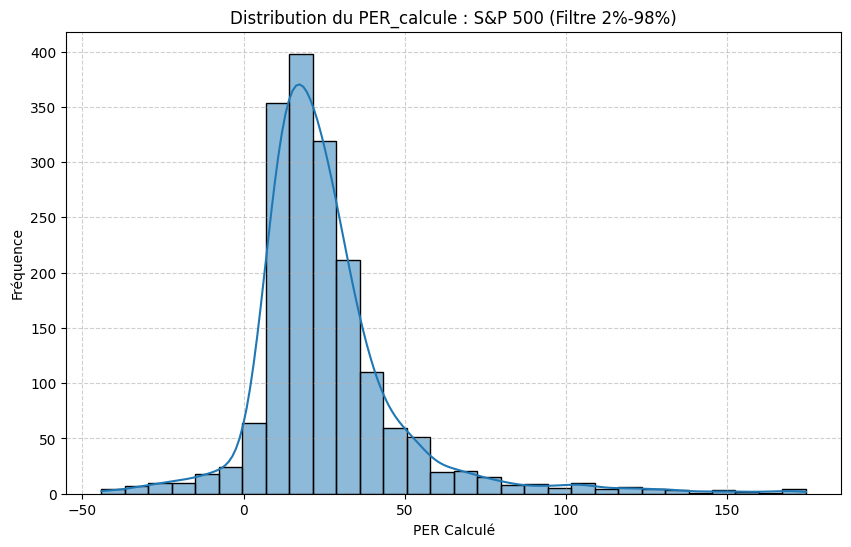

In [ ]:
# Regardons la distribution de nos PER

def afficher_distribution(df, nom_dataset):
    plt.figure(figsize=(10, 6))

    # On a observé des outliers pour améliorer la visualisation on ne garde que les données entre 2% et 98% 
    q_low = df['PER_calcule'].quantile(0.02)
    q_high = df['PER_calcule'].quantile(0.98)
    df_filtered = df[(df['PER_calcule'] > q_low) & (df['PER_calcule'] < q_high)]

    sns.histplot(df_filtered['PER_calcule'], kde=True, bins=30)
    plt.title(f'Distribution du PER_calcule : {nom_dataset} (Filtre 2%-98%)')
    plt.xlabel('PER Calculé')
    plt.ylabel('Fréquence')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

afficher_distribution(df_SP500, "S&P 500")

On remarque que la majorité des valeurs sont comprises entre 0 et 50 mais il y a tout de même des valeurs aberrantes qui compliquent l'étude. On se retreint dans le cadre de notre projet à l'analyse des PER entre 0 et 50, on va donc retirer les lignes avec un PER aberrant. 

In [ ]:
# Nombre de lignes avant nettoyage
print(f"Nombre de lignes avant nettoyage SP500 : {len(df_SP500)}")

# On ne garde que les PER entre 0 et 50
df_SP500 = df_SP500[
    (df_SP500['PER_calcule'] >= 0) & 
    (df_SP500['PER_calcule'] <= 50)
]

# Vérifions le nombre de lignes supprimées et la nouvelle distribution du PER nettoyé
print(f"Nombre de lignes après nettoyage SP500 : {len(df_SP500)}")
print("Statistiques du PER après nettoyage SP500 :")
print(df_SP500['PER_calcule'].describe())

print("-" * 30)

Nombre de lignes avant nettoyage SP500 : 1828
Nombre de lignes après nettoyage SP500 : 1509
Statistiques du PER après nettoyage SP500 :
count    1509.000000
mean       21.673465
std        10.443891
min         2.331712
25%        13.515020
50%        20.219581
75%        28.689365
max        49.714780
Name: PER_calcule, dtype: float64
------------------------------


Il nous reste 1536 lignes contre au départ 1966 soit 78% du jeu de données. Ces 78% sont significatifs et nous permettent de mener une étude sérieuse. 

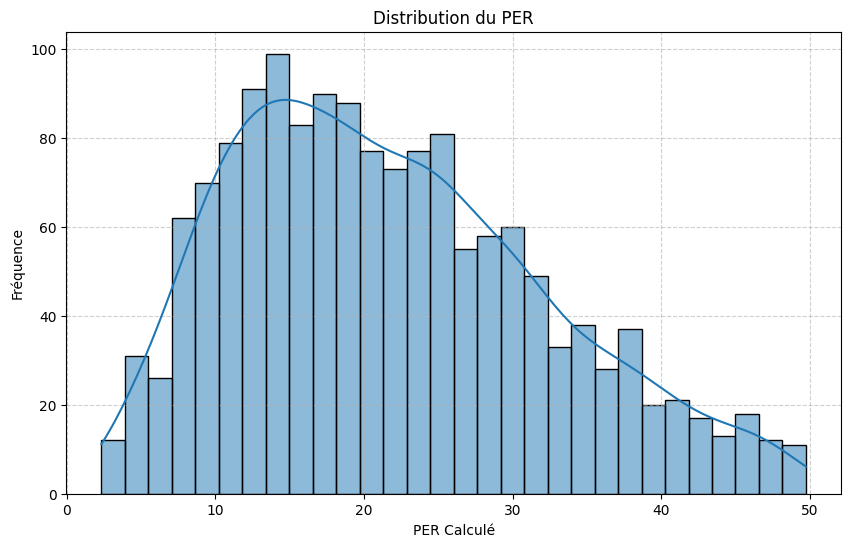

In [ ]:
# Regardons maintenant la distribution de nos PER

def afficher_distribution2(df, nom_dataset):
    plt.figure(figsize=(10, 6))

    sns.histplot(df_SP500['PER_calcule'], kde=True, bins=30)
    plt.title('Distribution du PER')
    plt.xlabel('PER Calculé')
    plt.ylabel('Fréquence')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

afficher_distribution2(df_SP500, "S&P 500")

Nous avons maintenant un data frame que nous pouvons utiliser pour mener notre étude.

In [ ]:
df_SP500.sample(10)

,Ticker,YahooTicker,Nom,Zone,AnneeFiscale,DateRapport,Sector,Industry,Country,Beta,MarketCapitalizationBN,SharesOutstandingMn,PER_calcule,ROE_calcule,ROA_calcule,DebtToEquity_calcule,EPS,EOD_Close_Price,NetIncomeBN,TotalRevenueBN,TotalEquityBN,TotalAssetsBN,TotalDebtBN,Dividendes_Annuels,Annual_Volume_Traded_BN,%MargeNette,%Gearing,%PayOut
543,DLTR,DLTR,DLTR,USA,2022,2022-01-31,Consumer Defensive,Discount Stores,United States,0.752,29.518727,224.956000,22.507719,0.172041,0.061132,0.337762,5.830000,131.220001,1.327900,26.321200,7.718500,21.721800,9.970300,0.000,0.614652,5.044983,129.174062,0.000000
553,DOW,DOW,DOW,USA,2024,2024-12-31,Basic Materials,Chemicals,United States,0.784,26.140598,700.092032,23.782677,0.064304,0.019472,0.675004,1.570000,37.338802,1.116000,42.964000,17.355000,57.312000,17.645000,2.800,1.280556,2.597524,101.670988,178.343949
1527,RF,RF,RF,USA,2022,2022-12-31,Financial Services,Banks - Regional,United States,1.049,17.511974,934.446016,8.183619,0.140779,0.014463,0.130425,2.290000,18.740488,2.245000,7.165000,15.947000,155.220000,2.284000,0.740,2.162869,31.332868,14.322443,32.314410
349,CHRW,CHRW,CHRW,USA,2022,2022-12-31,Industrials,Integrated Freight & Logistics,United States,0.906,9.854410,117.709000,11.192300,0.694923,0.157950,0.239605,7.480000,83.718407,0.940524,24.696625,1.353422,5.954564,2.361168,2.260,0.338800,3.808310,174.459112,30.213904
1556,RSG,RSG,RSG,USA,2023,2023-12-31,Industrials,Waste Management,United States,0.550,50.926707,314.636992,29.590240,0.164200,0.055110,0.256624,5.470000,161.858612,1.731000,14.965000,10.542000,31.410000,13.069000,2.060,0.307435,11.566990,123.970784,37.659963
1936,XOM,XOM,XOM,USA,2022,2022-12-31,Energy,Oil & Gas Integrated,United States,0.379,395.645337,4118.289920,7.245120,0.285774,0.151029,0.104116,13.260000,96.070297,55.740000,398.675000,195.049000,369.067000,41.193000,3.550,6.356140,13.981313,21.119308,26.772247
1410,PEP,PEP,PEP,USA,2022,2022-12-31,Consumer Defensive,Beverages - Non-Alcoholic,United States,0.421,223.875239,1377.709952,25.113343,0.519564,0.096651,0.176679,6.470588,162.498093,8.910000,86.392000,17.149000,92.187000,39.554000,4.525,1.286440,10.313455,230.649017,69.931821
441,CRL,CRL,CRL,USA,2022,2022-12-31,Healthcare,Diagnostics & Research,United States,1.635,11.111908,50.878700,22.821316,0.163366,0.063954,0.278735,9.570000,218.399994,0.486226,3.976060,2.976293,7.602770,3.097276,0.000,0.142321,12.228840,104.064889,0.000000
1816,USB,USB,USB,USA,2021,2021-12-31,Financial Services,Banks - Regional,United States,1.109,69.991826,1482.800000,9.237274,0.144998,0.013890,0.596041,5.110000,47.202473,7.963000,22.721000,54.918000,573.284000,41.718000,1.760,1.556945,35.046873,75.964165,34.442270
1376,ORLY,ORLY,ORLY,USA,2021,2021-12-31,Consumer Cyclical,Auto Parts,United States,0.616,3.172310,67.378400,22.498563,-32.589389,0.184720,1.849305,2.092667,47.082001,2.164685,13.327563,-0.066423,11.718707,5.866567,0.000,1.813053,16.242167,-8832.131942,0.000000


Enfin, on va ajouter une colonne qui calcule la croissance de l'EPS d'une année sur l'autre. Notons que les données ne seront pas disponibles pour l'année 2021 ni quand l'année précédente a été cleanée du sata set. C'est un bon indicateur mais qui sera limité dans le cadre de notre jeu de données.

In [ ]:
# Classons le Data frame par Ticker et par AnneeFiscale pour nous assurer d'avoir un calcul correct de la croissance de l'EPS year-on-year (yoy)
df_SP500 = df_SP500.sort_values(by=['Ticker', 'AnneeFiscale'])

# Calculons la croissance year-over-year de l'EPS pour chaque entreprise
df_SP500['Croissance de l\'EPS (en %)'] = df_SP500.groupby('Ticker')['EPS'].pct_change() * 100 #fonction pour calculer la croissance yoy

display(df_SP500[['Ticker', 'AnneeFiscale', 'EPS', 'Croissance de l\'EPS (en %)']].head(10))

,Ticker,AnneeFiscale,EPS,Croissance de l'EPS (en %)
3,A,2021,3.980000,NaN
2,A,2022,4.190000,5.276382
1,A,2023,4.220000,0.715990
0,A,2024,4.440000,5.213270
6,AAPL,2022,6.150000,NaN
5,AAPL,2023,6.160000,0.162602
4,AAPL,2024,6.110000,-0.811688
11,ABBV,2021,6.527034,NaN
10,ABBV,2022,6.690100,2.498317
14,ABNB,2022,2.970000,NaN


Enfin, regardons s'il y a des lignes en double. Cela serait possible notamment si une entreprise émet plusieurs classes d'actions, et donc qu'elle est trouvable sous deux tickers distincts. Pour étudier les doublons, regardons les entreprises qui ont le même NetIncome et le même EPS. (On ne peut pas regarder si elles ont le même tickers puisque tout le problème vient du fait qu'elles ont deux tickers distincts).

In [ ]:
# 2. On repère les doublons sur la combinaison (NetIncomeBN, PER)
# On passe une liste de colonnes à 'subset'
masque_doublons = df_SP500.duplicated(subset=['NetIncomeBN', 'Beta'], keep=False)

# 3. On filtre le DataFrame et on trie par les DEUX colonnes pour grouper les paires
resultat = df_SP500[masque_doublons].sort_values(by=['NetIncomeBN', 'Beta'])

print(f"Nombre de lignes concernées : {len(resultat)}")
# On affiche le résultat (on peut utiliser display() si tu es dans un notebook Jupyter)
resultat.head(30)

Nombre de lignes concernées : 18


,Ticker,YahooTicker,Nom,Zone,AnneeFiscale,DateRapport,Sector,Industry,Country,Beta,MarketCapitalizationBN,SharesOutstandingMn,PER_calcule,ROE_calcule,ROA_calcule,DebtToEquity_calcule,EPS,EOD_Close_Price,NetIncomeBN,TotalRevenueBN,TotalEquityBN,TotalAssetsBN,TotalDebtBN,Dividendes_Annuels,Annual_Volume_Traded_BN,%MargeNette,%Gearing,%PayOut,Croissance de l'EPS (en %)
1117,LUV,LUV,LUV,USA,2023,2023-12-31,Industrials,Airlines,United States,1.167,16.308778,596.115008,32.569574,0.044223,0.012744,0.564113,0.840,27.358442,0.465,26.091,10.515,36.487,9.200,0.90,1.854596,1.782224,87.494056,107.142857,-7.692308
1116,LUV,LUV,LUV,USA,2024,2024-12-31,Industrials,Airlines,United States,1.167,19.818288,599.737024,42.365338,0.044928,0.013778,0.406594,0.780,33.044964,0.465,27.483,10.350,33.750,8.058,0.72,2.245677,1.691955,77.855072,92.307692,-7.142857
1339,NWS,NWS,NWS,USA,2022,2022-06-30,Communication Services,Entertainment,United States,0.973,8.905880,577.668992,14.544269,0.075772,0.036177,0.466546,1.060,15.416925,0.623,10.385,8.222,17.221,4.155,0.20,0.183847,5.999037,50.535150,18.867925,NaN
1343,NWSA,NWSA,NWSA,USA,2022,2022-06-30,Communication Services,Entertainment,United States,0.973,8.902311,589.734976,14.240985,0.075772,0.036177,0.466733,1.060,15.095444,0.623,10.385,8.222,17.221,4.155,0.20,0.723795,5.999037,50.535150,18.867925,NaN
741,FOX,FOX,FOX,USA,2022,2022-06-30,Communication Services,Entertainment,United States,0.512,16.438313,582.601984,13.372199,0.106270,0.054316,0.469513,2.110,28.215340,1.205,13.974,11.339,22.185,7.718,0.49,0.287095,8.623157,68.065967,23.222749,NaN
745,FOXA,FOXA,FOXA,USA,2022,2022-06-30,Communication Services,Entertainment,United States,0.512,16.501853,537.979008,14.537339,0.106270,0.054316,0.467705,2.110,30.673786,1.205,13.974,11.339,22.185,7.718,0.49,0.726125,8.623157,68.065967,23.222749,NaN
740,FOX,FOX,FOX,USA,2023,2023-06-30,Communication Services,Entertainment,United States,0.512,16.106240,523.428992,13.206279,0.119387,0.056663,0.509554,2.330,30.770630,1.239,14.913,10.378,21.866,8.207,0.51,0.314051,8.308187,79.080748,21.888412,10.426540
744,FOXA,FOXA,FOXA,USA,2023,2023-06-30,Communication Services,Entertainment,United States,0.512,16.095226,489.257984,14.118977,0.119387,0.056663,0.509903,2.330,32.897217,1.239,14.913,10.378,21.866,8.207,0.51,0.915784,8.308187,79.080748,21.888412,10.426540
739,FOX,FOX,FOX,USA,2024,2024-06-30,Communication Services,Entertainment,United States,0.512,15.112616,483.540992,9.985320,0.140097,0.068314,0.539417,3.130,31.254053,1.501,13.980,10.714,21.972,8.152,0.53,0.276445,10.736767,76.087362,16.932907,34.334764
743,FOXA,FOXA,FOXA,USA,2024,2024-06-30,Communication Services,Entertainment,United States,0.512,15.135640,450.760992,10.727787,0.140097,0.068314,0.538596,3.130,33.577972,1.501,13.980,10.714,21.972,8.152,0.53,0.788613,10.736767,76.087362,16.932907,34.334764


Il faut drop les lignes 1347, 745, 744, 743, 811, 810, 812 et 809 de df_SP500. 

In [ ]:
indices_a_supprimer = [1347, 745, 744, 743, 811, 810, 812, 809]

# On supprime les lignes (axis=0 par défaut)
# errors='ignore' permet d'éviter une erreur si une de ces lignes a déjà été supprimée
df_SP500 = df_SP500.drop(indices_a_supprimer, errors='ignore')

# Vérification simple
print(f"Nouvelle taille du DataFrame : {df_SP500.shape}")

Nouvelle taille du DataFrame : (1501, 29)


In [ ]:
import os

# On sauvegarde dans le même dossier que le notebook actuel
# index=False : évite de créer une colonne pour les numéros de ligne (0, 1, 2...)
# encoding='utf-8-sig' : assure que les accents s'affichent bien (surtout pour Excel)
df_SP500.to_csv("./data/df_sp500_clean.csv", index=False, encoding='utf-8-sig')


#### Nettoyage des données EuroStoxx

Les deux csv ayant été générés par le même code de scrapping, les dataframes qui en découlent ont exactement la même structure. Il suffit donc de reprendre le code de "Nettoyage_SP500" et de l'adapter au CSV Eurostoxx_historical_fundamentals. 

In [ ]:
chemin_fichier = './data/df_eurostoxx_raw.csv'
df_STX600 = pd.read_csv(chemin_fichier)
df_STX600.head()   

,Ticker,YahooTicker,Nom,Zone,AnneeFiscale,DateRapport,Sector,Industry,Country,Beta,MarketCapitalization,SharesOutstanding,PER_calcule,ROE_calcule,ROA_calcule,DebtToEquity_calcule,EPS,EOD_Close_Price,NetIncome,TotalRevenue,TotalEquity,TotalAssets,TotalDebt,Dividendes_Annuels,Annual_Volume_Traded
0,1COV,1COV.DE,Covestro AG,Eurostoxx,2024,2024-12-31,Basic Materials,Specialty Chemicals,Germany,1.043,1.054302e+10,188740000.0,-39.617022,-0.039952,-0.019514,0.293844,-1.41,55.860001,-2.660000e+08,1.417900e+10,6.658000e+09,1.363100e+10,3.098000e+09,NaN,164471136.0
1,1COV,1COV.DE,Covestro AG,Eurostoxx,2023,2023-12-31,Basic Materials,Specialty Chemicals,Germany,1.043,9.957458e+09,190172992.0,-49.866667,-0.030046,-0.014519,0.340448,-1.05,52.360001,-1.980000e+08,1.437700e+10,6.590000e+09,1.363700e+10,3.390000e+09,NaN,275342972.0
2,1COV,1COV.DE,Covestro AG,Eurostoxx,2022,2022-12-31,Basic Materials,Specialty Chemicals,Germany,1.043,7.391832e+09,193200000.0,-26.943661,-0.038386,-0.018649,0.494600,-1.42,38.259998,-2.720000e+08,1.796800e+10,7.086000e+09,1.458500e+10,3.656000e+09,3.40,302741145.0
3,1COV,1COV.DE,Covestro AG,Eurostoxx,2021,2021-12-31,Basic Materials,Specialty Chemicals,Germany,1.043,9.833733e+09,193160992.0,6.082380,0.209979,0.103783,0.257074,8.37,50.909519,1.616000e+09,1.590300e+10,7.696000e+09,1.557100e+10,2.528000e+09,1.30,225463191.0
4,1U1,1U1.DE,1&1 DrillischAktiengesellschaft,Eurostoxx,2024,2024-12-31,Communication Services,Telecom Services,Germany,0.410,2.087824e+09,176300000.0,9.787151,0.034914,0.026170,0.197794,1.21,11.842453,2.127640e+08,4.064254e+09,6.093970e+09,8.130073e+09,4.129590e+08,0.05,13964157.0


In [ ]:
df_STX600.shape

(1989, 25)

Commençons donc par traiter les NaN.

In [ ]:
# on affiche les lignes qui contiennent au moins un NaN
df_STX600[df_STX600.isna().any(axis=1)].sample(10)

,Ticker,YahooTicker,Nom,Zone,AnneeFiscale,DateRapport,Sector,Industry,Country,Beta,MarketCapitalization,SharesOutstanding,PER_calcule,ROE_calcule,ROA_calcule,DebtToEquity_calcule,EPS,EOD_Close_Price,NetIncome,TotalRevenue,TotalEquity,TotalAssets,TotalDebt,Dividendes_Annuels,Annual_Volume_Traded
349,BTRW,BTRW.L,Barratt Redrow Plc,Eurostoxx,2022,2022-06-30,Consumer Cyclical,Residential Construction,United Kingdom,1.400,NaN,NaN,901.965236,0.091484,0.062735,NaN,0.506000,456.394409,5.151000e+08,5.267900e+09,5.630500e+09,8.210700e+09,2.544000e+08,36.900001,1.126797e+09
1834,UBI,UBI.PA,UBISoft Entertainment,Eurostoxx,2022,2022-03-31,Communication Services,Electronic Gaming & Multimedia,France,-0.377,4.904302e+09,1.227610e+08,60.530304,0.043772,0.015950,0.422119,0.660000,39.950001,7.910000e+07,2.125200e+09,1.807100e+09,4.959200e+09,2.070200e+09,NaN,1.610344e+08
1085,LI,LI.PA,Klepierre,Eurostoxx,2021,2021-12-31,Real Estate,REIT - Retail,France,0.936,4.441766e+09,2.852250e+08,8.153325,0.064809,0.025006,2.046573,1.910000,15.572850,5.447000e+08,1.250400e+09,8.404700e+09,2.178290e+10,9.090400e+09,NaN,2.807936e+08
641,ETL,ETL.PA,Eutelsat Communications,Eurostoxx,2023,2023-06-30,Technology,Communication Equipment,France,-0.348,1.485499e+09,2.486190e+08,6.052999,0.105838,0.042492,2.193742,0.987114,5.975000,3.149000e+08,1.131300e+09,2.975300e+09,7.410800e+09,3.258800e+09,NaN,1.250082e+08
1481,RYA,RYA.IR,Ryanair Holdings Plc,Eurostoxx,2023,2023-03-31,Industrials,Airlines,Ireland,1.125,1.624294e+10,1.139860e+09,12.330139,0.232819,0.080081,0.253415,1.155700,14.249942,1.313800e+09,1.077520e+10,5.643000e+09,1.640590e+10,4.116200e+09,NaN,4.211184e+08
501,DHER,DHER.DE,Delivery Hero SE,Eurostoxx,2023,2023-12-31,Consumer Cyclical,Internet Retail,Germany,1.694,6.219410e+09,2.628660e+08,-2.760793,-1.389477,-0.219064,0.907273,-8.570000,23.660000,-2.297500e+09,9.941800e+09,1.653500e+09,1.048780e+10,5.642700e+09,NaN,1.594397e+08
351,BUCN,BUCN.SW,Bucher Industries AG,Eurostoxx,2024,2024-12-31,Industrials,Specialty Industrial Machinery,Switzerland,1.060,3.260447e+09,1.025510e+07,14.353689,0.120472,0.081427,NaN,22.150000,317.934204,2.268000e+08,3.155500e+09,1.882600e+09,2.785300e+09,NaN,13.500000,3.392186e+06
1897,VENDA,VENDA.OL,Vend Marketplaces ASA - Class A Shares,Eurostoxx,2021,2021-12-31,Communication Services,Internet Content & Information,Norway,0.801,NaN,NaN,NaN,0.821366,0.644051,NaN,NaN,NaN,4.134100e+10,1.455500e+10,5.033200e+10,6.418900e+10,8.409000e+09,NaN,NaN
1458,RR.,RR.L,Rolls-Royce Holdings Plc,Eurostoxx,2022,2022-12-31,Industrials,Aerospace & Defense,United Kingdom,1.207,8.275366e+11,8.367600e+09,-650.642897,0.209752,-0.043090,0.007196,-0.152000,98.897720,-1.269000e+09,1.352000e+10,-6.050000e+09,2.945000e+10,5.955000e+09,NaN,9.647570e+09
395,CDR,CDR.WA,CD Projekt S.A.,Eurostoxx,2024,2024-12-31,Communication Services,Electronic Gaming & Multimedia,Poland,0.314,1.926253e+10,9.991050e+07,41.020829,0.167772,0.154441,NaN,4.700000,192.797897,4.698740e+08,9.850300e+08,2.800667e+09,3.042424e+09,NaN,1.000000,9.480774e+07


In [ ]:
df_STX600[df_STX600.isna().any(axis=1)].shape

(321, 25)

On remarque que dans notre dataframe, lorsqu'une entreprise n'a pas émis de dividendes pendant une année, la valeur prise par la colonne Dividendes_Annuels est NaN. Il convient de la remplacer par 0. 

In [ ]:
df_STX600['Dividendes_Annuels'] = df_STX600['Dividendes_Annuels'].fillna(0)
df_STX600.head()

,Ticker,YahooTicker,Nom,Zone,AnneeFiscale,DateRapport,Sector,Industry,Country,Beta,MarketCapitalization,SharesOutstanding,PER_calcule,ROE_calcule,ROA_calcule,DebtToEquity_calcule,EPS,EOD_Close_Price,NetIncome,TotalRevenue,TotalEquity,TotalAssets,TotalDebt,Dividendes_Annuels,Annual_Volume_Traded
0,1COV,1COV.DE,Covestro AG,Eurostoxx,2024,2024-12-31,Basic Materials,Specialty Chemicals,Germany,1.043,1.054302e+10,188740000.0,-39.617022,-0.039952,-0.019514,0.293844,-1.41,55.860001,-2.660000e+08,1.417900e+10,6.658000e+09,1.363100e+10,3.098000e+09,0.00,164471136.0
1,1COV,1COV.DE,Covestro AG,Eurostoxx,2023,2023-12-31,Basic Materials,Specialty Chemicals,Germany,1.043,9.957458e+09,190172992.0,-49.866667,-0.030046,-0.014519,0.340448,-1.05,52.360001,-1.980000e+08,1.437700e+10,6.590000e+09,1.363700e+10,3.390000e+09,0.00,275342972.0
2,1COV,1COV.DE,Covestro AG,Eurostoxx,2022,2022-12-31,Basic Materials,Specialty Chemicals,Germany,1.043,7.391832e+09,193200000.0,-26.943661,-0.038386,-0.018649,0.494600,-1.42,38.259998,-2.720000e+08,1.796800e+10,7.086000e+09,1.458500e+10,3.656000e+09,3.40,302741145.0
3,1COV,1COV.DE,Covestro AG,Eurostoxx,2021,2021-12-31,Basic Materials,Specialty Chemicals,Germany,1.043,9.833733e+09,193160992.0,6.082380,0.209979,0.103783,0.257074,8.37,50.909519,1.616000e+09,1.590300e+10,7.696000e+09,1.557100e+10,2.528000e+09,1.30,225463191.0
4,1U1,1U1.DE,1&1 DrillischAktiengesellschaft,Eurostoxx,2024,2024-12-31,Communication Services,Telecom Services,Germany,0.410,2.087824e+09,176300000.0,9.787151,0.034914,0.026170,0.197794,1.21,11.842453,2.127640e+08,4.064254e+09,6.093970e+09,8.130073e+09,4.129590e+08,0.05,13964157.0


Regardons de nouveau les lignes avec des NaN maintenant que les dividendes ont été traités.

In [ ]:
df_STX600[df_STX600.isna().any(axis=1)].head()

,Ticker,YahooTicker,Nom,Zone,AnneeFiscale,DateRapport,Sector,Industry,Country,Beta,MarketCapitalization,SharesOutstanding,PER_calcule,ROE_calcule,ROA_calcule,DebtToEquity_calcule,EPS,EOD_Close_Price,NetIncome,TotalRevenue,TotalEquity,TotalAssets,TotalDebt,Dividendes_Annuels,Annual_Volume_Traded
35,ABF,ABF.L,Associated British Foods plc,Eurostoxx,2022,2022-09-30,Consumer Defensive,Packaged Foods,United Kingdom,0.999,9.975584e+11,791673984.0,NaN,NaN,NaN,NaN,NaN,1260.062134,NaN,NaN,NaN,NaN,NaN,43.699999,330953891.0
36,ABF,ABF.L,Associated British Foods plc,Eurostoxx,2021,2021-09-30,Consumer Defensive,Packaged Foods,United Kingdom,0.999,1.470449e+12,791673984.0,NaN,NaN,NaN,NaN,NaN,1857.392700,NaN,NaN,NaN,NaN,NaN,40.500000,293842538.0
108,AHT,AHT.L,Ashtead Group plc,Eurostoxx,2021,2021-04-30,Industrials,Rental & Leasing Services,United Kingdom,1.182,2.088363e+12,449310016.0,NaN,NaN,NaN,NaN,NaN,4647.933594,NaN,NaN,NaN,NaN,NaN,42.150001,249280140.0
140,ALO,ALO.PA,Alstom,Eurostoxx,2021,2021-03-31,Industrials,Railroads,France,1.230,1.538860e+10,371199008.0,NaN,NaN,NaN,NaN,NaN,41.456478,NaN,NaN,NaN,NaN,NaN,0.235780,328202993.0
208,AUTO,AUTO.L,Auto Trader Group Plc,Eurostoxx,2021,2021-03-31,Communication Services,Internet Content & Information,United Kingdom,0.847,5.355329e+11,966545984.0,4184.809106,NaN,NaN,NaN,0.1324,554.068726,NaN,NaN,NaN,NaN,NaN,5.000000,669063275.0


In [ ]:
df_STX600[df_STX600.isna().any(axis=1)].shape

(135, 25)

On est passé de 301 lignes avec des NaN à 118. Regardons qui sont ces sociétés. 

In [ ]:
societes_avec_nan = df_STX600.loc[df_STX600.isna().any(axis=1), "Nom"].unique()
print(societes_avec_nan)
print(len(societes_avec_nan), "sociétés avec au moins un NaN")

['Associated British Foods plc' 'Ashtead Group plc' 'Alstom'
 'Auto Trader Group Plc' 'Avolta AG' 'Tritax Big Box Reit Plc'
 'B&M European Value Retail S.A.' 'Burberry Group' 'Barratt Redrow Plc'
 'Bucher Industries AG' 'Close Brothers Group plc' 'CD Projekt S.A.'
 'Chr. Hansen Holding' 'CNH Industrial NV' 'Diageo plc' 'Deutsche Post AG'
 'Elekta AB - Class B Shares' 'Siemens Energy AG' 'E. On SE'
 'Eutelsat Communications' 'Exor N.V.' 'Experian Plc' 'Easyjet plc'
 'Ferrovial S.A.' 'Ferguson Plc.' 'Forvia SE' 'Georg Fischer AG'
 'Grifols SA' 'Hays plc' 'Halma plc' 'ICG Plc' 'Infineon Technologies AG'
 'IG Group Holdings Plc' 'Investec plc' 'Johnson Matthey plc'
 'Knorr-Bremse AG' 'Kingfisher Plc' 'Land Securities Group'
 'Logitech International S.A.' 'LPP SA' 'Mercedes-Benz Group AG'
 'Michelin' nan 'Aurubis AG' 'National Grid Plc' 'Next plc.'
 'Old Mutual Limited' 'Orron Energy AB - Class A Shares'
 'Porsche Automobil Holding SE - PRF PERPETUAL EUR 1' 'Pennon Group'
 'Persimmon plc' '

On remarque que lorsqu'il y a une ligne avec un NaN, la majorité du temps il y a plusieurs NaN sur cette même ligne. On peut supposer que ce sont des entreprises qui n'étaient pas cotées cette année là ou bien que les données n'étaient pas disponible sur YahooFinance. Cela ne concerne que 103 lignes sur 1966, soit 5% du data frame. De plus, il n'est pas cohérent de remplacer ces NaN par une valeur moyenne ou médiane car nous nous intéressons aux spécificités de chaque entreprise. On fait donc le choix de supprimer ces 103 lignes.

In [ ]:
df_STX600.dropna(inplace=True)

# Vérifier qu'il n'y a plus aucun NaN
print(df_STX600.isna().sum().sum())  # doit retourner 0

# Afficher les dimensions après nettoyage
print(df_STX600.shape)

0
(1854, 25)


Maintenant que l'on a géré les NaN, pour le confort on va convertir en milliards les colonnes "NetIncome", "TotalRevenue", "TotalEquity", "TotalAssets", "TotalDebt" et "Annual_Volume_Traded".

In [ ]:
colonnes_milliards = ["NetIncome", "TotalRevenue", "TotalEquity", "TotalAssets", "TotalDebt", "Annual_Volume_Traded", "MarketCapitalization"]
colonne_millions = ['SharesOutstanding']
df_STX600[colonnes_milliards] = df_STX600[colonnes_milliards] / 1e9
df_STX600[colonne_millions] = df_STX600[colonne_millions] / 1e6

df_STX600 = df_STX600.rename(columns={
    'NetIncome': 'NetIncomeBN',
    'TotalRevenue': 'TotalRevenueBN',
    'TotalEquity': 'TotalEquityBN',
    'TotalAssets': 'TotalAssetsBN',
    'TotalDebt': 'TotalDebtBN',
    "Annual_Volume_Traded": "Annual_Volume_Traded_BN",
    "MarketCapitalization" : "MarketCapitalizationBN",
    "SharesOutstanding" : 'SharesOutstandingMn'

})

df_STX600.head()

,Ticker,YahooTicker,Nom,Zone,AnneeFiscale,DateRapport,Sector,Industry,Country,Beta,MarketCapitalizationBN,SharesOutstandingMn,PER_calcule,ROE_calcule,ROA_calcule,DebtToEquity_calcule,EPS,EOD_Close_Price,NetIncomeBN,TotalRevenueBN,TotalEquityBN,TotalAssetsBN,TotalDebtBN,Dividendes_Annuels,Annual_Volume_Traded_BN
0,1COV,1COV.DE,Covestro AG,Eurostoxx,2024,2024-12-31,Basic Materials,Specialty Chemicals,Germany,1.043,10.543017,188.740000,-39.617022,-0.039952,-0.019514,0.293844,-1.41,55.860001,-0.266000,14.179000,6.65800,13.631000,3.098000,0.00,0.164471
1,1COV,1COV.DE,Covestro AG,Eurostoxx,2023,2023-12-31,Basic Materials,Specialty Chemicals,Germany,1.043,9.957458,190.172992,-49.866667,-0.030046,-0.014519,0.340448,-1.05,52.360001,-0.198000,14.377000,6.59000,13.637000,3.390000,0.00,0.275343
2,1COV,1COV.DE,Covestro AG,Eurostoxx,2022,2022-12-31,Basic Materials,Specialty Chemicals,Germany,1.043,7.391832,193.200000,-26.943661,-0.038386,-0.018649,0.494600,-1.42,38.259998,-0.272000,17.968000,7.08600,14.585000,3.656000,3.40,0.302741
3,1COV,1COV.DE,Covestro AG,Eurostoxx,2021,2021-12-31,Basic Materials,Specialty Chemicals,Germany,1.043,9.833733,193.160992,6.082380,0.209979,0.103783,0.257074,8.37,50.909519,1.616000,15.903000,7.69600,15.571000,2.528000,1.30,0.225463
4,1U1,1U1.DE,1&1 DrillischAktiengesellschaft,Eurostoxx,2024,2024-12-31,Communication Services,Telecom Services,Germany,0.410,2.087824,176.300000,9.787151,0.034914,0.026170,0.197794,1.21,11.842453,0.212764,4.064254,6.09397,8.130073,0.412959,0.05,0.013964


Dans notre data frame, on a des entreprises de différentes nationalités, pour ne pas avoir de problème de comparaison entre les monnaies, on va s'intéresser à des ratios plutôt qu'à des valeurs bruttes.

Ajoutons d'abord une colonne correspondant à la marge nette qui est un indicateur utile de la performance des entreprises.

In [ ]:
df_STX600["%MargeNette"] = df_STX600["NetIncomeBN"] / df_STX600["TotalRevenueBN"]*100
print(df_STX600[["Nom", "NetIncomeBN", "TotalRevenueBN", "%MargeNette"]].head())

                               Nom  NetIncomeBN  TotalRevenueBN  %MargeNette
0                      Covestro AG    -0.266000       14.179000    -1.876014
1                      Covestro AG    -0.198000       14.377000    -1.377200
2                      Covestro AG    -0.272000       17.968000    -1.513802
3                      Covestro AG     1.616000       15.903000    10.161605
4  1&1 DrillischAktiengesellschaft     0.212764        4.064254     5.235007


Ajoutons maintenant le Gearing ratio qui permet d'évaluer la structure financière de l'entreprise.

In [ ]:
df_STX600["%Gearing"] = df_STX600["TotalDebtBN"] / df_STX600["TotalEquityBN"]*100
print(df_STX600[["Nom", "TotalDebtBN", "TotalEquityBN", "%Gearing"]].head())

                               Nom  TotalDebtBN  TotalEquityBN   %Gearing
0                      Covestro AG     3.098000        6.65800  46.530490
1                      Covestro AG     3.390000        6.59000  51.441578
2                      Covestro AG     3.656000        7.08600  51.594694
3                      Covestro AG     2.528000        7.69600  32.848233
4  1&1 DrillischAktiengesellschaft     0.412959        6.09397   6.776518


Ajoutons enfin le pay out ratio qui permet d'analyser la politique de redistribution de dividendes des entreprises. 

In [ ]:
df_STX600["%PayOut"] = df_STX600["Dividendes_Annuels"] / df_STX600["EPS"]*100
print(df_STX600[["Nom", "Dividendes_Annuels", "EPS", "%PayOut"]].head())

                               Nom  Dividendes_Annuels   EPS     %PayOut
0                      Covestro AG                0.00 -1.41   -0.000000
1                      Covestro AG                0.00 -1.05   -0.000000
2                      Covestro AG                3.40 -1.42 -239.436620
3                      Covestro AG                1.30  8.37   15.531661
4  1&1 DrillischAktiengesellschaft                0.05  1.21    4.132231


In [ ]:
# Liste du nom des colonnes
print(df_STX600.columns.tolist())

['Ticker', 'YahooTicker', 'Nom', 'Zone', 'AnneeFiscale', 'DateRapport', 'Sector', 'Industry', 'Country', 'Beta', 'MarketCapitalizationBN', 'SharesOutstandingMn', 'PER_calcule', 'ROE_calcule', 'ROA_calcule', 'DebtToEquity_calcule', 'EPS', 'EOD_Close_Price', 'NetIncomeBN', 'TotalRevenueBN', 'TotalEquityBN', 'TotalAssetsBN', 'TotalDebtBN', 'Dividendes_Annuels', 'Annual_Volume_Traded_BN', '%MargeNette', '%Gearing', '%PayOut']


Regardons maintenant si nous avons dans notre df des valeurs aberrantes. En général, un PER prend des valeurs entre 0 et 50. 
Un PER de x signifie que pour acheter une action, l'actionnaire paye x fois le bénéfice attribuable à son action. Ainsi, on comprend que les PER négatif ne sont pas significatifs et sont dus à un bénéfice négatif. Un PER trop élevé est du à un résultat net proche de 0 et donc un ratio PER = Valeur des capitaux propres / Résultat Net égal à l'infini. De tels PER ne sont pas non plus significatifs. 

In [ ]:
df_STX600['PER_calcule'].describe()

count    1.854000e+03
mean     1.708808e+03
std      6.842584e+04
min     -3.827681e+05
25%      7.959061e+00
50%      1.734182e+01
75%      4.359850e+01
max      2.909207e+06
Name: PER_calcule, dtype: float64

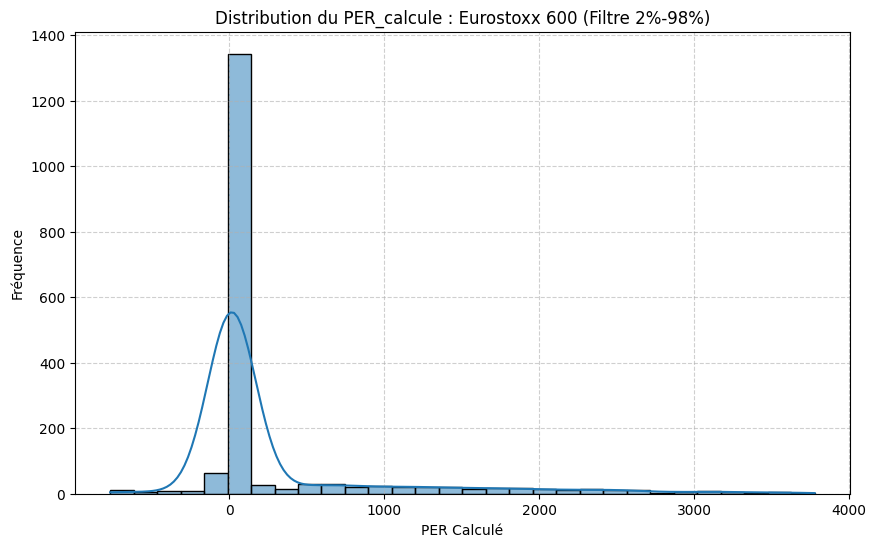

In [ ]:
# Regardons la distribution de nos PER

def afficher_distribution(df, nom_dataset):
    plt.figure(figsize=(10, 6))

    # On a observé des outliers pour améliorer la visualisation on ne garde que les données entre 2% et 98% 
    q_low = df['PER_calcule'].quantile(0.02)
    q_high = df['PER_calcule'].quantile(0.98)
    df_filtered = df[(df['PER_calcule'] > q_low) & (df['PER_calcule'] < q_high)]

    sns.histplot(df_filtered['PER_calcule'], kde=True, bins=30)
    plt.title(f'Distribution du PER_calcule : {nom_dataset} (Filtre 2%-98%)')
    plt.xlabel('PER Calculé')
    plt.ylabel('Fréquence')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

afficher_distribution(df_STX600, "Eurostoxx 600")

On remarque que la majorité des valeurs sont comprises entre 0 et 50 mais il y a tout de même des valeurs aberrantes qui compliquent l'étude. On se retreint dans le cadre de notre projet à l'analyse des PER entre 0 et 50, on va donc retirer les lignes avec un PER aberrant. 

In [ ]:
# Nombre de lignes avant nettoyage
print(f"Nombre de lignes avant nettoyage Eurostoxx 600 : {len(df_STX600)}")

# On ne garde que les PER entre 0 et 50
df_STX600 = df_STX600[
    (df_STX600['PER_calcule'] >= 0) & 
    (df_STX600['PER_calcule'] <= 50)
]

# Vérifions le nombre de lignes supprimées et la nouvelle distribution du PER nettoyé
print(f"Nombre de lignes après nettoyage Eurostoxx 600 : {len(df_STX600)}")
print("Statistiques du PER après nettoyage Eurostoxx 600 :")
print(df_STX600['PER_calcule'].describe())

print("-" * 30)

Nombre de lignes avant nettoyage Eurostoxx 600 : 1854
Nombre de lignes après nettoyage Eurostoxx 600 : 1208
Statistiques du PER après nettoyage Eurostoxx 600 :
count    1208.000000
mean       16.824231
std        10.309515
min         0.015429
25%         8.754390
50%        14.828194
75%        23.122656
max        49.929574
Name: PER_calcule, dtype: float64
------------------------------


Il nous reste 1223 lignes contre au départ 1994 soit 61% du jeu de données. Ces 61% sont significatifs et nous permettent de mener une étude sérieuse. 

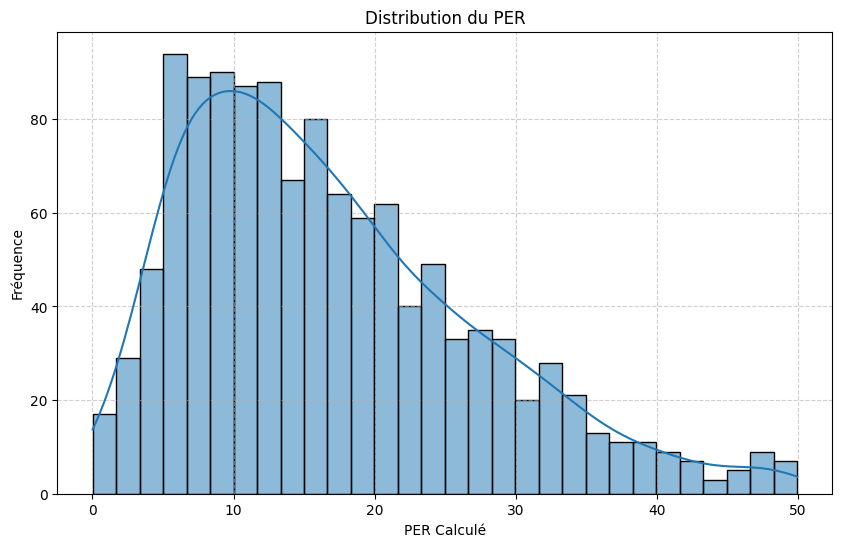

In [ ]:
# Regardons maintenant la distribution de nos PER

def afficher_distribution2(df, nom_dataset):
    plt.figure(figsize=(10, 6))

    sns.histplot(df_STX600['PER_calcule'], kde=True, bins=30)
    plt.title('Distribution du PER')
    plt.xlabel('PER Calculé')
    plt.ylabel('Fréquence')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

afficher_distribution2(df_STX600, "Eurostoxx 600")

Nous avons maintenant un data frame que nous pouvons utiliser pour mener notre étude.

In [ ]:
df_STX600.head()

,Ticker,YahooTicker,Nom,Zone,AnneeFiscale,DateRapport,Sector,Industry,Country,Beta,MarketCapitalizationBN,SharesOutstandingMn,PER_calcule,ROE_calcule,ROA_calcule,DebtToEquity_calcule,EPS,EOD_Close_Price,NetIncomeBN,TotalRevenueBN,TotalEquityBN,TotalAssetsBN,TotalDebtBN,Dividendes_Annuels,Annual_Volume_Traded_BN,%MargeNette,%Gearing,%PayOut
3,1COV,1COV.DE,Covestro AG,Eurostoxx,2021,2021-12-31,Basic Materials,Specialty Chemicals,Germany,1.043,9.833733,193.160992,6.082380,0.209979,0.103783,0.257074,8.37,50.909519,1.616000,15.903000,7.696000,15.571000,2.528000,1.30,0.225463,10.161605,32.848233,15.531661
4,1U1,1U1.DE,1&1 DrillischAktiengesellschaft,Eurostoxx,2024,2024-12-31,Communication Services,Telecom Services,Germany,0.410,2.087824,176.300000,9.787151,0.034914,0.026170,0.197794,1.21,11.842453,0.212764,4.064254,6.093970,8.130073,0.412959,0.05,0.013964,5.235007,6.776518,4.132231
5,1U1,1U1.DE,1&1 DrillischAktiengesellschaft,Eurostoxx,2023,2023-12-31,Communication Services,Telecom Services,Germany,0.410,3.210441,176.300000,10.173240,0.053499,0.040690,0.058717,1.79,18.210100,0.314950,4.096701,5.887074,7.740306,0.188507,0.05,0.024756,7.687893,3.202049,2.793296
6,1U1,1U1.DE,1&1 DrillischAktiengesellschaft,Eurostoxx,2022,2022-12-31,Communication Services,Telecom Services,Germany,0.410,2.038735,176.300000,5.559619,0.065831,0.050616,0.050359,2.08,11.564008,0.367328,3.963691,5.579841,7.257085,0.102669,0.05,0.016834,9.267322,1.839999,2.403846
7,1U1,1U1.DE,1&1 DrillischAktiengesellschaft,Eurostoxx,2021,2021-12-31,Communication Services,Telecom Services,Germany,0.410,4.217032,176.764992,11.360339,0.070896,0.052383,0.024255,2.10,23.856712,0.370022,3.909659,5.219201,7.063730,0.102285,0.05,0.035485,9.464304,1.959783,2.380952


In [ ]:
# Sort the DataFrame by Ticker and AnneeFiscale to ensure correct year-over-year calculation
df_STX600 = df_STX600.sort_values(by=['Ticker', 'AnneeFiscale'])

# Calculate the year-over-year EPS growth for each company
df_STX600['Croissance de l\'EPS (en %)'] = df_STX600.groupby('Ticker')['EPS'].pct_change() * 100 #fonction pour calculer la xce yoy

# Display the relevant columns to show the new calculation
display(df_STX600[['Ticker', 'AnneeFiscale', 'EPS', 'Croissance de l\'EPS (en %)']].head(10))

,Ticker,AnneeFiscale,EPS,Croissance de l'EPS (en %)
3,1COV,2021,8.370000,NaN
7,1U1,2021,2.100000,NaN
6,1U1,2022,2.080000,-0.952381
5,1U1,2023,1.790000,-13.942308
4,1U1,2024,1.210000,-32.402235
11,A2A,2021,0.163900,NaN
10,A2A,2022,0.128100,-21.842587
9,A2A,2023,0.210100,64.012490
8,A2A,2024,0.275782,31.262256
15,AAK,2021,5.590000,NaN


Enfin, regardons s'il y a des lignes en double. Cela serait possible notamment si une entreprise émet plusieurs classes d'actions, et donc qu'elle est trouvable sous deux tickers distincts. Pour étudier les doublons, regardons les entreprises qui ont le même NetIncome et le même EPS. (On ne peut pas regarder si elles ont le même tickers puisque tout le problème vient du fait qu'elles ont deux tickers distincts).

In [ ]:
# 2. On repère les doublons sur la combinaison (NetIncomeBN, PER)
# On passe une liste de colonnes à 'subset'
masque_doublons = df_STX600.duplicated(subset=['NetIncomeBN', 'Beta'], keep=False)

# 3. On filtre le DataFrame et on trie par les DEUX colonnes pour grouper les paires
resultat = df_STX600[masque_doublons].sort_values(by=['NetIncomeBN', 'Beta'])

print(f"Nombre de lignes concernées : {len(resultat)}")
# On affiche le résultat (on peut utiliser display() si tu es dans un notebook Jupyter)
resultat.head(30)

Nombre de lignes concernées : 2


,Ticker,YahooTicker,Nom,Zone,AnneeFiscale,DateRapport,Sector,Industry,Country,Beta,MarketCapitalizationBN,SharesOutstandingMn,PER_calcule,ROE_calcule,ROA_calcule,DebtToEquity_calcule,EPS,EOD_Close_Price,NetIncomeBN,TotalRevenueBN,TotalEquityBN,TotalAssetsBN,TotalDebtBN,Dividendes_Annuels,Annual_Volume_Traded_BN,%MargeNette,%Gearing,%PayOut,Croissance de l'EPS (en %)
1363,PST,PST.MI,Poste Italiane S.p.a,Eurostoxx,2021,2021-12-31,Industrials,Conglomerates,Italy,0.718,11.657422,1300.880000,7.381533,0.130392,0.005542,1.439169,1.214,8.961182,1.578,31.639,12.102,284.728,16.777,0.509,0.675927,4.987515,138.629979,41.927512,NaN
1362,PST,PST.MI,Poste Italiane S.p.a,Eurostoxx,2022,2022-12-31,Industrials,Conglomerates,Italy,0.718,9.823480,1298.279936,6.232730,0.201430,0.006021,1.364690,1.214,7.566535,1.578,18.280,7.834,262.074,13.406,0.615,0.659369,8.632385,171.125862,50.658979,0.0


En explorant les données, on a trouvé une valeur aberrante qu'on supprime.

In [ ]:
# 1. Filtrer le DataFrame pour ne garder que le secteur 'Utilities'
utilities_df_STX600 = df_STX600[df_STX600['Sector'] == 'Utilities']

# 2. Trouver la ligne avec la valeur maximale dans la colonne '%MargeNette'
# Utilisation de idxmax() pour récupérer l'index de la valeur max
index_max = utilities_df_STX600['%MargeNette'].idxmax()
ligne_max = df_STX600.loc[index_max]

# Suppression de la ligne en utilisant l'index trouvé
df_STX600 = df_STX600.drop(index_max)

# Vérification : afficher la taille du df pour confirmer la suppression
print(f"Ligne supprimée. Nouvelle taille du df : {df_STX600.shape}")

Ligne supprimée. Nouvelle taille du df : (1207, 29)


On n'a pas ici de problème d'entreprise qui a deux classes d'actions.

In [ ]:
# On filtre, on trie par ordre décroissant (ascending=False), et on prend les 5 premières valorisations boursières du STX600 en 2024
top_10_equity_STX600 = df_STX600[df_STX600['AnneeFiscale'] == 2024].sort_values(by='MarketCapitalizationBN', ascending=False).head(10)
top_10_equity_STX600.head(5)

,Ticker,YahooTicker,Nom,Zone,AnneeFiscale,DateRapport,Sector,Industry,Country,Beta,MarketCapitalizationBN,SharesOutstandingMn,PER_calcule,ROE_calcule,ROA_calcule,DebtToEquity_calcule,EPS,EOD_Close_Price,NetIncomeBN,TotalRevenueBN,TotalEquityBN,TotalAssetsBN,TotalDebtBN,Dividendes_Annuels,Annual_Volume_Traded_BN,%MargeNette,%Gearing,%PayOut,Croissance de l'EPS (en %)
201,ATO,ATO.PA,Atos SE,Eurostoxx,2024,2024-12-31,Technology,Information Technology Services,France,1.643,5027.334095,193359.003648,0.076471,0.310388,0.030075,0.000559,340.00,26.000000,0.248,9.577,0.799,8.246,2.811,0.0,0.014822,2.589537,351.814768,0.000000,NaN
971,INVE B,INVE-B.ST,Investor AB - Class B Shares,Eurostoxx,2024,2024-12-31,Financial Services,Asset Management,Sweden,0.787,889.903012,3060.770048,7.857968,0.138324,0.119041,0.111177,37.00,290.744812,113.338,168.909,819.364,952.090,98.937,4.8,0.610232,67.100036,12.074853,12.972973,-10.800386
193,ATCO A,ATCO-A.ST,Atlas Copco AB - Class A Shares,Eurostoxx,2024,2024-12-31,Industrials,Specialty Industrial Machinery,Sweden,0.937,790.494816,4695.719936,27.552159,0.261935,0.142813,0.043907,6.11,168.343689,29.782,176.771,113.700,208.538,34.708,2.8,0.941863,16.847786,30.525945,45.826514,6.076389
1926,VOLV B,VOLV-B.ST,Volvo AB - Class B Shares,Eurostoxx,2024,2024-12-31,Industrials,Farm & Heavy Construction Machinery,Sweden,0.880,514.547621,2036.099968,10.198239,0.259673,0.070517,0.503065,24.78,252.712357,50.389,526.816,194.048,714.564,258.851,18.0,0.743307,9.564820,133.395345,72.639225,1.142857
185,ASSA B,ASSA-B.ST,Assa Abloy AB - Class B Shares,Eurostoxx,2024,2024-12-31,Industrials,Security & Protection Services,Sweden,0.828,357.329611,1110.780032,22.847479,0.146062,0.069940,0.205695,14.08,321.692505,15.639,150.162,107.071,223.605,73.501,5.4,0.357249,10.414752,68.646973,38.352273,14.751426


In [ ]:
# Sélectionner toutes les lignes où la colonne YahooTicker est égale à 'ATO.PA'
lignes_ato = df_STX600[df_STX600['YahooTicker'] == 'ATO.PA']

# Afficher le résultat
lignes_ato

,Ticker,YahooTicker,Nom,Zone,AnneeFiscale,DateRapport,Sector,Industry,Country,Beta,MarketCapitalizationBN,SharesOutstandingMn,PER_calcule,ROE_calcule,ROA_calcule,DebtToEquity_calcule,EPS,EOD_Close_Price,NetIncomeBN,TotalRevenueBN,TotalEquityBN,TotalAssetsBN,TotalDebtBN,Dividendes_Annuels,Annual_Volume_Traded_BN,%MargeNette,%Gearing,%PayOut,Croissance de l'EPS (en %)
201,ATO,ATO.PA,Atos SE,Eurostoxx,2024,2024-12-31,Technology,Information Technology Services,France,1.643,5027.334095,193359.003648,0.076471,0.310388,0.030075,0.000559,340.0,26.0,0.248,9.577,0.799,8.246,2.811,0.0,0.014822,2.589537,351.814768,0.0,NaN


On remarque un problème avec Atos. On n'a que 2024 pour Atos, on drop cette année. 

In [ ]:
# On drop Atos
df_STX600= df_STX600[df_STX600['YahooTicker'] != 'ATO.PA']

In [ ]:
import os

# On sauvegarde dans le même dossier que le notebook actuel
# index=False : évite de créer une colonne pour les numéros de ligne (0, 1, 2...)
# encoding='utf-8-sig' : assure que les accents s'affichent bien (surtout pour Excel)
df_STX600.to_csv("./data/df_eurostoxx_clean.csv", index=False, encoding='utf-8-sig')

print("Fichier CSV sauvegardé avec succès !")

Fichier CSV sauvegardé avec succès !


## Section 2 : Données Damodaran

Après réflexion et premières tentatives de modélisation en utilisant uniquement les données financières des entreprises, nous avons décidé d'enrichir notre analyse en utilisant des données macro-économiques : *default spread, equity risk premium, country risk premium, corporate task et Moody's rating*. 

Ces données se trouvent sur le site du professeur Damodaran, que nous allons scrapper.

(Source : https://pages.stern.nyu.edu/~adamodar/New_Home_Page/datafile/ctryprem.html)

In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

In [ ]:
url = "https://pages.stern.nyu.edu/~adamodar/New_Home_Page/datafile/ctryprem.html"

On effectue notre tentative de scrapping. L'objectif est de reproduire le tableau disponible sur le site :

In [ ]:
try:
    # On télécharge les informations du site
    response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
    response.raise_for_status()

    # On identifie la table
    soup = BeautifulSoup(response.text, 'html.parser')
    table = soup.find('table', {'width': '919'})

    # On récupère toutes les lignes de la table
    trs = table.find_all('tr')

    # On trouve la ligne correspondant au 'Country'
    header_row = None
    for tr in trs:
        tds = tr.find_all('td')
        if tds and 'Country' in tds[0].get_text():
            header_row = tr
            break

    # On extrait les headers
    headers = [td.get_text(strip=True) for td in header_row.find_all('td')]

    # On garde uniquement les lignes avec des données :
    rows = []
    for tr in table.find_all('tr'):
        tds = tr.find_all('td')
        if len(tds) == 6 and tr != header_row:
            row = [td.get_text(strip=True).replace('\xa0','').replace('\n',' ').strip() for td in tds]
            rows.append(row)

except Exception as e:
    print("Erreur lors du scraping :", e)

# On créé notre dataframe
df_damodaran = pd.DataFrame(rows, columns=headers)


On observe un échantillon du dataframe obtenu :

In [ ]:
print (df_damodaran.head())

                                   Country Adj. Default\n              Spread  \
0                                Abu Dhabi                              0.49%   
1                                  Albania                              3.56%   
2                                  Algeria                              2.98%   
3  Andorra               (Principality of)                              1.58%   
4                                   Angola                              6.44%   

  Equity Risk\n              Premium Country Risk\n              Premium  \
0                              4.99%                               0.66%   
1                              9.13%                               4.80%   
2                              8.35%                               4.02%   
3                              6.46%                               2.13%   
4                             13.01%                               8.68%   

  Corporate Tax\n              Rate Moody's rating  
0  

On constate qu'il y a du ménage à faire : il faut nettoyer les noms de colonnes, définir les colonnes numériques et les convertir, définir les colonnes de texte et supprimer les lignes vides.

In [ ]:
# Nettoyage des noms de colonnes
df_damodaran.columns = (
    df_damodaran.columns
    .str.replace('\n', ' ', regex=False)
    .str.replace(r'\s+', ' ', regex=True)
    .str.strip()
)

# Définition des colonnes numériques
numeric_cols = [
    'Adj. Default Spread',
    'Equity Risk Premium',
    'Country Risk Premium',
    'Corporate Tax Rate',
]

# Conversion de ces colonnes en numérique
for col in numeric_cols:
    df_damodaran[col] = (
        df_damodaran[col]
        .astype(str)
        .str.replace('%', '', regex=False)
        .str.replace(',', '', regex=False)
        .str.replace(r'\s+', ' ', regex=True)
        .str.strip()
    )
    df_damodaran[col] = pd.to_numeric(df_damodaran[col], errors='coerce')

# Définition des colonnes de texte
df_damodaran['Country'] = df_damodaran['Country'].astype(str).str.strip()

# Suppression des lignes vides
df_damodaran = df_damodaran.dropna(how='all')

On vérifie le résultat obtenu :

In [ ]:
print(df_damodaran.head())
print(df_damodaran.columns.tolist())

                                   Country  Adj. Default Spread  \
0                                Abu Dhabi                 0.49   
1                                  Albania                 3.56   
2                                  Algeria                 2.98   
3  Andorra               (Principality of)                 1.58   
4                                   Angola                 6.44   

   Equity Risk Premium  Country Risk Premium  Corporate Tax Rate  \
0                 4.99                  0.66               15.00   
1                 9.13                  4.80               15.00   
2                 8.35                  4.02               15.00   
3                 6.46                  2.13               18.98   
4                13.01                  8.68               25.00   

  Moody's rating  
0            Aa2  
1            Ba3  
2             NR  
3           Baa1  
4             B3  
['Country', 'Adj. Default Spread', 'Equity Risk Premium', 'Country Risk Pr

Pour gagner du temps dans nos analyses futures, on va uniformiser le nom des pays et utiliser la colonne 'country' pour indexer et faciliter la jointure.

In [ ]:

df_damodaran['Country'] = df_damodaran['Country'].str.strip()
df_damodaran['Country'] = df_damodaran['Country'].str.replace('\s+', ' ', regex=True) 

df_damodaran.set_index('Country', inplace=True) 

Par mesure de précaution, on sauvegarde ces données dans notre dossier data :

In [ ]:
df_damodaran.to_csv("data/country_risk_premiums.csv")

Le dataframe s'affiche parfaitement :

In [ ]:
df_test = pd.read_csv("data/country_risk_premiums.csv")
df_test.sample(20)   

,Country,Adj. Default Spread,Equity Risk Premium,Country Risk Premium,Corporate Tax Rate,Moody's rating
174,Thailand,1.58,6.46,2.13,20.00,Baa1
55,Falkland Islands,3.58,9.15,4.82,31.55,NR
191,Zimbabwe,8.92,16.35,12.02,35.00,NR
164,St. Vincent & the Grenadines,6.44,13.01,8.68,28.53,B3
145,Romania,2.18,7.26,2.93,16.00,Baa3
25,Brazil,2.48,7.67,3.34,34.00,Ba1
98,Lebanon,17.50,27.92,23.59,17.00,C
17,Belarus,17.50,27.92,23.59,18.00,C
125,Netherlands,0.00,4.33,0.00,25.80,Aaa
41,Cook Islands,4.46,10.34,6.01,29.74,B1


# Partie 2 : Analyse exploratoire des données

L'analyse préliminaire du *dataset* doit nous permettre de répondre à la question fondamentale : existe-il un *premium* américain ?

Commençons par charger nos deux *dataframes* financiers. On se contentera de 2024 pour éviter les biais de réplication.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
chemin_fichier_stx = 'data/df_eurostoxx_clean.csv'
df_STX600 = pd.read_csv(chemin_fichier_stx)

chemin_fichier_sp = 'data/df_sp500_clean.csv'
df_SP500 = pd.read_csv(chemin_fichier_sp)

df_sp500_24 = df_SP500[df_SP500['AnneeFiscale'] == 2024].copy()
df_stx600_24 = df_STX600[df_STX600['AnneeFiscale'] == 2024].copy()

df_sp500_24['ZoneLabel'] = 'USA (S&P 500)'
df_stx600_24['ZoneLabel'] = 'Europe (Eurostoxx)'

df_viz = pd.concat([df_sp500_24, df_stx600_24], ignore_index=True)

df_viz_per = df_viz[(df_viz['PER_calcule'] > 0) & (df_viz['PER_calcule'] < 100)]

Pour les graphiques de PER, on filtre les valeurs extrêmes <0 ou >100. 

Commençons par observer la distribution globale des PER :

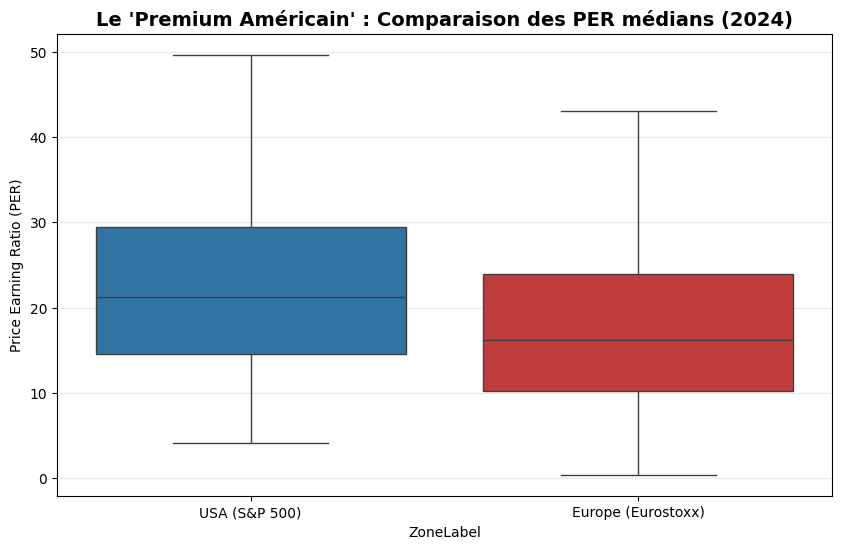

CONSTATS :
> PER Médian USA : 21.3x
> PER Médian Europe : 16.2x
> Écart de valorisation brut : +5.1 points, c'est à dire +31.4%.


In [3]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='ZoneLabel', y='PER_calcule', hue='ZoneLabel', data=df_viz_per,
            palette=['#1f77b4', '#d62728'], showfliers=False, legend=False)

plt.title("Le 'Premium Américain' : Comparaison des PER médians (2024)", fontsize=14, fontweight='bold')
plt.ylabel("Price Earning Ratio (PER)")
plt.grid(axis='y', alpha=0.3)
plt.show()

per_med_us = df_viz_per[df_viz_per['ZoneLabel'].str.contains('USA')]['PER_calcule'].median()
per_med_eu = df_viz_per[df_viz_per['ZoneLabel'].str.contains('Europe')]['PER_calcule'].median()
print(f"CONSTATS :\n> PER Médian USA : {per_med_us:.1f}x\n> PER Médian Europe : {per_med_eu:.1f}x")
print(f"> Écart de valorisation brut : +{(per_med_us - per_med_eu):.1f} points, c'est à dire +{(per_med_us / per_med_eu -1)*100:.1f}%.")

**Analyses :**
- Les données confirment l'existence d'un *premium américain* de plus de 5 points. 
- L'écart interquartile traduit une dispersion plus forte aux USA : le marché américain semble tolérer des valorisation extrêmes pour ses champions.

Pour affiner l'analyse, on peut également s'intéresser aux dynamiques pour les plus grandes capitalisations de chaque continent :

In [4]:
per_moy_us = df_viz_per[df_viz_per['ZoneLabel'].str.contains('USA')].nlargest(10, 'MarketCapitalizationBN')['PER_calcule'].mean()
per_moy_eu = df_viz_per[df_viz_per['ZoneLabel'].str.contains('Europe')].nlargest(20, 'MarketCapitalizationBN')['PER_calcule'].mean()
print(f"FOCUS au Sommet :\n> PER moyen du Top20 USA : {per_moy_us:.1f}x\n> PER moyen du Top20 Europe : {per_moy_eu:.1f}x")
print(f"> Écart de valorisation brut : +{(per_moy_us - per_moy_eu):.1f} points, c'est à dire +{(per_moy_us / per_moy_eu -1)*100:.1f}%.")

FOCUS au Sommet :
> PER moyen du Top20 USA : 26.3x
> PER moyen du Top20 Europe : 17.9x
> Écart de valorisation brut : +8.5 points, c'est à dire +47.5%.


Il est intéressant de remarquer que le PER moyen des 20 plus grosses capitalisations européennes est aussi le PER médian de la zone, ce qui traduit une certaine homogénéité des valorisations.

En revanche, on observe un phénomène très différent aux États-Unis : les PER des 20 plus grosses capitalisations sont significativement plus élevés que ceux du reste de l'indice.

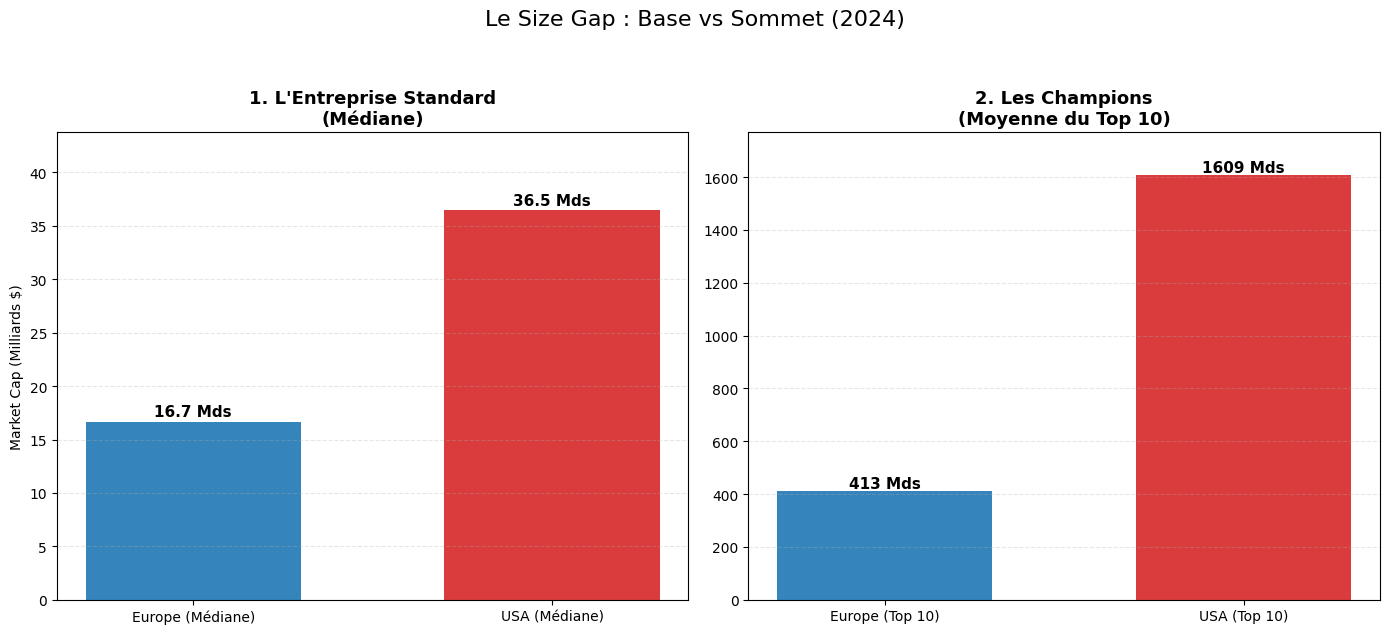

--- Analyse des Écarts ---
L'entreprise médiane US est 2.19x plus grosse (+119%)
Le Top 10 US est 3.89x plus gros (+289%)


In [5]:

med_us = df_viz[df_viz['Zone']=='USA']['MarketCapitalizationBN'].median()
med_eu = df_viz[df_viz['Zone']=='Eurostoxx']['MarketCapitalizationBN'].median()

# Top 20 Moyens
top20_us = df_viz[df_viz['Zone']=='USA'].nlargest(10, 'MarketCapitalizationBN')['MarketCapitalizationBN'].mean()
top20_eu = df_viz[df_viz['Zone']=='Eurostoxx'].nlargest(10, 'MarketCapitalizationBN')['MarketCapitalizationBN'].mean()

# 3. Création du Graphique "Split-Scale"
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# --- Graphique de Gauche : Le "Ventre Mou" (Médiane) ---
labels_med = ['Europe (Médiane)', 'USA (Médiane)']
values_med = [med_eu, med_us]
colors = ['#1f77b4', '#d62728']

ax1.bar(labels_med, values_med, color=colors, alpha=0.9, width=0.6)
ax1.set_ylabel('Market Cap (Milliards $)')
ax1.set_title('1. L\'Entreprise Standard\n(Médiane)', fontsize=13, fontweight='bold')
ax1.grid(axis='y', linestyle='--', alpha=0.3)
ax1.set_ylim(0, max(values_med) * 1.2) # Marge pour le texte

# Annotations Gauche
for i, v in enumerate(values_med):
    ax1.text(i, v + 0.5, f"{v:.1f} Mds", ha='center', fontweight='bold', fontsize=11)

# --- Graphique de Droite : Les "Champions" (Top 10) ---
labels_top = ['Europe (Top 10)', 'USA (Top 10)']
values_top = [top20_eu, top20_us]

ax2.bar(labels_top, values_top, color=colors, alpha=0.9, width=0.6)
ax2.set_title('2. Les Champions\n(Moyenne du Top 10)', fontsize=13, fontweight='bold')
ax2.grid(axis='y', linestyle='--', alpha=0.3)
ax2.set_ylim(0, max(values_top) * 1.1) # Marge

# Annotations Droite
for i, v in enumerate(values_top):
    ax2.text(i, v + 10, f"{v:.0f} Mds", ha='center', fontweight='bold', fontsize=11)

# Titre Global
plt.suptitle('Le Size Gap : Base vs Sommet (2024)', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

# 4. Le Ratio pour le texte
ratio_med = med_us / med_eu
ratio_top = top20_us / top20_eu

print(f"--- Analyse des Écarts ---")
print(f"L'entreprise médiane US est {ratio_med:.2f}x plus grosse (+{(ratio_med-1)*100:.0f}%)")
print(f"Le Top 10 US est {ratio_top:.2f}x plus gros (+{(ratio_top-1)*100:.0f}%)")

Quand on pense aux grandes entreprises américaines très bien valorisées, on pense immédiatement aux géants de la tech. On peut donc légitimement se demander si l'écart de valorisation n'est pas qu'un effet de composition. Autrement dit, le *premium américain* serait le résultat mécanique d'une double dynamique :
1. Les entreprises technologiques sont mieux valorisées que celles évoluant dans d'autres secteurs
2. Il y a plus d'entreprises technologiques aux USA qu'en Europe

Pour vérifier ces hypothèses, commençons par regarder la composition sectorielle des indices pondérée par la *Market Cap*.

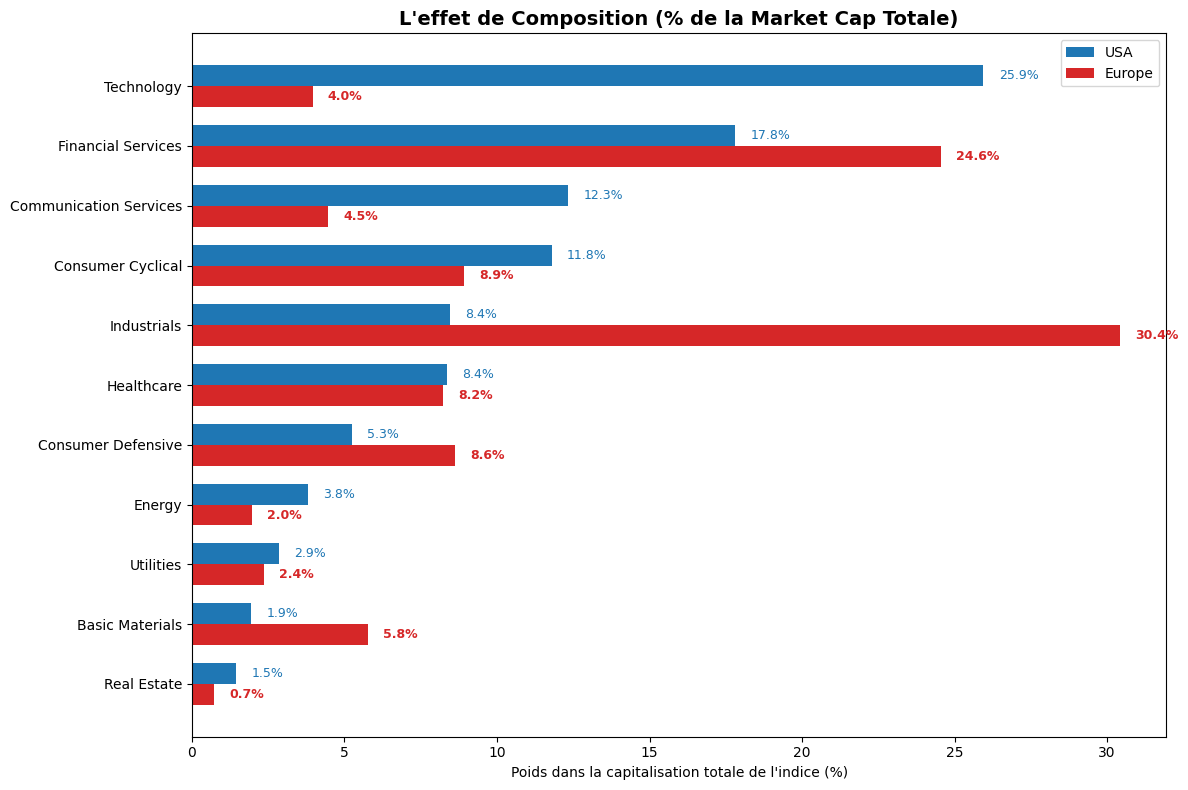

In [6]:
sector_mcap = df_viz.groupby(['ZoneLabel', 'Sector'])['MarketCapitalizationBN'].sum().unstack(fill_value=0)
sector_pct_mcap = sector_mcap.div(sector_mcap.sum(axis=1), axis=0) * 100
sector_pct_mcap = sector_pct_mcap.T.sort_values(by='USA (S&P 500)', ascending=True)

plt.figure(figsize=(12, 8))
y = np.arange(len(sector_pct_mcap))
height = 0.35

plt.barh(y + height/2, sector_pct_mcap['USA (S&P 500)'], height, label='USA', color='#1f77b4')
plt.barh(y - height/2, sector_pct_mcap['Europe (Eurostoxx)'], height, label='Europe', color='#d62728')

for i, v in enumerate(sector_pct_mcap['USA (S&P 500)']):
    plt.text(v + 0.5, i + height/2, f"{v:.1f}%", va='center', fontsize=9, color='#1f77b4')

for i, v in enumerate(sector_pct_mcap['Europe (Eurostoxx)']):
    plt.text(v + 0.5, i - height/2, f"{v:.1f}%", va='center', fontsize=9, color='#d62728', fontweight='bold')

plt.yticks(y, sector_pct_mcap.index)
plt.title("L'effet de Composition (% de la Market Cap Totale)", fontsize=14, fontweight='bold')
plt.xlabel("Poids dans la capitalisation totale de l'indice (%)")
plt.legend()
plt.tight_layout()
plt.show()

Sans surprise, le S&P500 est dominé par le secteur technologique (26%). À l'inverse, l'Europe est dominée par la *old economy*, symbolisée par les 30% occupés par l'industrie. L'Europe souffre d'un déficit de champions technologiques de taille mondiale.

Certes, les entreprises technologiques ont généralement des PER très élevés, reflétant les anticipations de croissance future. Peut-on pour autant conclure que le *premium américain* ne serait qu'un effet de composition ? Rien n'est moins sûr : étudions la distribution des PER par secteur. 

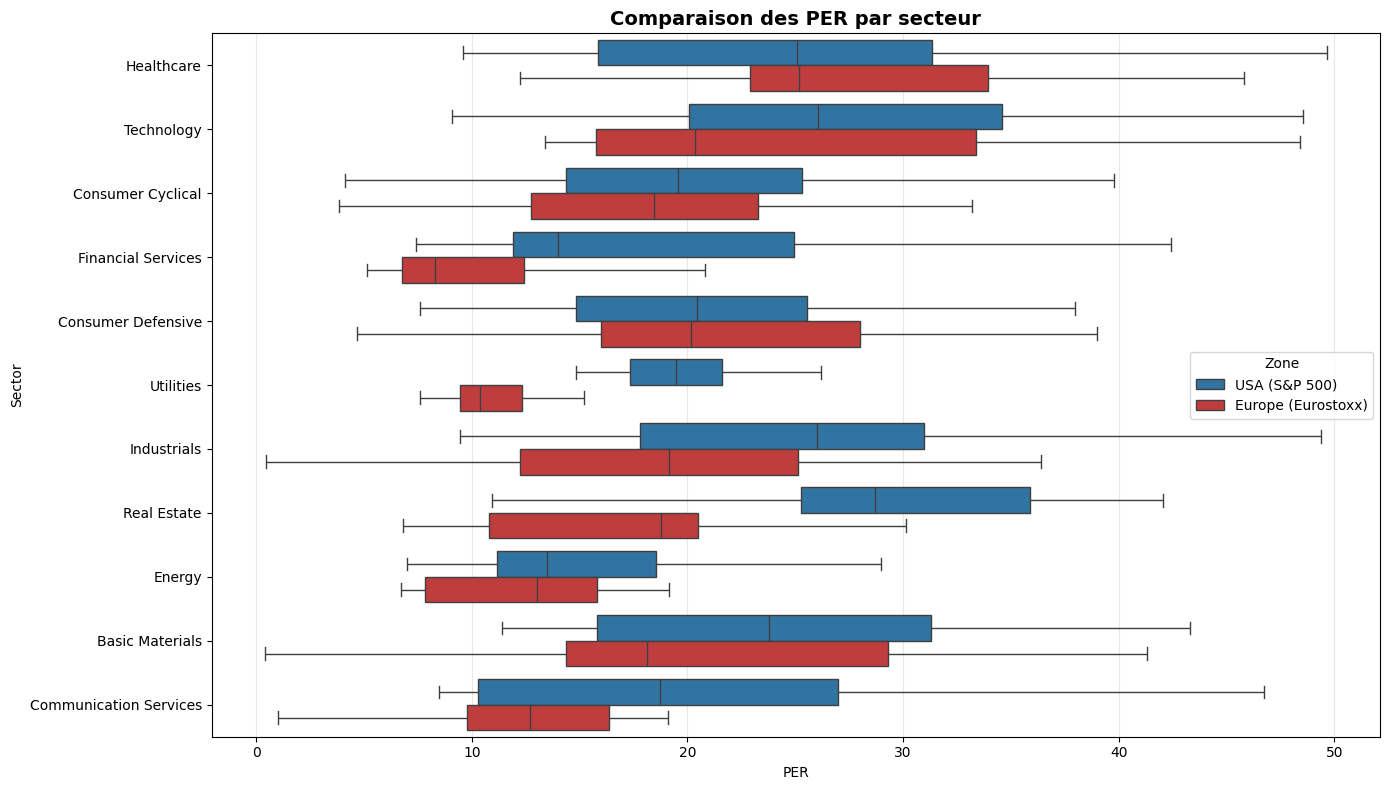

In [7]:
plt.figure(figsize=(14, 8))
sns.boxplot(y='Sector', x='PER_calcule', hue='ZoneLabel', data=df_viz_per,
            palette=['#1f77b4', '#d62728'], showfliers=False, orient='h')

plt.title("Comparaison des PER par secteur", fontsize=14, fontweight='bold')
plt.xlabel("PER")
plt.legend(title='Zone')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

Ce graphique réfute l'hypothèse selon laquelle le premium ne serait qu'un effet de composition. 
Si l'écart de valorisation n'était dû qu'à la présence de la Tech aux USA, les boîtes bleues et rouges seraient alignées pour chaque secteur. Or, on observe que la médiane américaine est supérieure à la médiane européenne dans la quasi-totalité des secteurs, y compris pour la tech. Cela suggère que le marché applique une prime à l'entreprise américaine quelle que soit son industrie. 

Dès lors, on peut légitimement penser que le *premium américain* n'est pas qu'une simple différence de spécialisation économique. Il est probable que l'écart de valorisation s'explique aussi par les fondamentaux financiers des entreprises : c'est ce que nous allons étudier.

Pour cela, concentrons-nous sur deux indicateurs financiers très importants pour les analystes : le ROE et la Marge Nette.

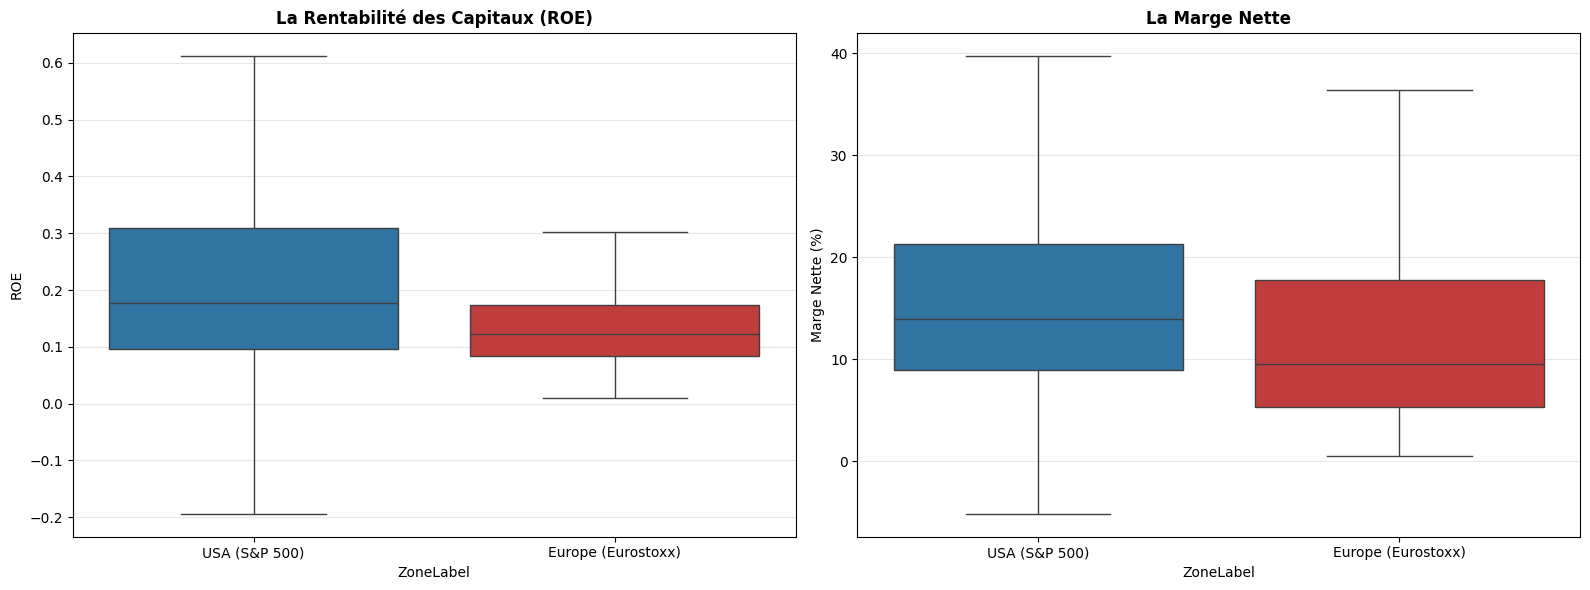

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROE
sns.boxplot(x='ZoneLabel', y='ROE_calcule', hue='ZoneLabel', data=df_viz, ax=axes[0],
            palette=['#1f77b4', '#d62728'], showfliers=False, legend=False)
axes[0].set_title("La Rentabilité des Capitaux (ROE)", fontsize=12, fontweight='bold')
axes[0].set_ylabel("ROE")
axes[0].grid(axis='y', alpha=0.3)

# Marge Nette
sns.boxplot(x='ZoneLabel', y='%MargeNette', hue='ZoneLabel', data=df_viz, ax=axes[1],
            palette=['#1f77b4', '#d62728'], showfliers=False, legend=False)
axes[1].set_title("La Marge Nette", fontsize=12, fontweight='bold')
axes[1].set_ylabel("Marge Nette (%)")
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

On constate que la valorisation n'est *a priori* pas contradictoire avec les fondamentaux financiers : elle récompense la performance des entreprises. En termes de ROE ou de Marge Nette, l'entreprise médiane américaine surclasse son homologue européenne. 

Le *premium américain* n'est-il pas plutôt un *quality discount européeen* ?

### Bilan : un premium structurel, pas irrationnel

L'analyse exploratoire des données de 2024 confirme l'existence d'un écart de valorisation significatif : le PER médian du S&P 500 dépasse celui de l'Eurostoxx 600 d'environ 5 points.

La décomposition visuelle suggère que ce *premium américain* n'est pas une simple bulle spéculative, mais le reflet de trois divergences structurelles majeures :

- L'effet d'échelle (Taille) : Le marché américain héberge de plus grandes entreprises, dont la totalité des plus grosses capitalisations boursières mondiales. Ces géants bénéficient d'une prime de leadership et de liquidité que l'Europe, morcelée, peine à offrir.

- L'effet de composition (Secteur) : L'indice américain est financièrement dominé par la Technologie (valorisée cher), là où l'indice européen reste pondéré par la "Vieille Économie" (Industrie, Finance).

- L'effet de qualité (Rentabilité) : À secteur égal, l'entreprise médiane américaine affiche une rentabilité des capitaux propres (ROE) et une marge nette supérieures.

Nous allons mainteant contrôler mathématiquement les facteurs financiers et sectoriels le facteur géographique pur devrait devenir négligeable. C'est ce que nous allons vérifier dans la partie modélisation.

Nous allons désormer contrôler mathématiquement les facteurs financiers et sectoriels, pour isoler le facteur purement géographique.

# Partie 3 : Modélisation
Nous procéderons en deux temps : 

1. L'approche classique naïve (régression linéaire - OLS) : Nous tenterons d'abord d'expliquer le PER par une combinaison linéaire des facteurs.

2. L'approche structurelle: La finance étant régie par des effets de seuil, nous utiliserons des modèles non-linéaires (Decision Tree Regressor et XGB) pour améliorer nos prédictions.

L'objectif final est d'isoler le poids réel de la variable géographique (Is_USA). Une fois la qualité, le secteur et la taille pris en compte, reste-t-il une "prime de drapeau" inexpliquée ?

Cette modélisation nous permettra de déterminer si le *premium américain* est un mythe géographique ou une réalité comptable.

## Section 1 : Les limites de l'approche linéaire (OLS)
Pour tenter d'expliquer l'écart de valorisation entre les États-Unis et l'Europe, la première approche intuitive consiste à utiliser une régression linéaire multiple (OLS). L'hypothèse sous-jacente est que la valorisation (PER) est une somme pondérée de critères indépendants : la croissance ajoute de la valeur, la dette en retire, et la géographie ajoute un "bonus" fixe.

Dans cette section, nous testons trois modèles de complexité croissante sur les données de l'année 2024 (afin d'éviter les biais de lissage temporel et l'autocorrélation) :
1.  **Le modèle naïf :** Le PER dépend uniquement de la zone géographique (`PER ~ Is_USA`).
2.  **Le modèle fondamental :** Le PER dépend des ratios financiers classiques (ROE, Dette, Marge nette...) et du secteur d'activité.
3.  **Le modèle macro-économique :** Nous ajoutons les primes de risque pays (Damodaran) et la fiscalité.

**Objectif :** Vérifier si une simple droite de régression suffit à capturer la psychologie complexe des marchés financiers.

⚠️ Note Méthodologique : Le choix de l'analyse *cross-sectional*

Bien que nous ayons collecté les données financières sur 4 années (2021-2024), la modélisation principale de cette étude se concentrera exclusivement sur l'année fiscale **2024**.

Pour deux raisons principales : 

1.  **Indépendance statistique (éviter l'autocorrélation) :**
    Dans une régression linéaire standard, chaque observation doit être indépendante. Or, les données d'une même entreprise d'une année sur l'autre sont fortement corrélées (le PER de Microsoft en 2023 détermine en grande partie celui de 2024). Utiliser les 4 années simultanément reviendrait à dupliquer artificiellement notre échantillon, faussant la significativité des résultats (t-stats gonflés).

2.  **Cohérence de la politique monétaire :**
    La période 2021-2024 couvre deux périodes économiques très différentes : l'ère des taux nuls (2021) et celle des taux élevés (2023-2024). La relation entre la Dette et le PER s'est inversée entre ces deux périodes. Mélanger ces années dans un modèle unique créerait une moyenne floue qui ne représenterait aucune réalité économique.

*N.B. : Les données historiques (2021-2023) ne sont pas perdues : elles seront utilisées en fin de section pour un test de robustesse temporelle, afin de vérifier si le premium observé en 2024 est une anomalie ou une constante.*

On commence notre étude en préparant les données 2024. Pour étudier l'influence du facteur géographique, on introduit une *dummy variable* Is_USA qui vaut 1 si l'entreprise est américaine et 0 sinon. On vérifie que l'on a gardé suffisamment de données.

In [9]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
df_sp500 = pd.read_csv("data/df_sp500_clean.csv")
df_euro  = pd.read_csv("data/df_eurostoxx_clean.csv")

df_sp500_24 = df_sp500[df_sp500['AnneeFiscale'] == 2024].copy()
df_euro_24  = df_euro[df_euro['AnneeFiscale'] == 2024].copy()

df_sp500_24['Is_USA'] = 1
df_euro_24['Is_USA']  = 0

df_ml = pd.concat([df_sp500_24, df_euro_24], ignore_index=True)

df_ml['DebtToEquity_Book'] = df_ml['TotalDebtBN'] / df_ml['TotalEquityBN']
df_ml['logVolumeBN'] = np.log(df_ml['Annual_Volume_Traded_BN'].replace(0, np.nan))

df_ml = df_ml[df_ml['TotalRevenueBN'] > 0].copy()
df_ml['logRevenueBN'] = np.log(df_ml['TotalRevenueBN'])

rename_map = {
    "Croissance de l'EPS (en %)": "EPS_Growth",
    "%MargeNette": "MargeNette",
    "%PayOut": "PayOut"
}
df_ml.rename(columns=rename_map, inplace=True)

df_ml = df_ml[(df_ml['PER_calcule'] > 5) & (df_ml['PER_calcule'] < 200)].copy()

features = [
    'Is_USA', 'Beta', 'logRevenueBN', 'ROE_calcule',
    'MargeNette', 'EPS_Growth', 'PayOut',
    'DebtToEquity_Book', 'logVolumeBN'
]

df_model = df_ml.dropna(subset=features + ['PER_calcule']).copy()

print(f"Total entreprises prêtes : {len(df_ml)}")

ratio_us = df_ml['Is_USA'].mean() * 100
print(f"\nProportion USA : {ratio_us:.1f}%")
print(f"Proportion Europe : {100 - ratio_us:.1f}%")

Total entreprises prêtes : 711

Proportion USA : 57.8%
Proportion Europe : 42.2%


On peut commencer par tester notre première hypothèse naïve : le PER dépend dépend uniquement du drapeau américain.

In [11]:
print("\n" + "="*60)
print("MODÈLE 1 : Approche Naïve (PER ~ Is_USA)")
print("="*60)
model_naive = smf.ols('PER_calcule ~ Is_USA', data=df_ml).fit()
coef_us = model_naive.params['Is_USA']
pval_us = model_naive.pvalues['Is_USA']

print(f"R-squared: {model_naive.rsquared:.4f}")
print(f"Impact 'Is_USA' : {coef_us:.2f} points de PER")
print(f"Significativité (p-value) : {pval_us:.4f}")


MODÈLE 1 : Approche Naïve (PER ~ Is_USA)
R-squared: 0.0498
Impact 'Is_USA' : 4.51 points de PER
Significativité (p-value) : 0.0000


Le modèle confirme mathématiquement notre intuition initiale : le coefficient `Is_USA` est positif et significatif.
Cependant, le R² est extrêmement faible (environ 5.7%). La géographie seule n'explique que très peu la variance des prix. C'est donc un facteur marginal pour expliquer la dynamique de marché globale.

On peut donc tester une deuxième approche : l'approche fondamentale. Il s'agit de voir si le PER dépend du secteur, de la rentabilité, de la dette et de la liquidité. On écarte volontairement certaines variables qui permettraient au modèle de tricher (Dividend Yield, Close Price, EPS, Net Income, MarketCapitalization), car elles permettent de recalculer le PER.

Nous utilisons l'estimateur HC3 car il est robuste à l'hétéroscédasticité tout en offrant une meilleure fiabilité d'inférence sur les échantillons finis.

Nous conservons :
- Les moteurs de performances : `ROE_calcule`, `MargeNette`, `EPS_Growth` et `PayOut`
- Les facteurs d'échelle : - `logVolumeBN` (spéculation) et `logRevenueBN` (taille)
- Les facteurs de risque : `Beta` (volatilité) et `DebtToEquity_Book` (levier financier)
- Le facteur géographique : `Is_USA` pour quantifier le premium américain
- Les facteurs de contrôle : `Sector` pour ne pas comparer une banque et une boîte tech.


In [12]:
print("\n" + "="*60)
print("MODÈLE 2 : Approche Fondamentale (Contrôle des facteurs)")
print("="*60)

formula_full = """
PER_calcule ~ Is_USA + C(Sector) + Beta + ROE_calcule + MargeNette + 
               EPS_Growth + PayOut + logVolumeBN + DebtToEquity_Book + logRevenueBN
"""

model_full = smf.ols(formula_full, data=df_ml).fit(cov_type='HC3')

print(f"R-squared: {model_full.rsquared:.4f}")
print("-" * 30)

print(model_full.summary())



MODÈLE 2 : Approche Fondamentale (Contrôle des facteurs)
R-squared: 0.3387
------------------------------
                            OLS Regression Results                            
Dep. Variable:            PER_calcule   R-squared:                       0.339
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     23.55
Date:                Fri, 26 Dec 2025   Prob (F-statistic):           5.15e-62
Time:                        18:28:34   Log-Likelihood:                -2402.4
No. Observations:                 687   AIC:                             4845.
Df Residuals:                     667   BIC:                             4935.
Df Model:                          19                                         
Covariance Type:                  HC3                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]

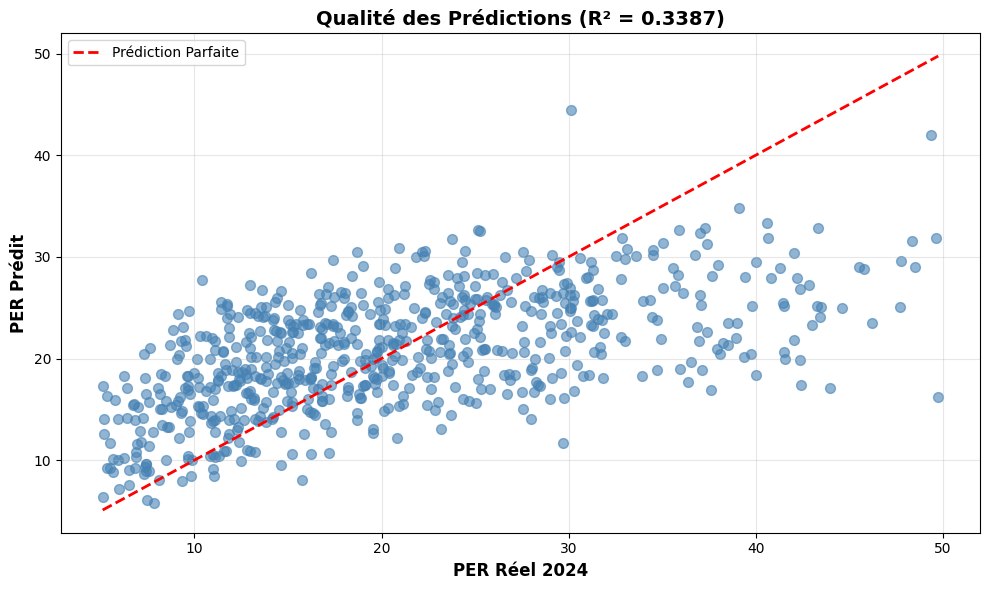

In [13]:
y_test_raw = model_full.model.endog  
y_pred_real = model_full.fittedvalues

plt.figure(figsize=(10, 6))
plt.scatter(y_test_raw, y_pred_real, alpha=0.6, s=50, color='steelblue')

plt.plot([y_test_raw.min(), y_test_raw.max()], [y_test_raw.min(), y_test_raw.max()],'r--', lw=2, label='Prédiction Parfaite')
plt.xlabel('PER Réel 2024', fontsize=12, fontweight='bold')
plt.ylabel('PER Prédit', fontsize=12, fontweight='bold')
plt.title(f'Qualité des Prédictions (R² = {model_full.rsquared:.4f})', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

En ajoutant nos variables financières, le modèle s'améliore mais plafonne à un R² de 34%.
Malgré l'ajout de nombreuses variables explicatives majeures, 66% de la variance de la valorisation continue de nous échapper. Soulignons que les prédictions de notre modèle tendent à surestimer les PER faibles (points au-dessus de la droite, à gauche du graphe), et à sous-estimer les PER élevés (points en-dessous de la droite, à droite du graphe).

Ce résultat suggère que la relation entre les fondamentaux et le prix n'est pas linéaire, mais probablement régie par des seuils.

Pour en avoir le cœur net, ajoutons les variables macro-économiques Damodaran. L'idée est de vérifier si l'on peut expliquer les écarts de valorisation avec la prime de risque pays ou la fiscalité.

In [14]:
df_risk = pd.read_csv('data/country_risk_premiums.csv')

# Nettoyage des espaces dans les noms de pays
df_ml['Country'] = df_ml['Country'].str.strip().str.replace('\s+', ' ', regex=True)
df_risk['Country'] = df_risk['Country'].str.strip().str.replace('\s+', ' ', regex=True)

df_risk.set_index('Country', inplace=True) 
colonnes_marche = ['Country Risk Premium', 'Corporate Tax Rate']
df_risk = df_risk[colonnes_marche]

df_macro = pd.merge(
    df_ml, 
    df_risk, 
    left_on='Country', 
    right_index=True, 
    how='left' 
)

df_macro.rename(columns={'Country Risk Premium': 'RiskPremium', 'Corporate Tax Rate': 'TaxRate'}, inplace=True)

df_macro_clean = df_macro.dropna(subset=['RiskPremium', 'TaxRate'])

print("\n" + "="*60)
print("MODÈLE 3 : Approche Macro (Damodaran) - RÉSULTATS DÉTAILLÉS")
print("="*60)

formula_macro = """
PER_calcule ~ Is_USA + C(Sector) + Beta + ROE_calcule + MargeNette + 
               EPS_Growth + PayOut + logVolumeBN + DebtToEquity_Book + logRevenueBN +
               RiskPremium + TaxRate
"""
model_macro = smf.ols(formula_full, data=df_macro_clean).fit(cov_type='HC3')

print(f"R-squared: {model_macro.rsquared:.4f}")
print("-" * 65)
print(f"{'VARIABLE':<25} : {'COEF':>8} | {'P-VALUE':>8}   {'STATUS'}")
print("-" * 65)

vars_to_watch = ['Is_USA', 'C(Sector)','Beta','MargeNette','EPS_Growth','PayOut','logVolumeBN','RiskPremium', 'TaxRate', 'ROE_calcule', 'DebtToEquity_Book', 'logRevenueBN']

print(model_full.summary())


MODÈLE 3 : Approche Macro (Damodaran) - RÉSULTATS DÉTAILLÉS
R-squared: 0.3387
-----------------------------------------------------------------
VARIABLE                  :     COEF |  P-VALUE   STATUS
-----------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:            PER_calcule   R-squared:                       0.339
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     23.55
Date:                Fri, 26 Dec 2025   Prob (F-statistic):           5.15e-62
Time:                        18:28:34   Log-Likelihood:                -2402.4
No. Observations:                 687   AIC:                             4845.
Df Residuals:                     667   BIC:                             4935.
Df Model:                          19                                         
Covariance Type:     

**Analyses :**
- Les données Damodaran ne sont pas significatives à 5%. Le $R^2$ est inchangé à 35%, malgré l'ajout de nouvelles données. Cela semble confirmer que le modèle linéaire n'est pas performant en l'espèce.
- La variable is_USA reste massivement significative, même après avoir intégré la pénalité de risque pays. Cela signifie qu'une entreprise américaine se paie encore 5.39 points de PER plus cher qu'une entreprise européenne équivalente, après avoir corrigé les différences financières et sectorielles. 
- Les fondamentaux financiers pèsent finalement assez peu dans la balance.

Vérifions que ces observations ne dépendent pas de la conjoncture économique de 2024 : c'est l'occasion de mobiliser nos données pour la période 2021-2023.

Analyse de la robustesse temporelle sur : [2022, 2023, 2024]


/var/folders/f8/zf8ypy610ddgzt91pq54w3dh0000gn/T/ipykernel_16021/3902010697.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y_clean.rename(columns={
/var/folders/f8/zf8ypy610ddgzt91pq54w3dh0000gn/T/ipykernel_16021/3902010697.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y_clean.rename(columns={
/var/folders/f8/zf8ypy610ddgzt91pq54w3dh0000gn/T/ipykernel_16021/3902010697.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

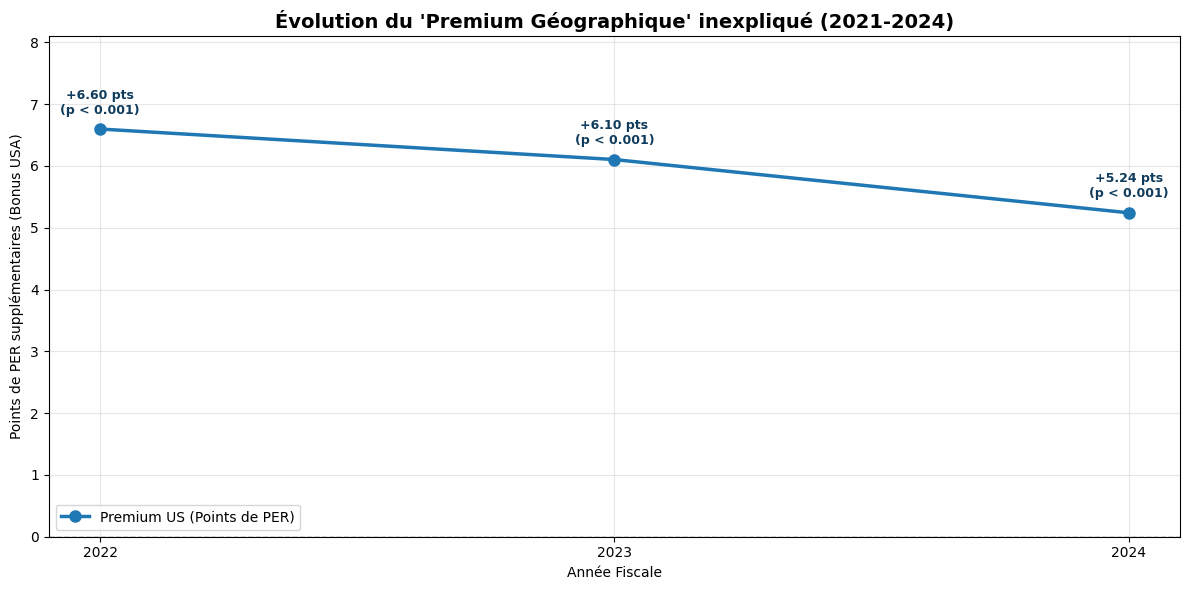

Détail des résultats annuels :
   Année  US_Premium_Points       P_Value        R2
0   2022           6.597449  1.610176e-15  0.400263
1   2023           6.103782  4.305832e-14  0.412558
2   2024           5.242122  4.090663e-11  0.358640


In [15]:
results_time = []
all_years = sorted(df_SP500['AnneeFiscale'].unique())
years = [y for y in all_years if y != 2021]

print(f"Analyse de la robustesse temporelle sur : {years}")

for year in years:
    df_us_y = df_SP500[df_SP500['AnneeFiscale'] == year].copy()
    df_eu_y = df_STX600[df_STX600['AnneeFiscale'] == year].copy()
    
    df_us_y['ZoneLabel'] = 'USA'
    df_eu_y['ZoneLabel'] = 'Europe'
    
    df_y = pd.concat([df_us_y, df_eu_y], ignore_index=True)
    
    df_y['Is_USA'] = (df_y['ZoneLabel'] == 'USA').astype(int)
    df_y['DebtToEquity_Book'] = df_y['TotalDebtBN'] / df_y['TotalEquityBN']
    df_y['logVolumeBN'] = np.log(df_y['Annual_Volume_Traded_BN'].replace(0, np.nan))


    df_y = df_y[df_y['TotalRevenueBN'] > 0].copy()

    df_y['logRevenueBN'] = np.log(df_y['TotalRevenueBN'])
    
    df_y_clean = df_y[
        (df_y['PER_calcule'] > 0) & (df_y['PER_calcule'] < 100) &
        (df_y['DebtToEquity_Book'] > 0) & (df_y['DebtToEquity_Book'] < 20)
    ]
    
    df_y_clean.rename(columns={
        "Croissance de l'EPS (en %)": "EPS_Growth",
        "%MargeNette": "MargeNette",
        "%PayOut": "PayOut"
    }, inplace=True)
    
    formula ="""
                PER_calcule ~ Is_USA + C(Sector) + Beta + ROE_calcule + MargeNette + 
                            EPS_Growth + PayOut + logVolumeBN + DebtToEquity_Book + logRevenueBN
            """
    model_y = smf.ols(formula, data=df_y_clean).fit()
    
    premium = model_y.params['Is_USA']
    p_value = model_y.pvalues['Is_USA']
    r2 = model_y.rsquared
    
    results_time.append({
        'Année': year,
        'US_Premium_Points': premium,
        'P_Value': p_value,
        'R2': r2
    })

df_results_time = pd.DataFrame(results_time)

plt.figure(figsize=(12, 6))

plt.plot(df_results_time['Année'], df_results_time['US_Premium_Points'], 
         marker='o', markersize=8, linestyle='-', color='#1f77b4', linewidth=2.5, label='Premium US (Points de PER)')

plt.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.7)

for index, row in df_results_time.iterrows():
    annee = row['Année']
    valeur = row['US_Premium_Points']
    pval = row['P_Value']
    
    if pval < 0.001:
        p_text = "p < 0.001"
    else:
        p_text = f"p={pval:.3f}"
        
    label = f"+{valeur:.2f} pts\n({p_text})"
    
    plt.text(annee, valeur + 0.2, label, 
             horizontalalignment='center', 
             verticalalignment='bottom', 
             fontsize=9, 
             color='#0f3b5c',
             fontweight='bold')

plt.title("Évolution du 'Premium Géographique' inexpliqué (2021-2024)", fontsize=14, fontweight='bold')
plt.ylabel("Points de PER supplémentaires (Bonus USA)")
plt.xlabel("Année Fiscale")
plt.xticks(years)

plt.ylim(0, df_results_time['US_Premium_Points'].max() + 1.5) 

plt.grid(True, alpha=0.3)
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

print("Détail des résultats annuels :")
print(df_results_time[['Année', 'US_Premium_Points', 'P_Value', 'R2']])

Le premium américain semble bien structurel et non conjoncturel : sur les quatre années observées, le *premium* reste entre 5 et 7, quel que soit le contexte économique (taux nuls en 2021, krach obligataire en 2022, euphorie boursière en 2024). À fondamentaux égaux, l'action américaine se paie systématiquement plus cher que son homologue européenne.

Toutefois, la régression linéaire ne capture pas les effets de seuil. Nous proposons un graphique pour s'en convaincre :

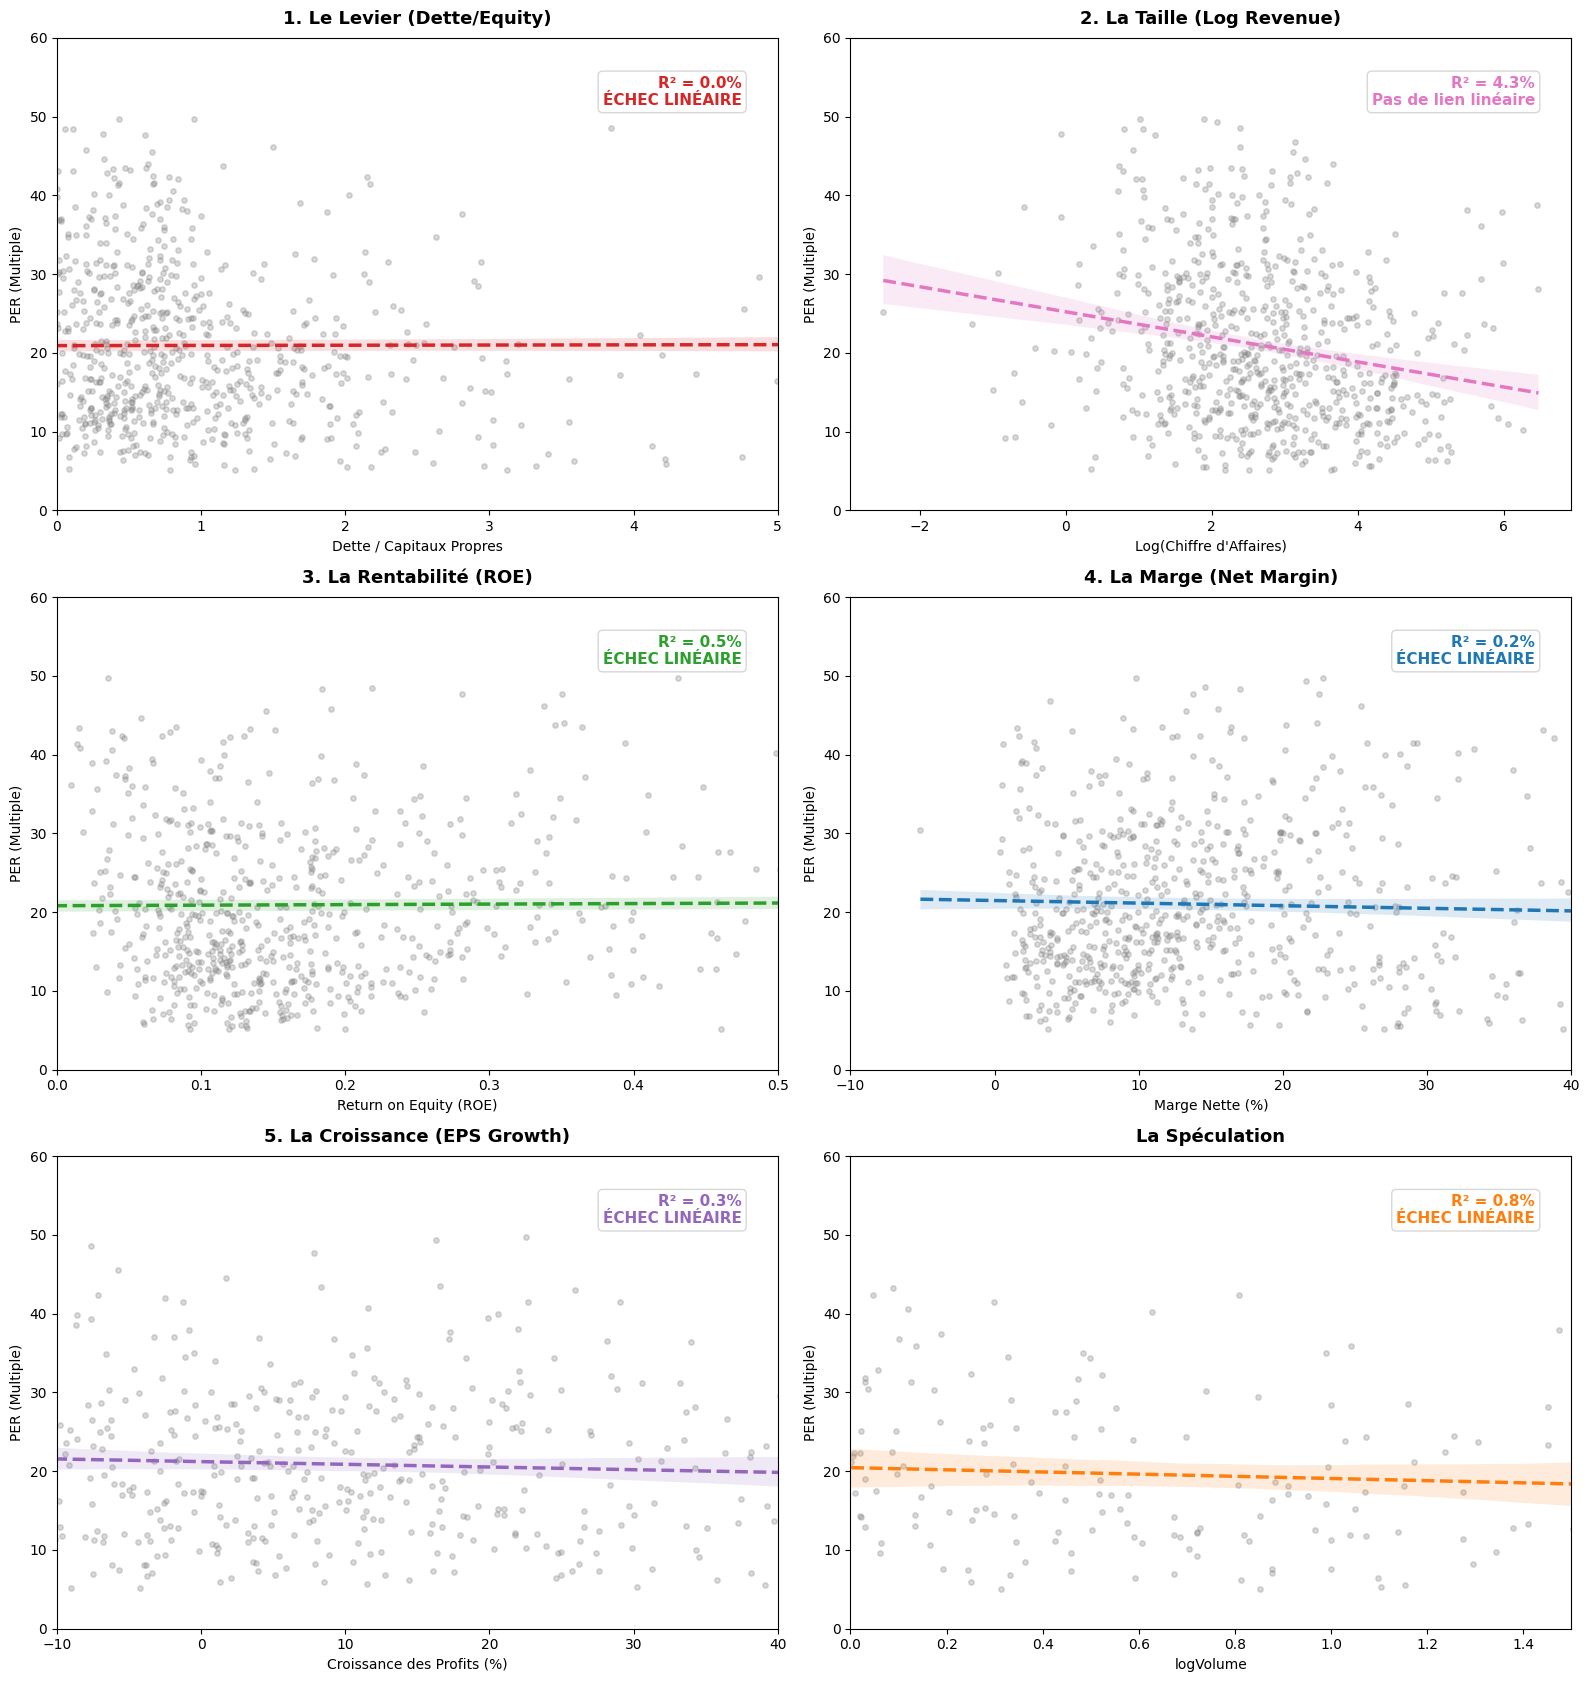

In [16]:
df_reg = df_ml.copy()

df_growth = df_reg[
    (df_reg['EPS_Growth'] > -20) & (df_reg['EPS_Growth'] < 50)
].copy()

df_rev = df_reg[df_reg['TotalRevenueBN'] > 0].copy()
df_rev['Log_Revenue'] = np.log(df_rev['TotalRevenueBN'])

df_volume = df_reg[df_reg['logVolumeBN'] > 0].copy()

fig, axes = plt.subplots(3, 2, figsize=(16, 18))
axes = axes.flatten()

configs = [
    {
        'data': df_reg, 'x': 'DebtToEquity_Book', 'y': 'PER_calcule',
        'title': "1. Le Levier (Dette/Equity)", 'color': '#d62728',
        'xlim': (0, 5), 'xlabel': "Dette / Capitaux Propres"
    },
    {
        'data': df_rev, 'x': 'Log_Revenue', 'y': 'PER_calcule',
        'title': "2. La Taille (Log Revenue)", 'color': '#e377c2',
        'xlim': (None, None), 'xlabel': "Log(Chiffre d'Affaires)",
        'verdict_override': "Pas de lien linéaire"
    },
    
    {
        'data': df_reg, 'x': 'ROE_calcule', 'y': 'PER_calcule',
        'title': "3. La Rentabilité (ROE)", 'color': '#2ca02c',
        'xlim': (0, 0.5), 'xlabel': "Return on Equity (ROE)"
    },
    {
        'data': df_reg, 'x': 'MargeNette', 'y': 'PER_calcule',
        'title': "4. La Marge (Net Margin)", 'color': '#1f77b4',
        'xlim': (-10, 40), 'xlabel': "Marge Nette (%)"
    },
    
    {
        'data': df_growth, 'x': 'EPS_Growth', 'y': 'PER_calcule',
        'title': "5. La Croissance (EPS Growth)", 'color': '#9467bd',
        'xlim': (-10, 40), 'xlabel': "Croissance des Profits (%)"
    },
    {
        'data': df_volume, 'x': 'logVolumeBN', 'y': 'PER_calcule',
        'title': "La Spéculation", 'color': '#ff7f0e',
        'xlim': (0, 1.5),
        'xlabel': "logVolume"
    }
]

for i, cfg in enumerate(configs):
    ax = axes[i]
    data = cfg['data']
    
    if cfg['x'] not in data.columns:
        continue

    formula = f"{cfg['y']} ~ {cfg['x']}"
    try:
        model = smf.ols(formula, data=data).fit()
        r2 = model.rsquared
    except:
        r2 = 0.0

    sns.regplot(x=cfg['x'], y=cfg['y'], data=data, ax=ax,
                scatter_kws={'alpha': 0.3, 's': 15, 'color': 'gray'},
                line_kws={'color': cfg['color'], 'linewidth': 2.5, 'linestyle': '--'})
    
    ax.set_title(cfg['title'], fontsize=13, fontweight='bold', pad=10)
    ax.set_xlabel(cfg['xlabel'])
    ax.set_ylabel("PER (Multiple)")
    ax.set_ylim(0, 60) 
    
    if cfg['xlim'] != (None, None):
        ax.set_xlim(cfg['xlim'])
    
    verdict = "ÉCHEC LINÉAIRE" if r2 < 0.10 else "CORRÉLATION FAIBLE"
    if 'verdict_override' in cfg:
        verdict = cfg['verdict_override']
    
    ax.text(
        0.95, 0.92, 
        f"R² = {r2:.1%}\n{verdict}", 
        transform=ax.transAxes, 
        ha='right', va='top',
        fontsize=11, fontweight='bold', color=cfg['color'],
        bbox=dict(facecolor='white', alpha=0.9, edgecolor='lightgray', boxstyle='round')
    )
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

Les graphiques sont parlants : il n'y a aucune relation linéaire entre le PER et la taille de l'entreprise, le levier financier, le ROE, la marge nette, la spéculation ou la croissance des EPS.

Cela ne signifie pas que ces variables explicatives sont insignifiantes, mais plutôt que la méthode de calcul linéaire est inadaptée : le marché fonctionne très probablement par seuils. C'est pourquoi un modèle non-linéaire capable de segementer le marché est indispensable.

## Section 2 : Modèles non-linéaires

Les analyses précédentes ont montré que les multiples de valorisation ne suivent pas une logique linéaire additive ($R^2$ plafonnant à 35%). 

Cela nous conduit à formuler l'hypothèse selon laquelle la valorisation suit une logique de seuils conditionnels (heuristique). Par exemple, une dette élevée est tolérée si et seulement si la croissance dépasse 20%.

Pour capturer cette complexité, nous allons procéder par étapes :

1. Nous allons d'abord préparer les données (nettoyage des valeurs extrêmes non-linéaires)
2. Ensuite, nous visualiserons la carte mentale simplifiée du marché avec un arbre de décision.
3. Enfin, nous utiliserons un algorithme de Grandient Boosting pour maximiser la puissance prédictive et prouver la rationalité des valorisations.

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import r2_score, mean_absolute_error
import shap
from copy import deepcopy

sns.set_style("whitegrid")

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


On recharge et nettoie proprement les données  pour notre arbre de décision : 

In [18]:
df_sp500 = pd.read_csv("data/df_sp500_clean.csv")
df_euro  = pd.read_csv("data/df_eurostoxx_clean.csv")

df_sp500_24 = df_sp500[df_sp500['AnneeFiscale'] == 2024].copy()
df_euro_24  = df_euro[df_euro['AnneeFiscale'] == 2024].copy()

df_sp500_24['Is_USA'] = 1
df_euro_24['Is_USA']  = 0

df_ml = pd.concat([df_sp500_24, df_euro_24], ignore_index=True)

df_ml['DebtToEquity_Book'] = df_ml['TotalDebtBN'] / df_ml['TotalEquityBN']
df_ml['logVolumeBN'] = np.log(df_ml['Annual_Volume_Traded_BN'].replace(0, np.nan))

df_ml = df_ml[df_ml['TotalRevenueBN'] > 0].copy()
df_ml['logRevenueBN'] = np.log(df_ml['TotalRevenueBN'])

rename_map = {
    "Croissance de l'EPS (en %)": "EPS_Growth",
    "%MargeNette": "MargeNette",
    "%PayOut": "PayOut"
}
df_ml.rename(columns=rename_map, inplace=True)

df_ml = df_ml[(df_ml['PER_calcule'] > 5) & (df_ml['PER_calcule'] < 200)].copy()

df_reg = pd.get_dummies(df_ml, columns=['Sector'], drop_first=True)

features = [
    'Is_USA', 'Beta', 'logRevenueBN', 'ROE_calcule',
    'MargeNette', 'EPS_Growth', 'PayOut',
    'DebtToEquity_Book', 'logVolumeBN'
]
features += [c for c in df_reg.columns if c.startswith('Sector_')]

df_model = df_reg.dropna(subset=features + ['PER_calcule']).copy()

Conformément aux bonnes pratiques pour améliorer la qualité du modèle, on split le *dataset*, on applique le log sur la cible (PER) et on winsorise : 

In [19]:
X = df_model[features + ['PER_calcule']].copy()
y_log = np.log(df_model['PER_calcule'])

X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

def winsorize_series(s, q_low=0.01, q_high=0.99):
    low = s.quantile(q_low)
    high = s.quantile(q_high)
    return s.clip(low, high), low, high

winsor_cols = [
    'PER_calcule', 'ROE_calcule', 'MargeNette',
    'EPS_Growth', 'DebtToEquity_Book',
    'logVolumeBN', 'logRevenueBN'
]

winsor_bounds = {}

for col in winsor_cols:
    X_train[col], low, high = winsorize_series(X_train[col])
    winsor_bounds[col] = (low, high)

for col, (low, high) in winsor_bounds.items():
    X_test[col] = X_test[col].clip(low, high)

X_train_final = X_train[features]
X_test_final  = X_test[features]

On peut alors lancer le Decision Tree en le laissant trouver les meilleurs paramètres :

In [20]:
param_grid = {
    'max_depth': [4, 5, 6, 7, 8],
    'min_samples_leaf': [10, 15, 20, 25],
    'min_samples_split': [20, 40, 60]
}

dt = DecisionTreeRegressor(random_state=42)

grid = GridSearchCV(
    dt,
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

grid.fit(X_train_final, y_train_log)
best_tree = grid.best_estimator_

y_pred_log  = best_tree.predict(X_test_final)
y_pred_real = np.exp(y_pred_log)
y_test_real = np.exp(y_test_log)

r2_log  = r2_score(y_test_log, y_pred_log)
r2_real = r2_score(y_test_real, y_pred_real)

print(f"Meilleurs paramètres : {grid.best_params_}")
print(f"R² log(PER) : {r2_log:.2%}")
print(f"R² PER réel : {r2_real:.2%}")

Meilleurs paramètres : {'max_depth': 4, 'min_samples_leaf': 20, 'min_samples_split': 20}
R² log(PER) : 26.47%
R² PER réel : 17.61%


L'arbre ayant pour objectif de nous aider à visualiser les mécanismes à l'œuvre, on se satisfait du faible $R^2$ (26.5%).

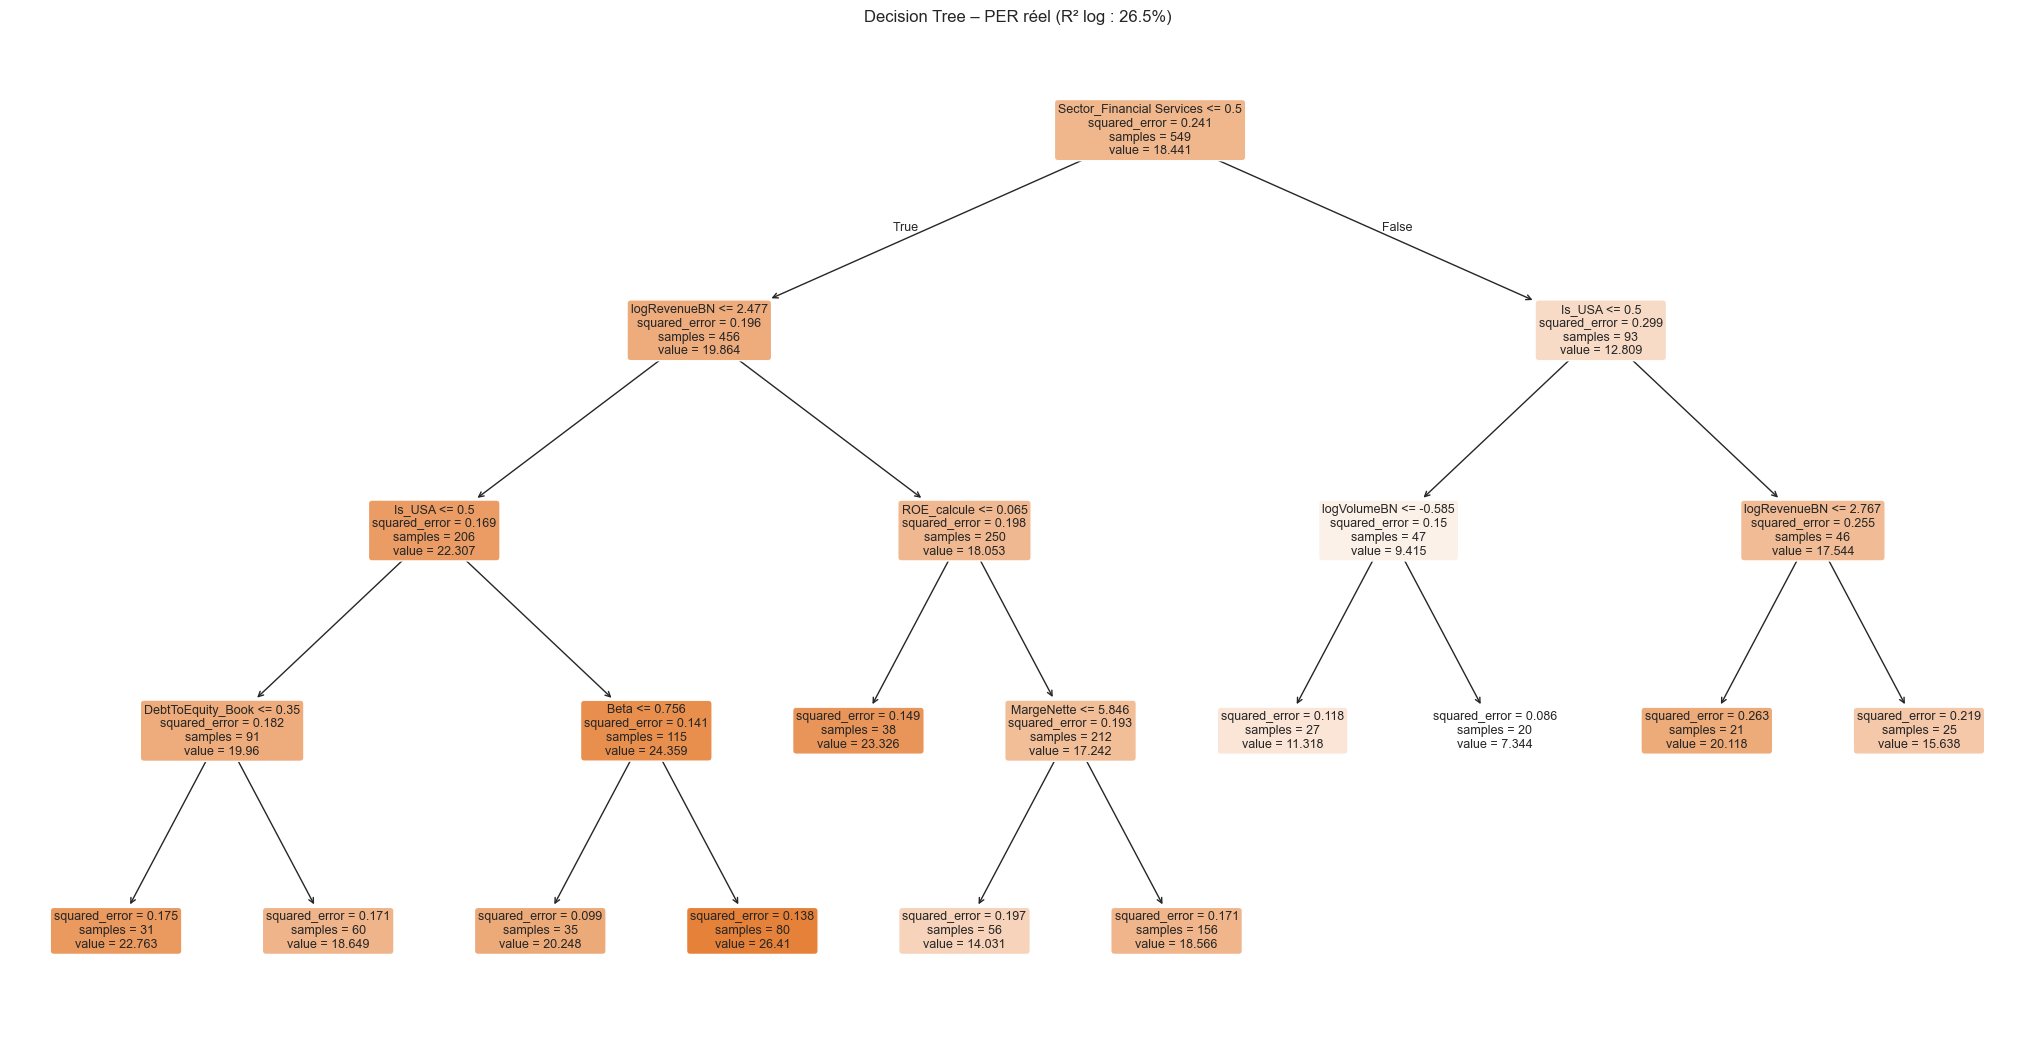

In [21]:
tree_for_plot = deepcopy(best_tree)

# Conversion log(PER) -> PER uniquement pour l'affichage
tree_for_plot.tree_.value[:] = np.exp(tree_for_plot.tree_.value)

plt.figure(figsize=(26, 13))
plot_tree(
    tree_for_plot,
    feature_names=features,
    filled=True,
    rounded=True,
    fontsize=9,
    max_depth=4
)
plt.title(f"Decision Tree – PER réel (R² log : {r2_log:.1%})")
plt.show()

**Analyses :**
- Il existe une différence fondamentale entre les entreprises de services financiers et les autres : ces dernières ont un PER plus élevé (19.9x) que les premières (12.8x). Toutefois, une distinction s'impose entre les institutions financières américaines (17.5x) et européennes (9.4%). Ce résultat n'a rien de surprenant, car les régulations prudentielles sont bien plus contraignantes en Europe qu'aux États-Unis.
- Concentrons-nous à présent sur la branche de gauche. Le deuxième nœud (`logRevenueBN`) divise le *dataset* en deux et pénalise les grosses entreprises (22x) par rapport aux plus petites (18x). Cela s'explique par la logique fondamentale du PER, qui traduit les anticipations de croissance future : il est plus difficile pour une entreprise de continuer à croître lorsqu'elle est mature. Pour ces entreprises matures (*vache à lait*), une marge nette importante (>6%) est logiquement exigée (18.5x) sous peine de *discount* (14x).  Pour les autres, que l'on peut qualifier d'entreprises de croissance, le drapeau américain est un avantage significatif (24.4x) sur le drapeau européen (20x).

Voyons maintenant jusqu'où l'on peut pousser notre $R^2$ sans *data leakage*, en utilisant le *Gradient Boosting* pour capturer des effets de seuil.

In [22]:
import xgboost as xgb

Par mesure de précaution, on recharge et on nettoie à nouveau les données.

In [23]:
df_sp500 = pd.read_csv("data/df_sp500_clean.csv")
df_euro = pd.read_csv("data/df_eurostoxx_clean.csv")

df_sp = df_sp500.copy()
df_eu = df_euro.copy()
df_sp['Is_USA'] = 1
df_eu['Is_USA'] = 0

df_ml = pd.concat([df_sp, df_eu], ignore_index=True)

cols_num = ['TotalRevenueBN', 'TotalDebtBN', 'TotalEquityBN', 
            'Annual_Volume_Traded_BN', 'MarketCapitalizationBN', 'PER_calcule']
for c in cols_num:
    df_ml[c] = pd.to_numeric(df_ml[c], errors='coerce')

df_ml['DebtToEquity_Book'] = df_ml['TotalDebtBN'] / df_ml['TotalEquityBN']
df_ml['logVolumeBN'] = np.log(df_ml['Annual_Volume_Traded_BN'].replace(0, np.nan))
df_ml = df_ml[df_ml['TotalRevenueBN'] > 0].copy()
df_ml['logRevenueBN'] = np.log(df_ml['TotalRevenueBN'])

rename_map = {"Croissance de l'EPS (en %)": "EPS_Growth", "%MargeNette": "MargeNette", "%PayOut": "PayOut"}
df_ml.rename(columns=rename_map, inplace=True)

df_clean = df_ml[(df_ml['PER_calcule'] > 5) & (df_ml['PER_calcule'] < 150)].copy()
df_clean = df_clean.dropna(subset=['logVolumeBN', 'ROE_calcule', 'MargeNette', 'EPS_Growth'])

df_encoded = pd.get_dummies(df_clean, columns=['Sector'], prefix='Sector')

features_base = [
    'Is_USA', 'Beta', 'ROE_calcule', 'MargeNette', 'EPS_Growth', 
    'PayOut', 'DebtToEquity_Book', 'logVolumeBN', 'logRevenueBN'
]
features_sector = [c for c in df_encoded.columns if c.startswith('Sector_')]
features_final = features_base + features_sector

On utilise une méthodologie standard en analyse financière : le Walk-Forward. Concrètement, on entraîne notre modèle sur les données 2022 et 2023, et on l'évalue en utilisant les données de 2024.

In [24]:
mask_train = df_encoded['AnneeFiscale'].isin([2022, 2023])
X_train = df_encoded.loc[mask_train, features_final].astype(float)
y_train_log = np.log(df_encoded.loc[mask_train, 'PER_calcule'])

mask_test = df_encoded['AnneeFiscale'] == 2024
X_test = df_encoded.loc[mask_test, features_final].astype(float)
y_test_log = np.log(df_encoded.loc[mask_test, 'PER_calcule'])
y_test_raw = df_encoded.loc[mask_test, 'PER_calcule']

xgb_final = xgb.XGBRegressor(
    n_estimators=3000, learning_rate=0.01, max_depth=6,
    subsample=0.7, colsample_bytree=0.7, early_stopping_rounds=100,
    random_state=12, n_jobs=-1
)
xgb_final.fit(X_train, y_train_log, eval_set=[(X_test, y_test_log)], verbose=False)

y_pred_real = np.exp(xgb_final.predict(X_test))
mae = mean_absolute_error(y_test_raw, y_pred_real)
r2 = r2_score(y_test_raw, y_pred_real)

print(f"R² : {r2:.2%}")
print(f"MAE : {mae:.2f} points de PER")

R² : 50.00%
MAE : 4.93 points de PER


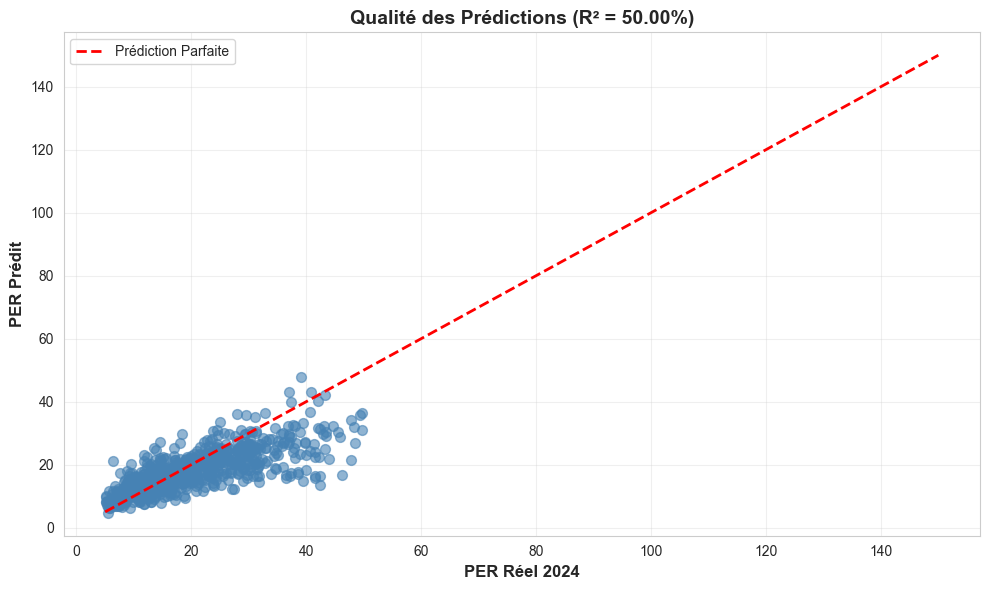

In [25]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_raw, y_pred_real, alpha=0.6, s=50, color='steelblue')
plt.plot([5, 150], [5, 150], 'r--', lw=2, label='Prédiction Parfaite')
plt.xlabel('PER Réel 2024', fontsize=12, fontweight='bold')
plt.ylabel('PER Prédit', fontsize=12, fontweight='bold')
plt.title(f'Qualité des Prédictions (R² = {r2:.2%})', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

On observe un bond de 15% dans notre $R^2$, que l'on va interpréter en utilisant l'analyse SHAP. Soulignons toutefois que le modèle tend toujours à sous-estimer les PER élevés.

In [26]:
explainer = shap.Explainer(xgb_final, X_train)
shap_values_obj = explainer(X_test)
shap_values = shap_values_obj.values
use_new_api = True

100%|===================| 684/687 [01:40<00:00]        

On peut donc désormais observer les paramètres importants :

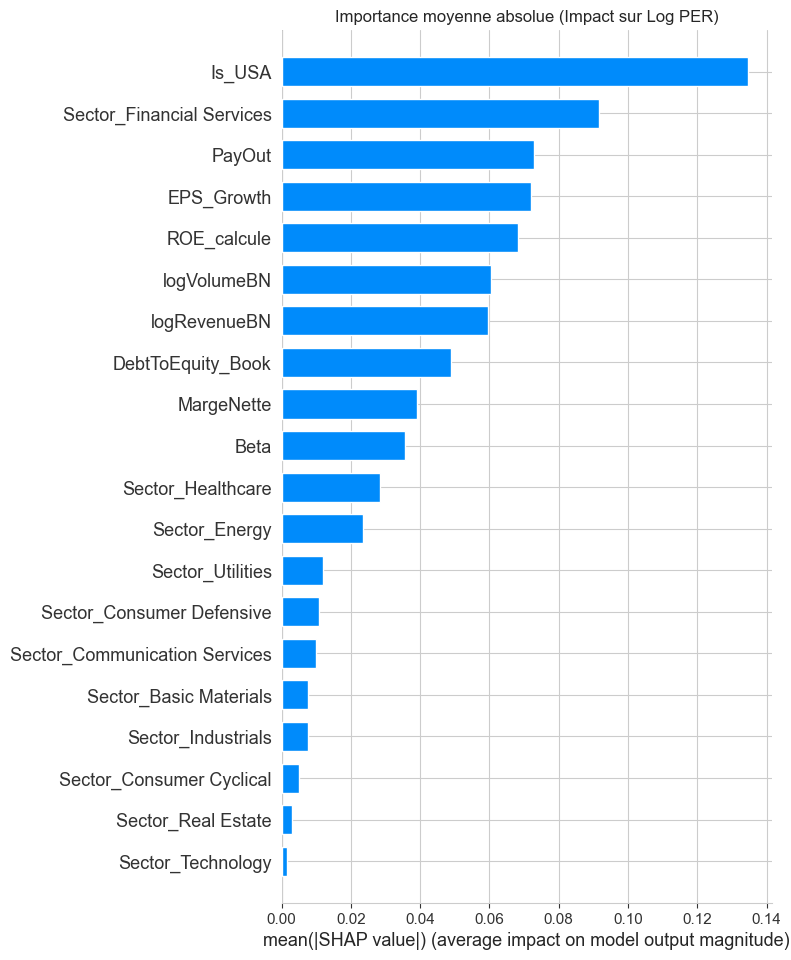

In [27]:
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("Importance moyenne absolue (Impact sur Log PER)")
plt.show()

On ne peut pas s'arrêter à ce graphique car, s'il nous donne l'impact moyen de chaque variable, il ne précise pas la direction : est-ce un impact positif ou négatif ?

Pour affiner notre analyse, on passe à un Beeswarm Plot :

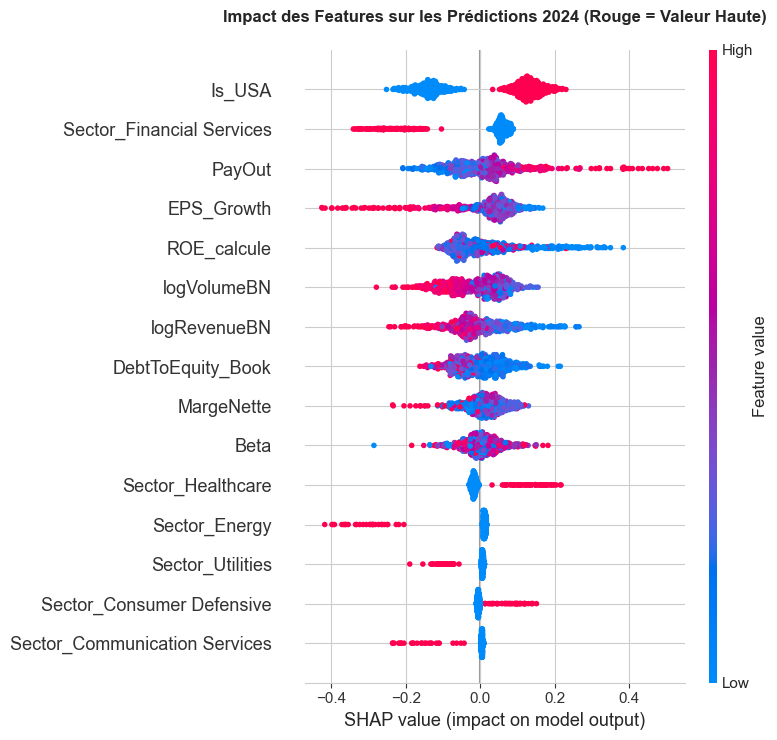

In [28]:
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, max_display=15, show=False)
plt.title("Impact des Features sur les Prédictions 2024 (Rouge = Valeur Haute)", fontsize=12, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

**Analyses** :
- Le premium américain est incontestable, tout comme le malus pour les secteurs financiers, l'énergie ou les *utilities*.
- Contrairement à notre intuition initiale, le secteur technologique ne donne droit à aucun premium significatif, par opposition à la santé (spéculation sur les découvertes scientifiques). 
- Les entreprises qui distribuent beaucoup de cash aux actionnaires sont également récompensées (PayOut)
- On retrouve également le malus des entreprises matures avec les variables logVolumeBN et logRevenueBN.

Toutefois, ces valeurs restent assez abstraites et l'on préfère regarder l'impact moyen (en pourcentage) de chaque variable. Le graphe suivant affiche cet impact moyen pour le premier quartile de chaque variable.

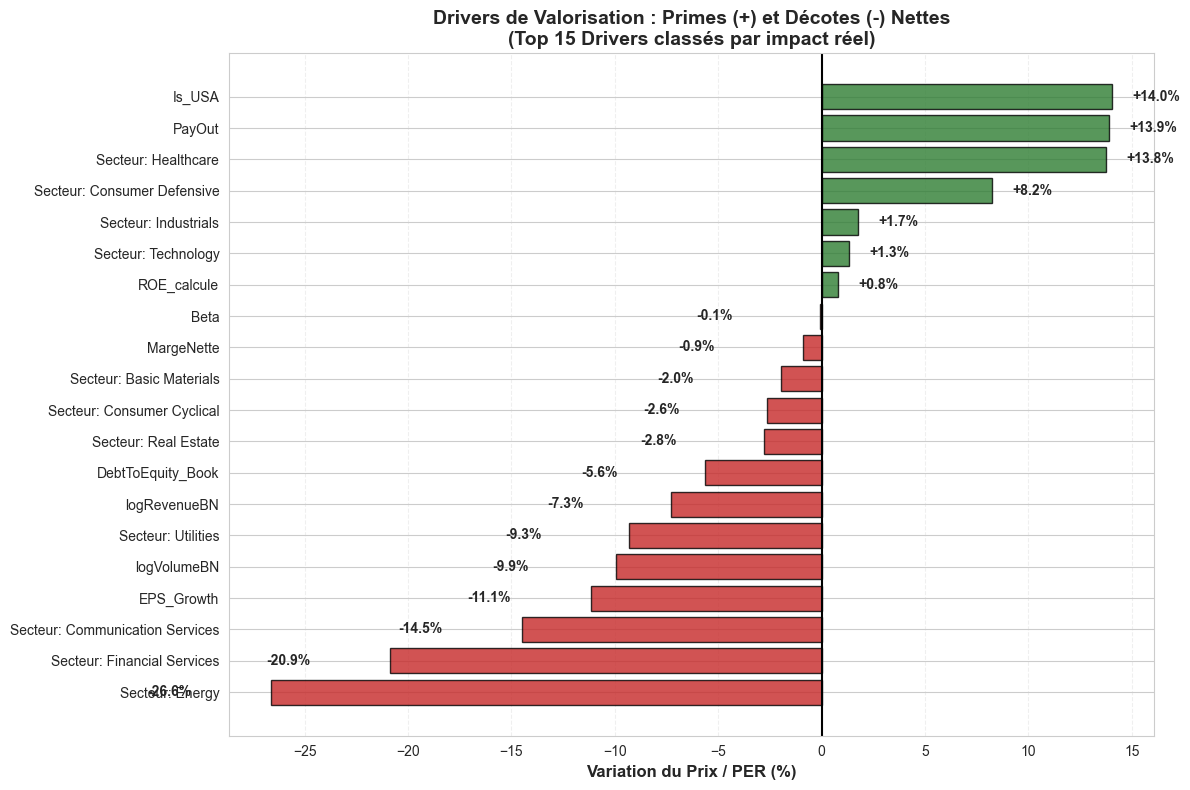

In [29]:
results_premium = []
for col_idx, col_name in enumerate(features_final):
    feature_data = X_test[col_name]
    shap_data = shap_values[:, col_idx]
    
    if feature_data.nunique() <= 2:
        mask = feature_data == 1
        condition_desc = "Présent"
    else:
        mask = feature_data >= feature_data.quantile(0.75)
        condition_desc = "Top 25%"

    if mask.sum() > 20:
        mean_log_impact = np.mean(shap_data[mask])
        premium_pct = (np.exp(mean_log_impact) - 1) * 100
        results_premium.append({
            'Variable': col_name.replace('Sector_', 'Secteur: '),
            'Condition': condition_desc,
            'Impact (%)': premium_pct,
            'Abs_Impact': abs(premium_pct)
        })

df_prem = pd.DataFrame(results_premium)

top_15 = df_prem.sort_values('Abs_Impact', ascending=False).head(20).copy()

top_15 = top_15.sort_values('Impact (%)', ascending=True)

plt.figure(figsize=(12, 8))
colors = ['#2e7d32' if x > 0 else '#c62828' for x in top_15['Impact (%)']]

bars = plt.barh(top_15['Variable'], top_15['Impact (%)'], color=colors, edgecolor='black', alpha=0.8)
plt.axvline(0, color='black', lw=1.5)
plt.title("Drivers de Valorisation : Primes (+) et Décotes (-) Nettes\n(Top 15 Drivers classés par impact réel)", fontsize=14, fontweight='bold')
plt.xlabel("Variation du Prix / PER (%)", fontsize=12, fontweight='bold')

plt.grid(axis='x', alpha=0.3, linestyle='--')

for bar in bars:
    width = bar.get_width()
    x_pos = width + (1 if width > 0 else -6) 
    plt.text(x_pos, bar.get_y() + bar.get_height()/2, 
             f'{width:+.1f}%', va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

Ainsi, avoir un PayOut supérieur à 75% des entreprises augmente le PER de 14% en moyenne, comme le fait d'être une entreprise américaine ou dans le secteur de la santé.

Pour finir, il est intéressant de regarder comment le modèle décompose sa prédiction de PER pour des entreprises en particulier.

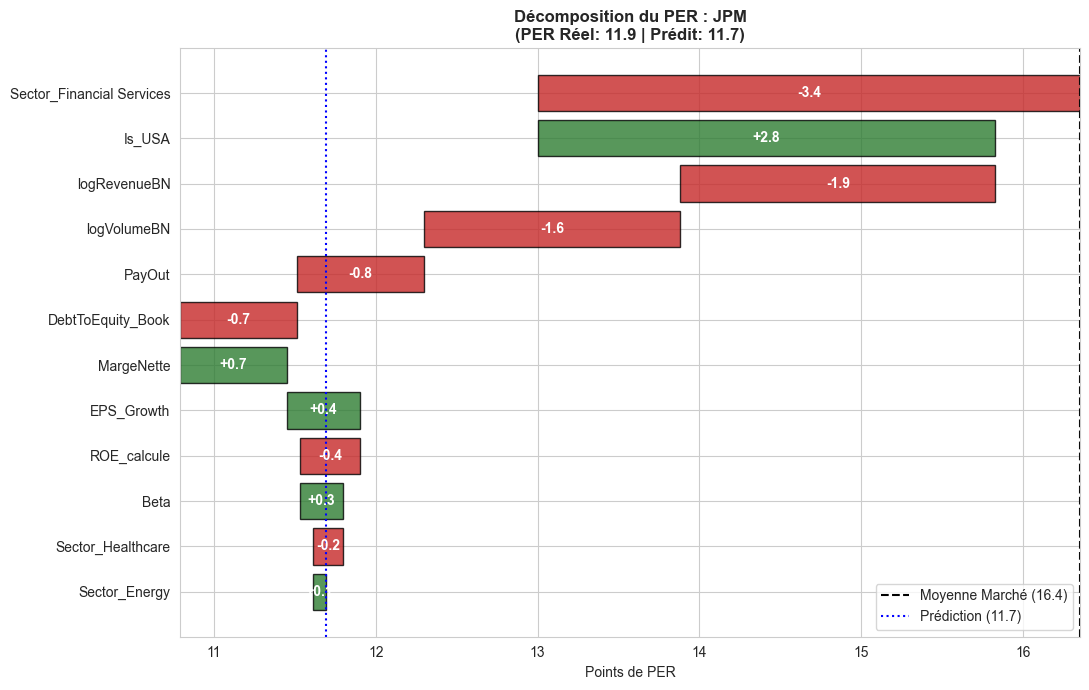

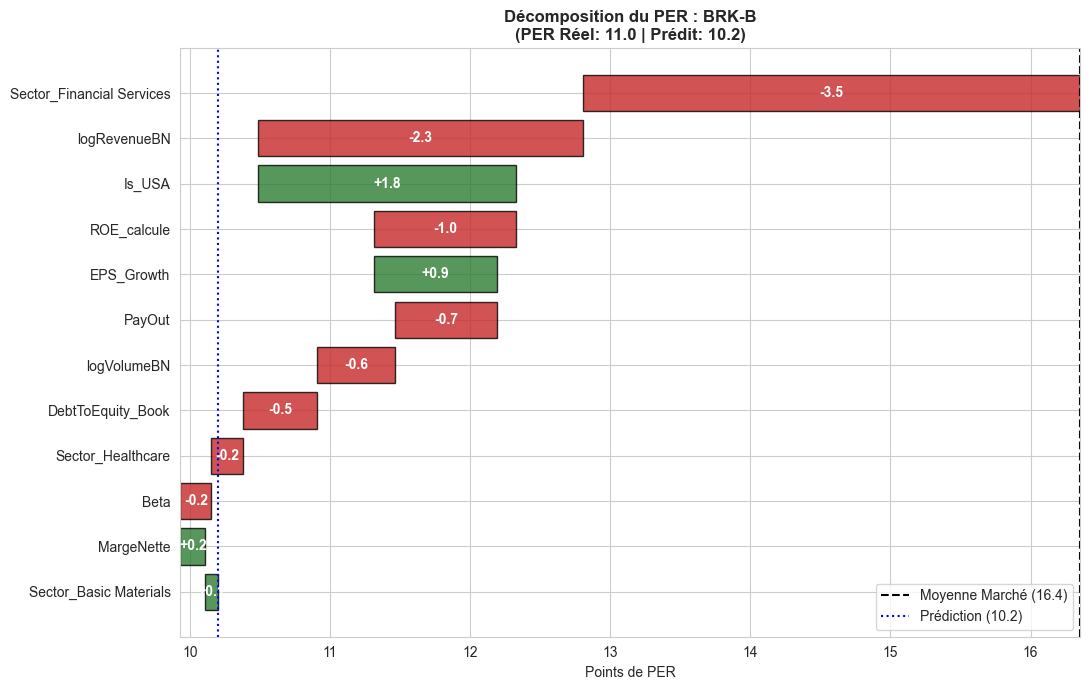

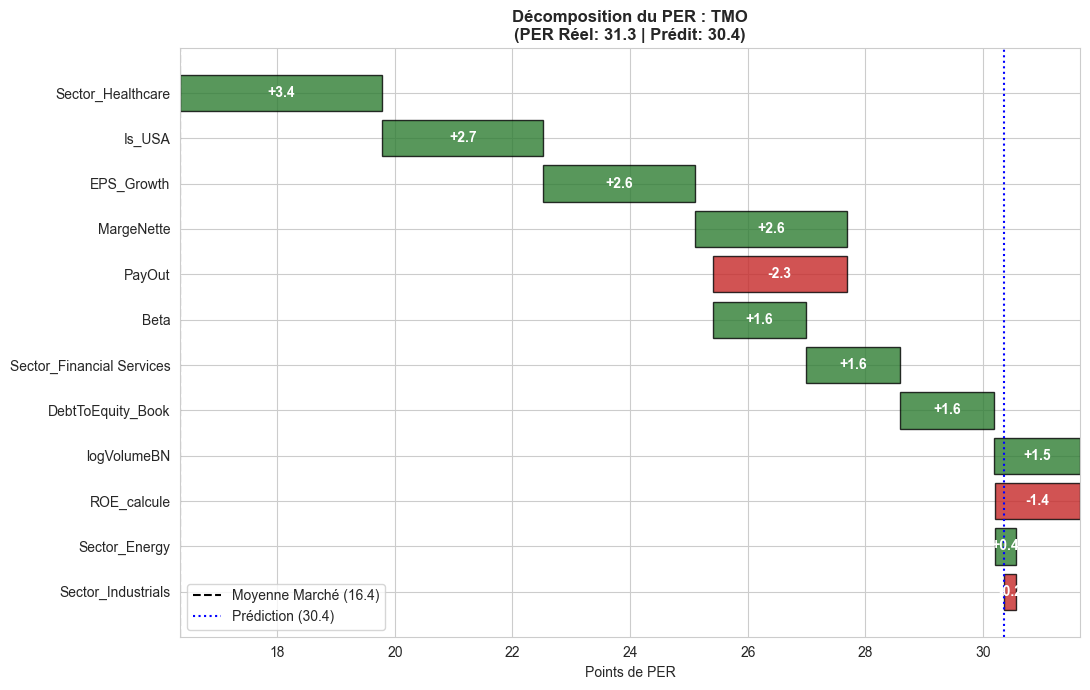

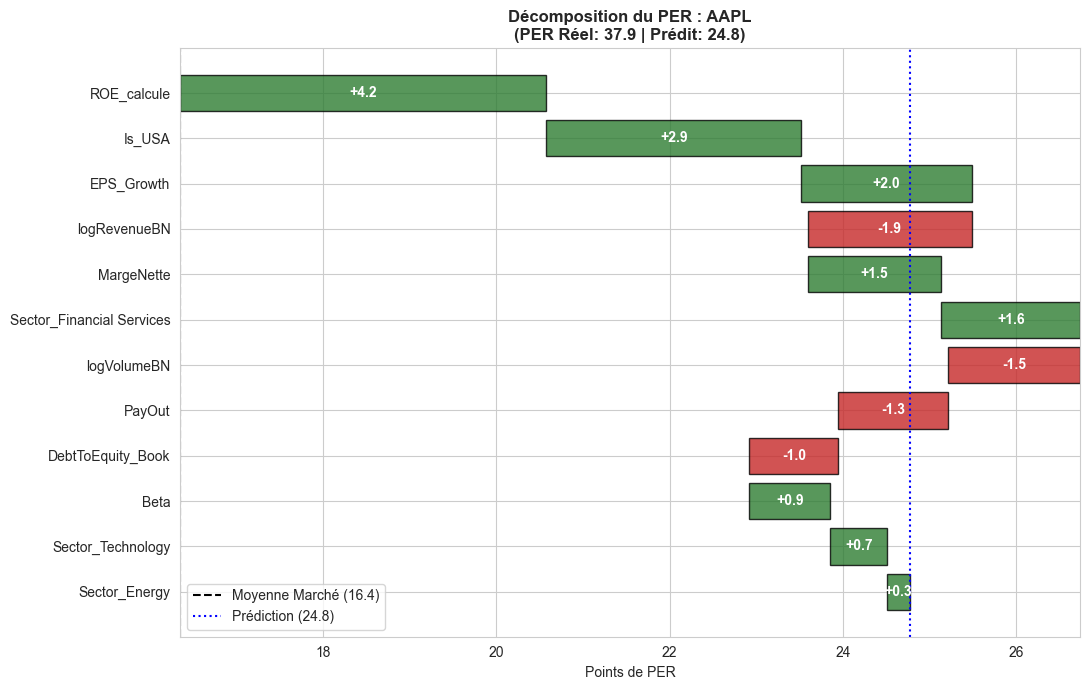

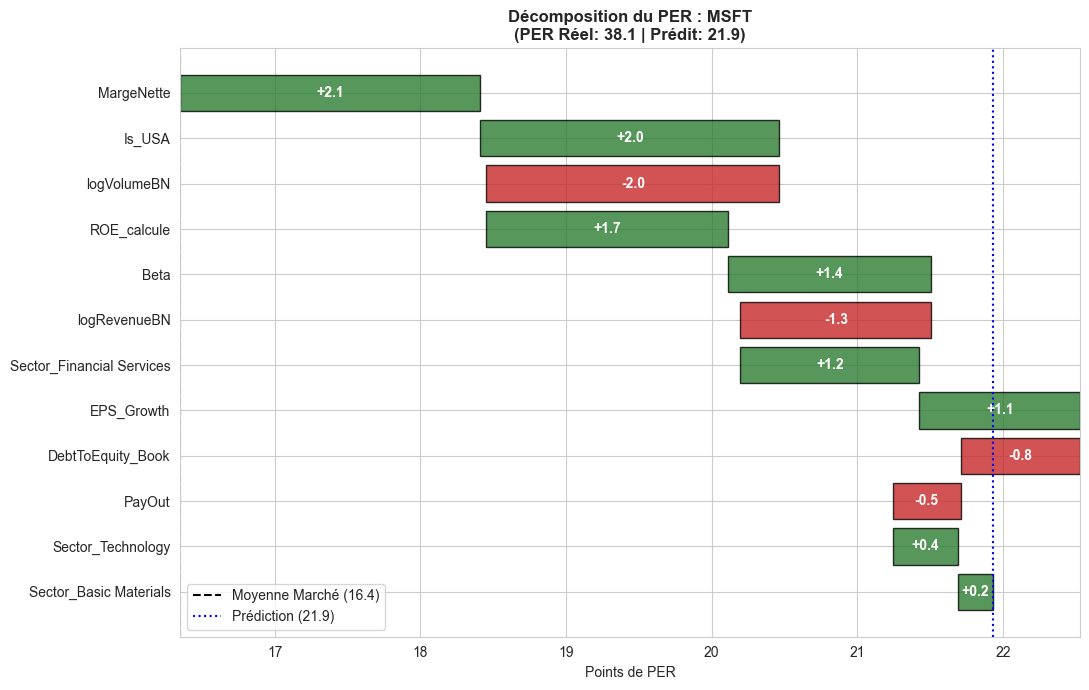

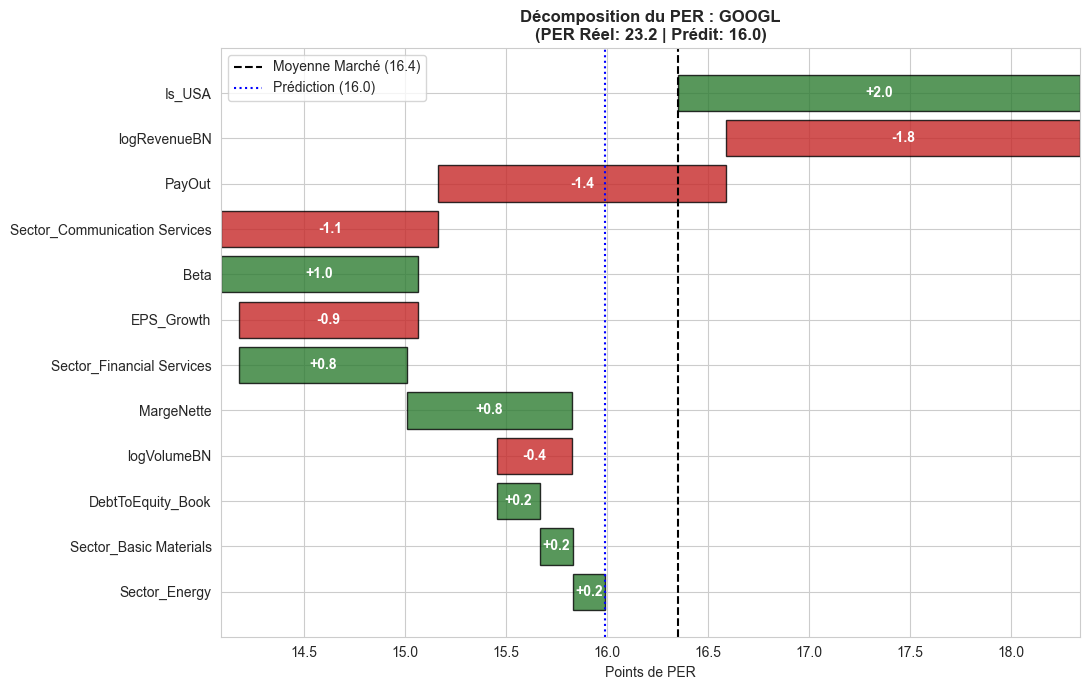

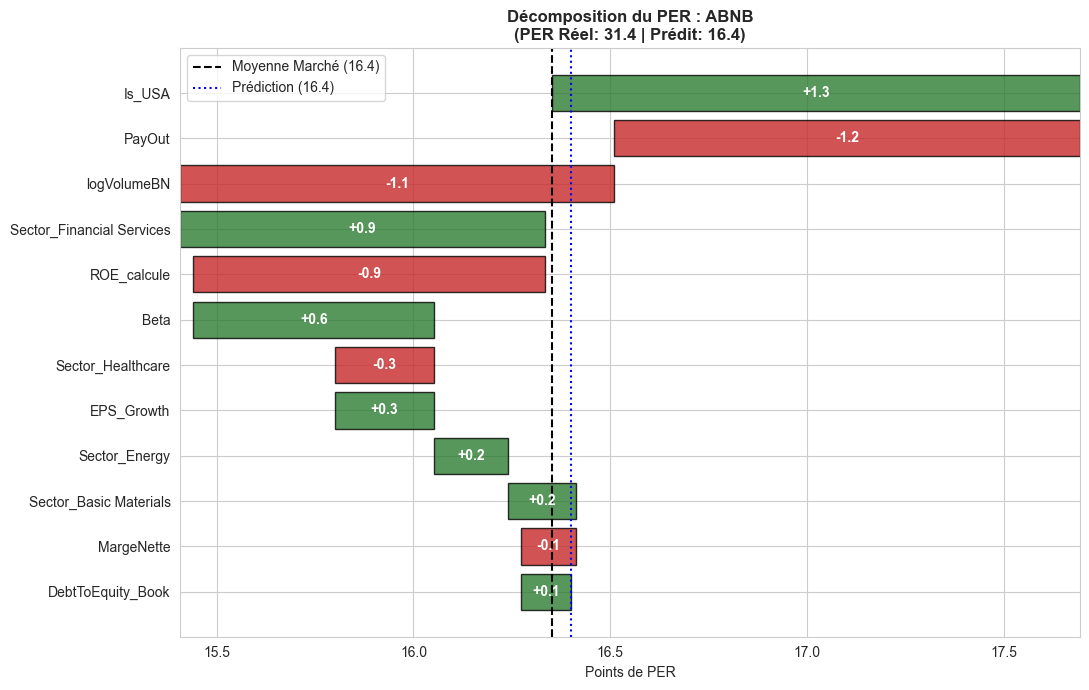

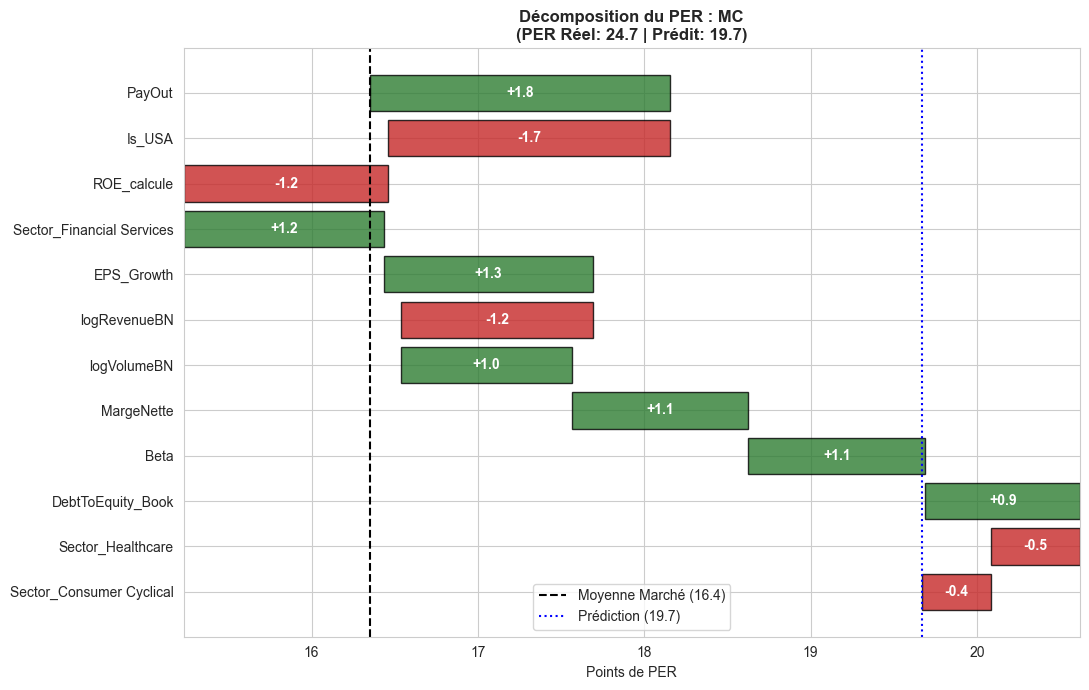

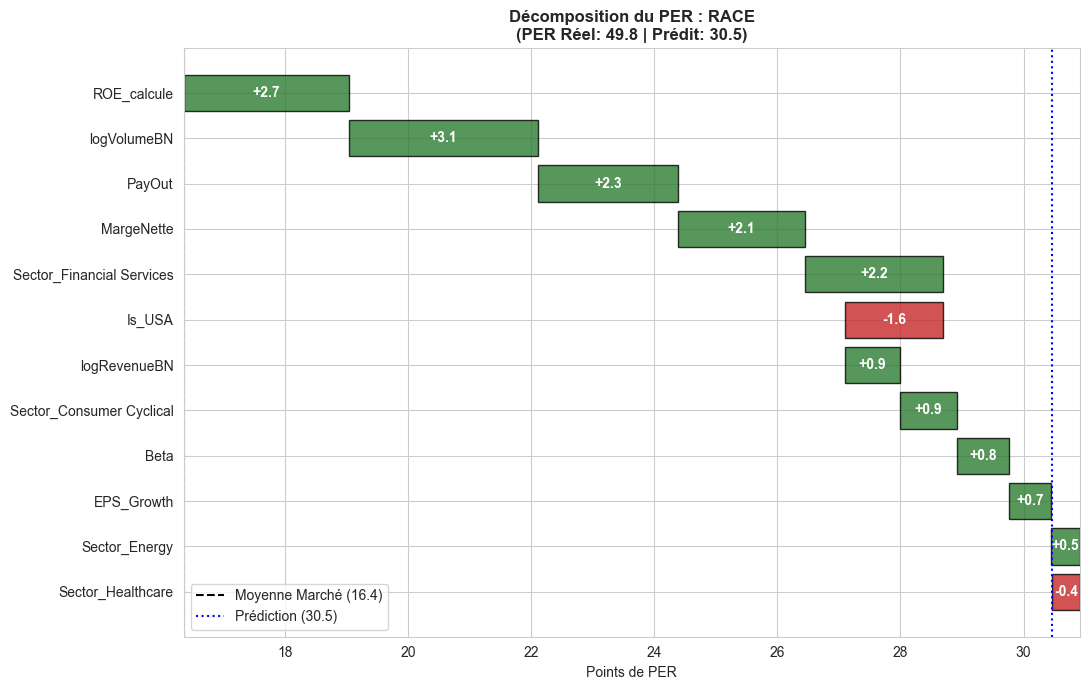

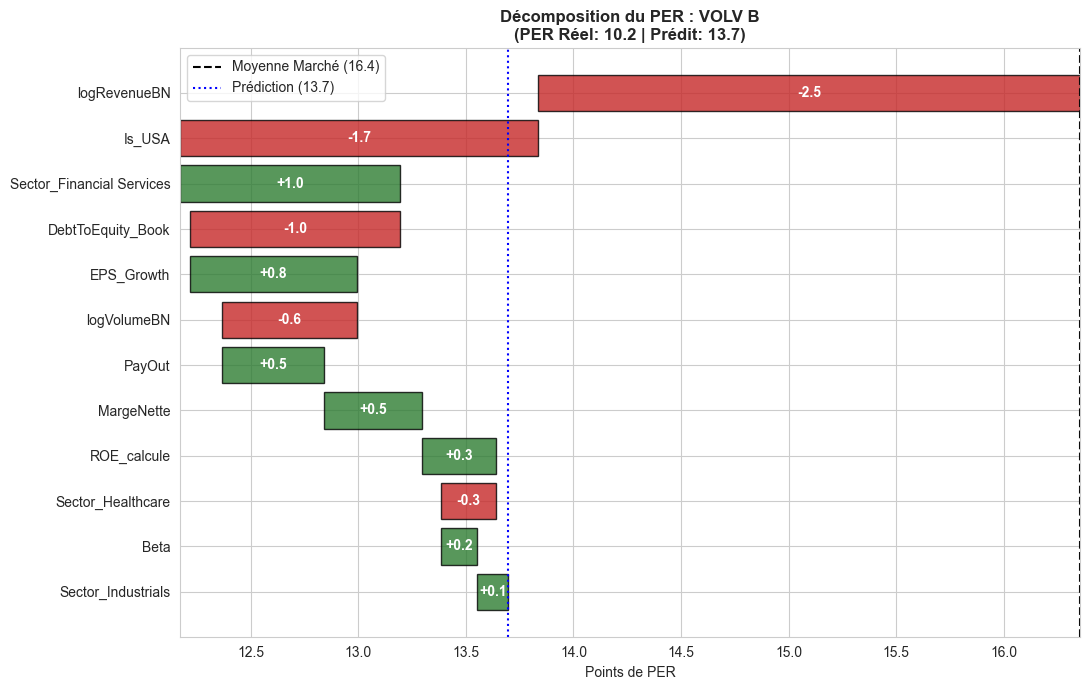

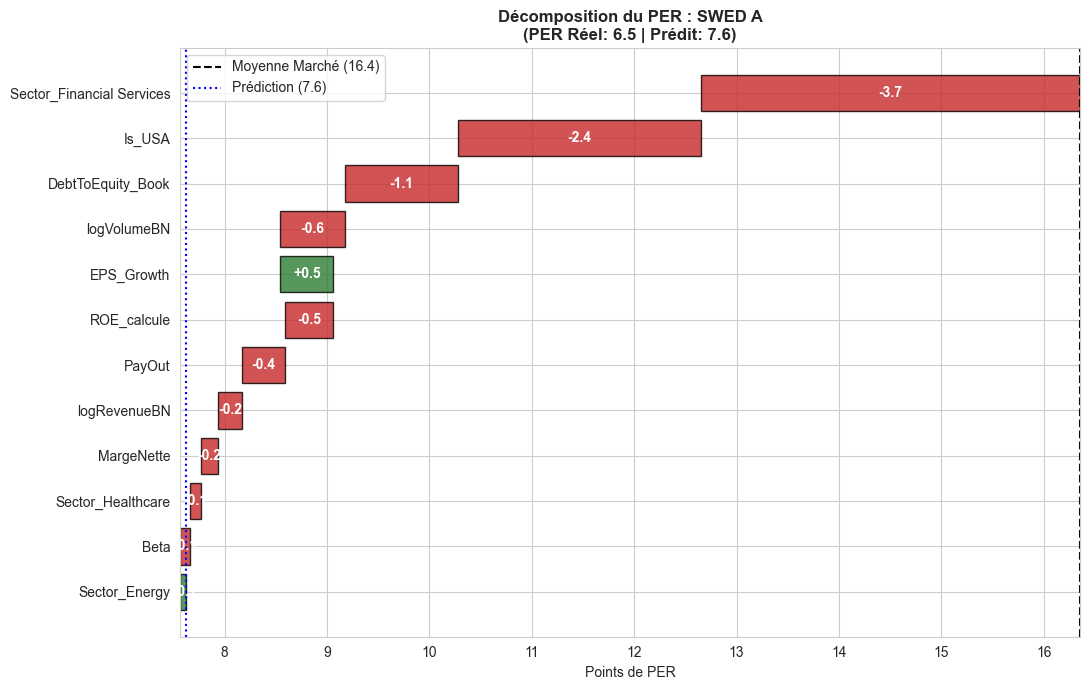

In [31]:
results_df = pd.DataFrame({
    'Ticker': df_encoded.loc[X_test.index, 'Ticker'].values,
    'PER_Reel': y_test_raw.values,
    'PER_Predit': y_pred_real
}, index=X_test.index)

if use_new_api:
    expected_val_log = shap_values_obj[0].base_values
else:
    expected_val_log = explainer.expected_value
    if isinstance(expected_val_log, np.ndarray): expected_val_log = expected_val_log[0]

base_per = np.exp(expected_val_log)
target_tickers = ['JPM', 'BRK-B','TMO', 'AAPL', 'MSFT','GOOGL','ABNB', 'MC', 'RACE','VOLV B','SWED A']

for ticker in target_tickers:
    match = results_df[results_df['Ticker'] == ticker]
    if match.empty: continue
    
    idx_orig = match.index[0]
    idx_shap = list(X_test.index).index(idx_orig)
    
    current_log = expected_val_log
    incremental_per_impacts = []
    feature_impacts = shap_values[idx_shap]
    sorted_indices = np.argsort(np.abs(feature_impacts))[::-1][:12]
    
    current_per = base_per
    for i in sorted_indices:
        new_log = current_log + feature_impacts[i]
        new_per = np.exp(new_log)
        incremental_per_impacts.append(new_per - current_per)
        current_log = new_log
        current_per = new_per

    plt.figure(figsize=(11, 7))
    features_names = [features_final[i] for i in sorted_indices]
    cumulative = base_per
    for i, (name, impact) in enumerate(zip(features_names, incremental_per_impacts)):
        color = '#2e7d32' if impact > 0 else '#c62828'
        plt.barh(i, impact, left=cumulative, color=color, edgecolor='black', alpha=0.8)
        plt.text(cumulative + impact/2, i, f"{impact:+.1f}", va='center', ha='center', fontweight='bold', color='white')
        cumulative += impact
        
    plt.axvline(base_per, color='black', linestyle='--', label=f'Moyenne Marché ({base_per:.1f})')
    plt.axvline(cumulative, color='blue', linestyle=':', label=f'Prédiction ({cumulative:.1f})')
    plt.yticks(range(len(features_names)), features_names)
    plt.gca().invert_yaxis()
    plt.title(f"Décomposition du PER : {ticker}\n(PER Réel: {match.iloc[0]['PER_Reel']:.1f} | Prédit: {cumulative:.1f})", fontweight='bold')
    plt.xlabel("Points de PER")
    plt.legend()
    plt.tight_layout()
    plt.show()

On arrive à obtenir des prédictions plutôt bonnes pour des valeurs normales de PER !

### Conclusion : Un premium de 14% !

L'écart de valorisation entre l'Europe et les USA n'est pas une anomalie irrationnelle.

Notre modèle parvient à expliquer 50% de la variance du PER grâce aux données financières passées et à des catégories sectiorielles et géographiques. Les 50% restants s'expliquent en partie par les anticipations du marché quant aux performances futures des entreprises.

En explorant initialement les données PER, nous avions trouvé un écart médian de 31.4% en faveur des entreprises américaines. Notre modélisation a permis de décomposer cet écart brut en isolant le premium géographique pur des facteurs sectoriels (premium de dynamisme) et financiers (premium de qualité).

L'Europe n'est pas décotée injustement. Elle souffre d'un déficit de champions et d'un mix sectoriel défavorable (trop de banques, pas assez d'entreprises technologiques de croissance). Néanmoins, nous avons aussi montré que la forte valorisation des boîtes technologiques s'expliquait davantage par des facteurs financiers (marge nette, ROE), que par un *premium techn* finalement très faible.

À l'issue de notre étude, nous avons établi l'existence d'un résidu de 14% en faveur des entreprises américaines. C'est le prix de la sécurité juridique américaine et de l'hégémonie du dollar.